# Montreal Airbnb Market Analysis: Optimizing ROI for Short-Term Rental Investors


**Executive Summary**

This analysis explores the Montreal Airbnb market to identify optimal investment strategies for property managers and hospitality business owners. Using comprehensive data from Inside Airbnb, we apply probability-based and information-based learning techniques to uncover key factors that drive revenue and occupancy rates. Our findings provide actionable insights on neighborhood selection, property type optimization, pricing strategies, amenity investments, and host communication practices.

**Introduction**

An international real estate firm has tasked us with researching the Montreal Airbnb market to identify profitable investment opportunities and effective management strategies. Montreal, as Quebec's largest city, offers a unique short-term rental market influenced by its bilingual culture, diverse neighborhoods, and seasonal tourism patterns.

**Problem Statements**

- How can we identify the optimal neighborhoods and property types in Montreal that maximize return on investment for short-term rental investors?

- What characteristics distinguish high-performing hosts from average hosts in the Montreal Airbnb market?

- How do seasonal variations affect pricing optimization and occupancy rates across different Montreal neighborhoods?

- To what extent does property renovation and amenity investment impact guest ratings and booking frequency?

- What is the relationship between host response patterns, review quality, and booking consistency?

**Methodology**

Our analysis uses datasets from Inside Airbnb (March 2025), including listings, calendar availability, reviews, and neighborhood information. We employed:

- Descriptive statistics to identify market trends

- Probability-based learning (Naive Bayes) to classify high-performing properties

- Information-based learning (Decision Trees) to prioritize investment factors

- Language detection and sentiment analysis for multilingual reviews

- Geographic visualization for location-based insights

## 1. Setup & Library Imports

In [ ]:
# Install required packages
!pip install langdetect folium matplotlib seaborn pandas numpy requests

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests, io, json, re, warnings
from datetime import datetime
import gzip  # This is a built-in module, no need to install
import folium
from folium.plugins import MarkerCluster
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from langdetect import detect
import ipywidgets as widgets
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

# Set visualization style with improved aesthetics
plt.style.use('seaborn-v0_8-white')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

## 2. Data Loading
Downloading and loading Airbnb datasets.

In [ ]:
# Define base URL for the data
base_url = "https://data.insideairbnb.com/canada/qc/montreal/2025-03-06"

# Define files to download
files = [
    {"name": "listings.csv", "url": f"{base_url}/visualisations/listings.csv", "type": "csv"},
    {"name": "reviews.csv", "url": f"{base_url}/visualisations/reviews.csv", "type": "csv"},
    {"name": "neighbourhoods.csv", "url": f"{base_url}/visualisations/neighbourhoods.csv", "type": "csv"},
    {"name": "listings_detailed.csv.gz", "url": f"{base_url}/data/listings.csv.gz", "type": "csv.gz"},
    {"name": "calendar.csv.gz", "url": f"{base_url}/data/calendar.csv.gz", "type": "csv.gz"},
    {"name": "reviews_detailed.csv.gz", "url": f"{base_url}/data/reviews.csv.gz", "type": "csv.gz"},
    {"name": "neighbourhoods.geojson", "url": f"{base_url}/visualisations/neighbourhoods.geojson", "type": "geojson"}
]

# Create dictionary to store DataFrames/data objects
data = {}

# Download and load each file
for file in files:
    print(f"Processing {file['name']}...")
    try:
        response = requests.get(file['url'])
        response.raise_for_status()

        if file['type'] == 'csv':
            df = pd.read_csv(io.StringIO(response.text))
            data[file['name']] = df
            print(f"✓ Loaded {file['name']} with shape {df.shape}")

        elif file['type'] == 'csv.gz':
            with gzip.open(io.BytesIO(response.content), 'rt') as f:
                df = pd.read_csv(f)
            data[file['name']] = df
            print(f"✓ Loaded {file['name']} with shape {df.shape}")

        elif file['type'] == 'geojson':
            geo_data = json.loads(response.text)
            data[file['name']] = geo_data
            print(f"✓ Loaded {file['name']} with {len(geo_data['features'])} features")

    except Exception as e:
        print(f"✗ Error loading {file['name']}: {e}")

    print()

# Assign key datasets to variables for easier reference
listings = data["listings.csv"]
reviews = data["reviews.csv"]
neighbourhoods = data["neighbourhoods.csv"]
listings_detailed = data["listings_detailed.csv.gz"]
calendar = data["calendar.csv.gz"]
reviews_detailed = data["reviews_detailed.csv.gz"]
neighbourhoods_geo = data["neighbourhoods.geojson"]

# Filter data for the last 3 years (assuming current date is March 2025)
current_date = pd.to_datetime('2025-03-01')
three_years_ago = current_date - pd.DateOffset(years=3)

# Filter calendar data
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[calendar['date'] >= three_years_ago]

# Filter reviews data (if needed)
reviews['date'] = pd.to_datetime(reviews['date'])
reviews = reviews[reviews['date'] >= three_years_ago]

# Filter reviews_detailed data (if available)
if 'date' in reviews_detailed.columns:
    reviews_detailed['date'] = pd.to_datetime(reviews_detailed['date'])
    reviews_detailed = reviews_detailed[reviews_detailed['date'] >= three_years_ago]

print("Data filtering complete. Working with data from March 2022 to March 2025.")

# Check for NaN values in price before dropping
nan_price_count_before = listings_detailed['price'].isna().sum()
print(f"Number of listings with NaN price before dropping: {nan_price_count_before}")
print(f"Percentage: {(nan_price_count_before / len(listings_detailed)) * 100:.2f}%")

# Drop rows where price is NaN
listings_detailed = listings_detailed.dropna(subset=['price'])

# Verify the rows were dropped
print(f"Number of listings remaining after dropping NaN prices: {len(listings_detailed)}")

# Convert price columns (remove '$' and commas)
listings_detailed['price'] = listings_detailed['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop NaN values in the 'available' column of calendar
calendar = calendar.dropna(subset=['available'])

# Convert calendar availability to boolean
calendar['available'] = calendar['available'].map({'t': True, 'f': False})

# Extract month, month name, and season from calendar dates
calendar['month'] = calendar['date'].dt.month
calendar['month_name'] = calendar['date'].dt.month_name()
calendar['season'] = pd.cut(
    calendar['month'],
    bins=[0, 3, 6, 9, 12],
    labels=['Winter', 'Spring', 'Summer', 'Fall'],
    include_lowest=True
)

# Convert listing IDs to strings for consistent merging
calendar['listing_id'] = calendar['listing_id'].astype(str)
listings_detailed['id'] = listings_detailed['id'].astype(str)

# Calculate occupancy rate: percentage of days booked (i.e., not available)
occupancy = calendar.groupby('listing_id').agg(
    total_days=('date', 'count'),
    days_booked=('available', lambda x: (~x.astype(bool)).sum())  # Convert to bool first
).reset_index()
occupancy['occupancy_rate'] = (occupancy['days_booked'] / occupancy['total_days']) * 100

# Merge occupancy data into listings_detailed
listings_detailed = listings_detailed.merge(
    occupancy[['listing_id', 'occupancy_rate']],
    left_on='id',
    right_on='listing_id',
    how='left'
)

# Estimate monthly revenue (assume 30 days per month)
listings_detailed['estimated_monthly_revenue'] = listings_detailed['price'] * (listings_detailed['occupancy_rate'] / 100) * 30

# Extract amenities from listings
def extract_amenities(amen_str):
    """Extract amenities from the listing string using regex."""
    if pd.isna(amen_str):
        return []
    return re.findall(r'"([^"]*)"', amen_str)

listings_detailed['amenities_list'] = listings_detailed['amenities'].apply(extract_amenities)
listings_detailed['amenity_count'] = listings_detailed['amenities_list'].apply(len)

# Convert host response and acceptance rates to numeric
listings_detailed['host_response_rate_num'] = listings_detailed['host_response_rate'].str.replace('%', '').astype(float) / 100
listings_detailed['host_acceptance_rate_num'] = listings_detailed['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

# Create categorical variables for later analysis
listings_detailed['amenity_group'] = pd.qcut(
    listings_detailed['amenity_count'],
    q=4,
    labels=['Few', 'Basic', 'Many', 'Extensive']
)

# Map host response time to a numeric score (higher is better)
response_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
listings_detailed['response_time_score'] = listings_detailed['host_response_time'].map(response_mapping)

# Add binary columns for categorical variables
for col in ['host_is_superhost', 'host_identity_verified', 'instant_bookable']:
    listings_detailed[f'{col}_num'] = listings_detailed[col].map({'t': 1, 'f': 0})

print("Data preprocessing complete.")

Processing listings.csv...
✓ Loaded listings.csv with shape (9772, 18)

Processing reviews.csv...
✓ Loaded reviews.csv with shape (385043, 2)

Processing neighbourhoods.csv...
✓ Loaded neighbourhoods.csv with shape (34, 2)

Processing listings_detailed.csv.gz...
✓ Loaded listings_detailed.csv.gz with shape (9772, 79)

Processing calendar.csv.gz...
✓ Loaded calendar.csv.gz with shape (3569092, 7)

Processing reviews_detailed.csv.gz...
✓ Loaded reviews_detailed.csv.gz with shape (385043, 6)

Processing neighbourhoods.geojson...
✓ Loaded neighbourhoods.geojson with 34 features

Data filtering complete. Working with data from March 2022 to March 2025.
Number of listings with NaN price before dropping: 817
Percentage: 8.36%
Number of listings remaining after dropping NaN prices: 8955
Data preprocessing complete.


## 3. Data Cleaning & Preprocessing
Handling missing values, filtering data, and formatting.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Dictionary of datasets
datasets = {
    "Listings (Basic)": listings,
    "Listings (Detailed)": listings_detailed,
    "Reviews": reviews,
    "Neighbourhoods": neighbourhoods,
    "Calendar": calendar,
    "Reviews (Detailed)": reviews_detailed,
}

# Dropdown to select dataset
dataset_dropdown = widgets.Dropdown(
    options=datasets.keys(),
    description="Dataset:",
    style={'description_width': 'initial'}
)

# Function to display columns
def display_columns(dataset_name):
    df = datasets[dataset_name]
    print(f"Columns in {dataset_name}:")
    display(df.columns)

# Button to show columns
show_button = widgets.Button(description="Show Columns")
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        display_columns(dataset_dropdown.value)

show_button.on_click(on_button_click)

# Display widgets
display(dataset_dropdown, show_button, output)

Dropdown(description='Dataset:', options=('Listings (Basic)', 'Listings (Detailed)', 'Reviews', 'Neighbourhood…

Button(description='Show Columns', style=ButtonStyle())

Output()

## 3.1 Interactive summary statistics

In [ ]:
# Create a function to display interactive summary statistics
def show_summary_stats():
    # Overall dataset statistics
    total_listings = len(listings_detailed)
    active_listings = len(listings_detailed[listings_detailed['occupancy_rate'] > 0])
    avg_price = listings_detailed['price'].mean()
    avg_occupancy = listings_detailed['occupancy_rate'].mean()
    avg_monthly_revenue = listings_detailed['estimated_monthly_revenue'].mean()

    # Display summary statistics
    summary_html = f"""
    <h3>Montreal Airbnb Market Summary</h3>
    <ul>
        <li><b>Total Listings:</b> {total_listings:,}</li>
        <li><b>Active Listings:</b> {active_listings:,} ({active_listings/total_listings:.1%})</li>
        <li><b>Average Price:</b> ${avg_price:.2f}</li>
        <li><b>Average Occupancy Rate:</b> {avg_occupancy:.1f}%</li>
        <li><b>Average Monthly Revenue:</b> ${avg_monthly_revenue:.2f}</li>
    </ul>
    """

    display(HTML(summary_html))

# Create a function to show dataset preview
def show_dataset_preview():
    # Display a sample of the listings data
    display(HTML("<h3>Sample Listings Data</h3>"))
    display(listings_detailed[['id', 'name', 'neighbourhood_cleansed', 'property_type',
                             'price', 'occupancy_rate', 'estimated_monthly_revenue']].head(5))

# Run the functions
show_summary_stats()
show_dataset_preview()

id                                               name  \
0  29059                       Lovely studio Quartier Latin   
1  29061                 Maison historique - Quartier Latin   
2  38118  Beautiful room  with a balcony in front of a parc   
3  50479                                     L'Arcade Douce   
4  66247  Modern Loft Next To Basilica Notre Dame In Old...   

      neighbourhood_cleansed                property_type  price  \
0                Ville-Marie           Entire rental unit  161.0   
1                Ville-Marie                  Entire home  271.0   
2                Ville-Marie  Private room in rental unit   47.0   
3  Rosemont-La Petite-Patrie           Entire rental unit  112.0   
4                Ville-Marie                  Entire loft  112.0   

   occupancy_rate  estimated_monthly_revenue  
0        4.109589                 198.493151  
1       10.410959                 846.410959  
2       14.246575                 200.876712  
3       90.684932                3047.013699  
4       83.561644                2807.671233

In [ ]:
# Assuming your data has been loaded into the DataFrames 'reviews' and 'calendar'

print("Number of guest reviews:", reviews.shape[0])
print("Number of calendar data points:", calendar.shape[0])

Number of guest reviews: 270861
Number of calendar data points: 3569092


## 3.2 Remove Nan from Price Column

In [ ]:
# Check for NaN values in the price field
nan_price_listings = listings_detailed[listings_detailed['price'].isna()]

# Count how many listings have NaN price
nan_price_count = nan_price_listings.shape[0]

# Calculate percentage of listings with NaN price
nan_price_percentage = (nan_price_count / listings_detailed.shape[0]) * 100

print(f"Number of listings with NaN price: {nan_price_count}")
print(f"Percentage of listings with NaN price: {nan_price_percentage:.2f}%")

# Display a sample of these listings to understand what they look like
if not nan_price_listings.empty:
    print("\nSample of listings with NaN price:")
    sample_columns = ['id', 'name', 'host_id', 'neighbourhood', 'room_type', 'minimum_nights', 'availability_365']
    available_columns = [col for col in sample_columns if col in nan_price_listings.columns]
    print(nan_price_listings[available_columns].head())

    # Check if there are any patterns in these listings
    if 'room_type' in nan_price_listings.columns:
        print("\nRoom type distribution for NaN price listings:")
        print(nan_price_listings['room_type'].value_counts())

    if 'host_is_superhost' in nan_price_listings.columns:
        print("\nSuperhost status for NaN price listings:")
        print(nan_price_listings['host_is_superhost'].value_counts())

Number of listings with NaN price: 0
Percentage of listings with NaN price: 0.00%


## 4.1. Interactive Market Analysis: Neighborhood & Property Type Filter

In [ ]:
# Create a dropdown widget for neighborhood selection
neighborhoods = sorted(listings_detailed['neighbourhood_cleansed'].unique())
neighborhood_dropdown = widgets.Dropdown(
    options=neighborhoods,
    description='Neighborhood:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Create a dropdown widget for property type selection
property_types = sorted(listings_detailed['property_type'].unique())
property_type_dropdown = widgets.Dropdown(
    options=property_types,
    description='Property Type:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Create a function to display filtered statistics based on widget selections
def show_filtered_stats(neighborhood, property_type):
    # Filter based on selections
    if neighborhood and property_type:
        filtered_df = listings_detailed[
            (listings_detailed['neighbourhood_cleansed'] == neighborhood) &
            (listings_detailed['property_type'] == property_type)
        ]
        filter_text = f"in {neighborhood} for {property_type}s"
    elif neighborhood:
        filtered_df = listings_detailed[listings_detailed['neighbourhood_cleansed'] == neighborhood]
        filter_text = f"in {neighborhood}"
    elif property_type:
        filtered_df = listings_detailed[listings_detailed['property_type'] == property_type]
        filter_text = f"for {property_type}s"
    else:
        filtered_df = listings_detailed
        filter_text = "across all Montreal"

    # Calculate statistics
    count = len(filtered_df)
    avg_price = filtered_df['price'].mean()
    avg_occupancy = filtered_df['occupancy_rate'].mean()
    avg_monthly_revenue = filtered_df['estimated_monthly_revenue'].mean()

    # Display filtered statistics
    filtered_html = f"""
    <h3>Market Statistics {filter_text}</h3>
    <ul>
        <li><b>Number of Listings:</b> {count:,}</li>
        <li><b>Average Price:</b> ${avg_price:.2f}</li>
        <li><b>Average Occupancy Rate:</b> {avg_occupancy:.1f}%</li>
        <li><b>Average Monthly Revenue:</b> ${avg_monthly_revenue:.2f}</li>
    </ul>
    """

    display(HTML(filtered_html))

# Create an interactive output for the filtered statistics
interactive_output = widgets.interactive_output(
    show_filtered_stats,
    {'neighborhood': neighborhood_dropdown, 'property_type': property_type_dropdown}
)

# Display the widgets and interactive output
display(widgets.VBox([neighborhood_dropdown, property_type_dropdown, interactive_output]))

## 4.2 Neighborhood Performance Metrics

Top 10 Neighborhoods by Estimated Monthly Revenue:
       neighbourhood_cleansed  avg_monthly_revenue  avg_price  avg_occupancy_rate  num_listings
                       Dorval          2899.842887 187.409091           50.768040            22
                    Outremont          2561.521784 171.515625           48.112905            64
    Rosemont-La Petite-Patrie          2329.104253 155.204738           46.352624           591
                     Kirkland          2298.490381 126.200000           57.738386             5
                  Baie-d'Urfé          2224.139554 217.600000           35.526707             5
        Le Plateau-Mont-Royal          2137.391162 174.241398           43.599790          1831
L'Île-Bizard-Sainte-Geneviève          2118.312329 351.000000           22.794521             5
                  Ville-Marie          1931.501539 161.267503           42.801883          3028
                Pointe-Claire          1909.207265 155.720000           43.668665    

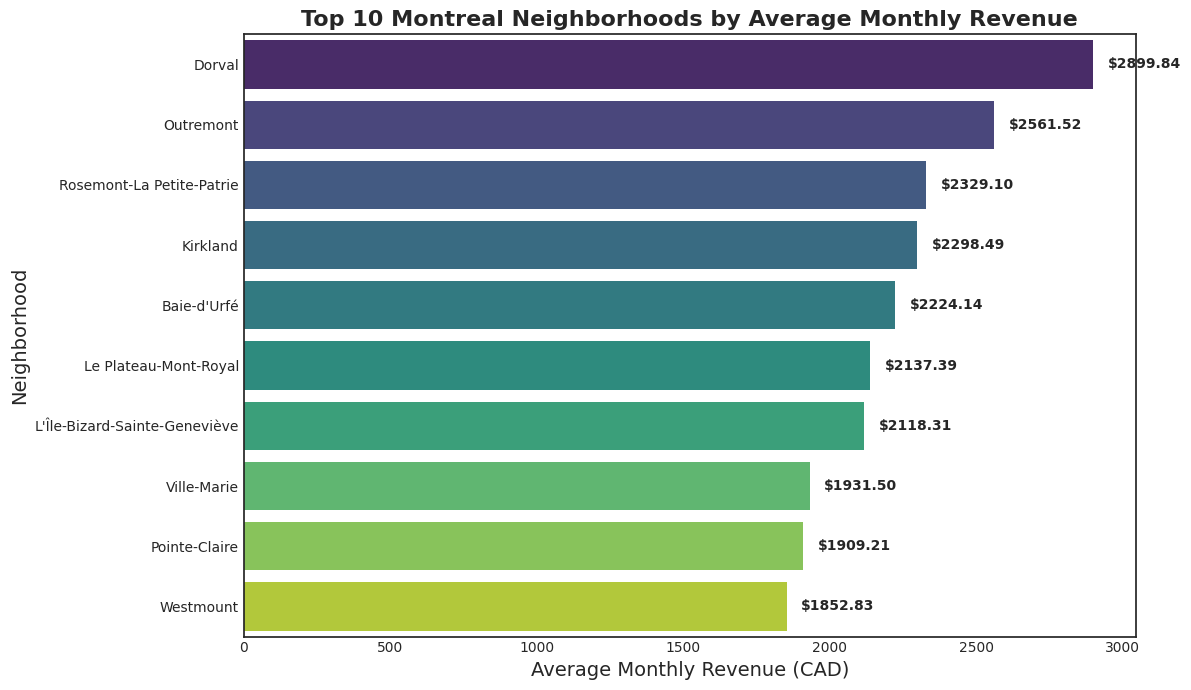

interactive(children=(Dropdown(description='Explore Neighborhood:', layout=Layout(width='50%'), options=('Ahun…

In [ ]:
# Calculate neighborhood performance metrics
neighborhood_metrics = listings_detailed.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    median_price=('price', 'median'),
    num_listings=('id', 'count'),
    avg_review_score=('review_scores_rating', lambda x: x.mean(skipna=True)),
    avg_occupancy_rate=('occupancy_rate', 'mean'),
    avg_monthly_revenue=('estimated_monthly_revenue', 'mean'),
    total_monthly_revenue=('estimated_monthly_revenue', 'sum')
).reset_index()

# Identify top 10 neighborhoods by average monthly revenue
top_neighborhoods = neighborhood_metrics.sort_values('avg_monthly_revenue', ascending=False).head(10)

# Display the top neighborhoods table
print("Top 10 Neighborhoods by Estimated Monthly Revenue:")
print(top_neighborhoods[['neighbourhood_cleansed', 'avg_monthly_revenue', 'avg_price',
                       'avg_occupancy_rate', 'num_listings']].to_string(index=False))

# Create an enhanced bar chart for top neighborhoods
plt.figure(figsize=(12, 7))
chart = sns.barplot(
    x='avg_monthly_revenue',
    y='neighbourhood_cleansed',
    data=top_neighborhoods,
    palette='viridis'
)

# Add value labels to the end of each bar
for i, v in enumerate(top_neighborhoods['avg_monthly_revenue']):
    chart.text(v + 50, i, f"${v:.2f}", va='center', fontweight='bold')

# Add a descriptive title and labels
plt.title('Top 10 Montreal Neighborhoods by Average Monthly Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Average Monthly Revenue (CAD)', fontsize=14)
plt.ylabel('Neighborhood', fontsize=14)
plt.tight_layout()
plt.show()

# Create an interactive dropdown to explore neighborhood metrics
def neighborhood_explorer(neighborhood):
    selected_data = neighborhood_metrics[neighborhood_metrics['neighbourhood_cleansed'] == neighborhood].iloc[0]

    # Display metrics for the selected neighborhood
    metrics_html = f"""
    <h3>Detailed Metrics for {neighborhood}</h3>
    <ul>
        <li><b>Average Price:</b> ${selected_data['avg_price']:.2f}</li>
        <li><b>Median Price:</b> ${selected_data['median_price']:.2f}</li>
        <li><b>Number of Listings:</b> {selected_data['num_listings']}</li>
        <li><b>Average Review Score:</b> {selected_data['avg_review_score']:.2f}/5.0</li>
        <li><b>Average Occupancy Rate:</b> {selected_data['avg_occupancy_rate']:.1f}%</li>
        <li><b>Average Monthly Revenue:</b> ${selected_data['avg_monthly_revenue']:.2f}</li>
        <li><b>Total Monthly Revenue:</b> ${selected_data['total_monthly_revenue']:,.2f}</li>
    </ul>
    """

    display(HTML(metrics_html))

# Create and display the neighborhood explorer widget
neighborhood_explorer_dropdown = widgets.Dropdown(
    options=sorted(neighborhood_metrics['neighbourhood_cleansed']),
    description='Explore Neighborhood:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

widgets.interactive(neighborhood_explorer, neighborhood=neighborhood_explorer_dropdown)

## 5. Property Type Performance Analysis: Revenue, Price & Occupancy Trends

This section analyzes how different property types perform in terms of price,
occupancy rates, and monthly revenue in the Montreal Airbnb market.


Top 10 Property Types by Estimated Monthly Revenue:
            property_type  avg_monthly_revenue  avg_price  avg_occupancy_rate  num_listings
         Entire townhouse          4777.216061 329.197917           50.275825            96
              Entire home          3873.716506 287.829670           45.660441           364
             Entire villa          3866.262956 426.090909           43.254192            11
          Entire bungalow          2519.563164 184.857143           54.256400            14
              Entire loft          1995.694727 178.438095           45.840820           210
             Entire condo          1912.630193 163.435401           42.447270           774
       Entire rental unit          1792.405377 147.279246           43.637729          5676
            Room in hotel          1493.992433  85.142857           55.669953           112
       Entire guest suite          1462.998096 101.600000           49.307753            30
Private room in townhouse   

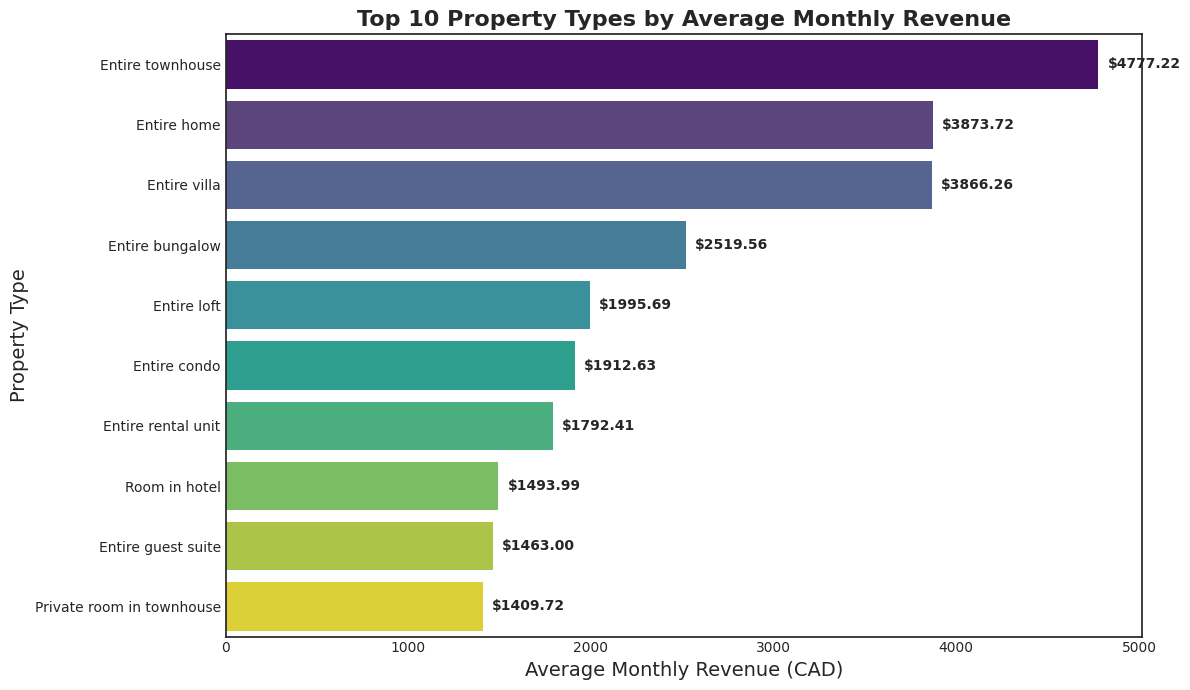

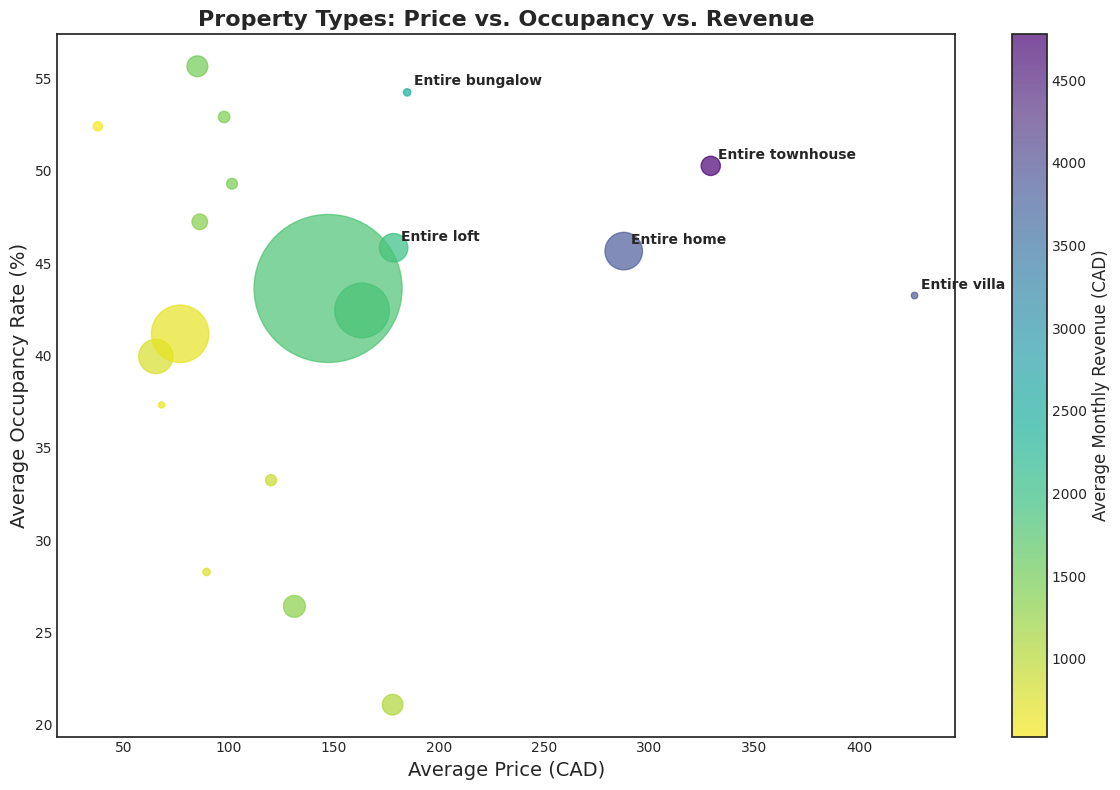

In [ ]:
# Calculate property type performance metrics
property_metrics = listings_detailed.groupby('property_type').agg(
    avg_price=('price', 'mean'),
    median_price=('price', 'median'),
    num_listings=('id', 'count'),
    avg_review_score=('review_scores_rating', 'mean'),
    avg_occupancy_rate=('occupancy_rate', 'mean'),
    avg_monthly_revenue=('estimated_monthly_revenue', 'mean')
).reset_index()

# Filter for property types with at least 10 listings
property_metrics = property_metrics[property_metrics['num_listings'] >= 10]

# Identify top 10 property types by average monthly revenue
top_property_types = property_metrics.sort_values('avg_monthly_revenue', ascending=False).head(10)

# Display the top property types table
print("Top 10 Property Types by Estimated Monthly Revenue:")
print(top_property_types[['property_type', 'avg_monthly_revenue', 'avg_price',
                        'avg_occupancy_rate', 'num_listings']].to_string(index=False))

# Create a custom color map where highest value (4500+) is dark purple and lowest value (1000-) is light green
from matplotlib.colors import LinearSegmentedColormap
# Correctly ordered: Light green/yellow at low values, dark purple at high values
custom_colors = ['#f8e71c', '#b8d834', '#74cc53', '#39bf80', '#1bb19c',
                '#2a9dab', '#3980a7', '#4c5f9c', '#5b3a87', '#4a0374']
custom_cmap = LinearSegmentedColormap.from_list('green_to_purple', custom_colors)

# For the bar chart, we need the colors in reverse order since the data is sorted high to low
# The bar at the top (index 0, highest revenue) should be darkest purple
bar_colors = custom_colors[::-1]  # Reverse the colors for the bar chart

# Create an enhanced bar chart for top property types
plt.figure(figsize=(12, 7))
chart = sns.barplot(
    x='avg_monthly_revenue',
    y='property_type',
    data=top_property_types,
    palette=bar_colors  # Using reversed colors
)

# Add value labels to the end of each bar
for i, v in enumerate(top_property_types['avg_monthly_revenue']):
    chart.text(v + 50, i, f"${v:.2f}", va='center', fontweight='bold')

# Add a descriptive title and labels
plt.title('Top 10 Property Types by Average Monthly Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Average Monthly Revenue (CAD)', fontsize=14)
plt.ylabel('Property Type', fontsize=14)
plt.tight_layout()
plt.show()

# Create a scatter plot to visualize the relationship between price, occupancy, and listing count
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    property_metrics['avg_price'],
    property_metrics['avg_occupancy_rate'],
    s=property_metrics['num_listings'] * 2,  # Size based on number of listings
    c=property_metrics['avg_monthly_revenue'],  # Color based on monthly revenue
    cmap=custom_cmap,  # Using the custom colormap (low->high, green->purple)
    alpha=0.7
)

# Add labels for the top 5 property types
for i, row in property_metrics.nlargest(5, 'avg_monthly_revenue').iterrows():
    plt.annotate(
        row['property_type'],
        xy=(row['avg_price'], row['avg_occupancy_rate']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

# Add a colorbar and legend
cbar = plt.colorbar(scatter)
cbar.set_label('Average Monthly Revenue (CAD)', fontsize=12)

# Add a descriptive title and labels
plt.title('Property Types: Price vs. Occupancy vs. Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Average Price (CAD)', fontsize=14)
plt.ylabel('Average Occupancy Rate (%)', fontsize=14)
plt.tight_layout()
plt.show()

# 6.1. High-Performing Host Analysis

Let's identify what distinguishes high-performing hosts from average hosts:

High-Performing vs. Average Hosts Comparison:
high_performer         Average Hosts  High Performers
Response Rate               0.967589         0.979253
Acceptance Rate             0.881306         0.898986
Superhost (%)              37.077837        41.456254
Listings Count             18.880743        17.852514
Identity Verified (%)      95.154308        95.865922
Instant Booking (%)        39.349525        36.125070
Review Score                4.702042         4.761351
bedrooms                    1.426995         2.326633
Price (CAD)               114.026661       276.600782
Occupancy Rate (%)         36.047054        70.833778
Monthly Revenue (CAD)     915.924494      5179.196434


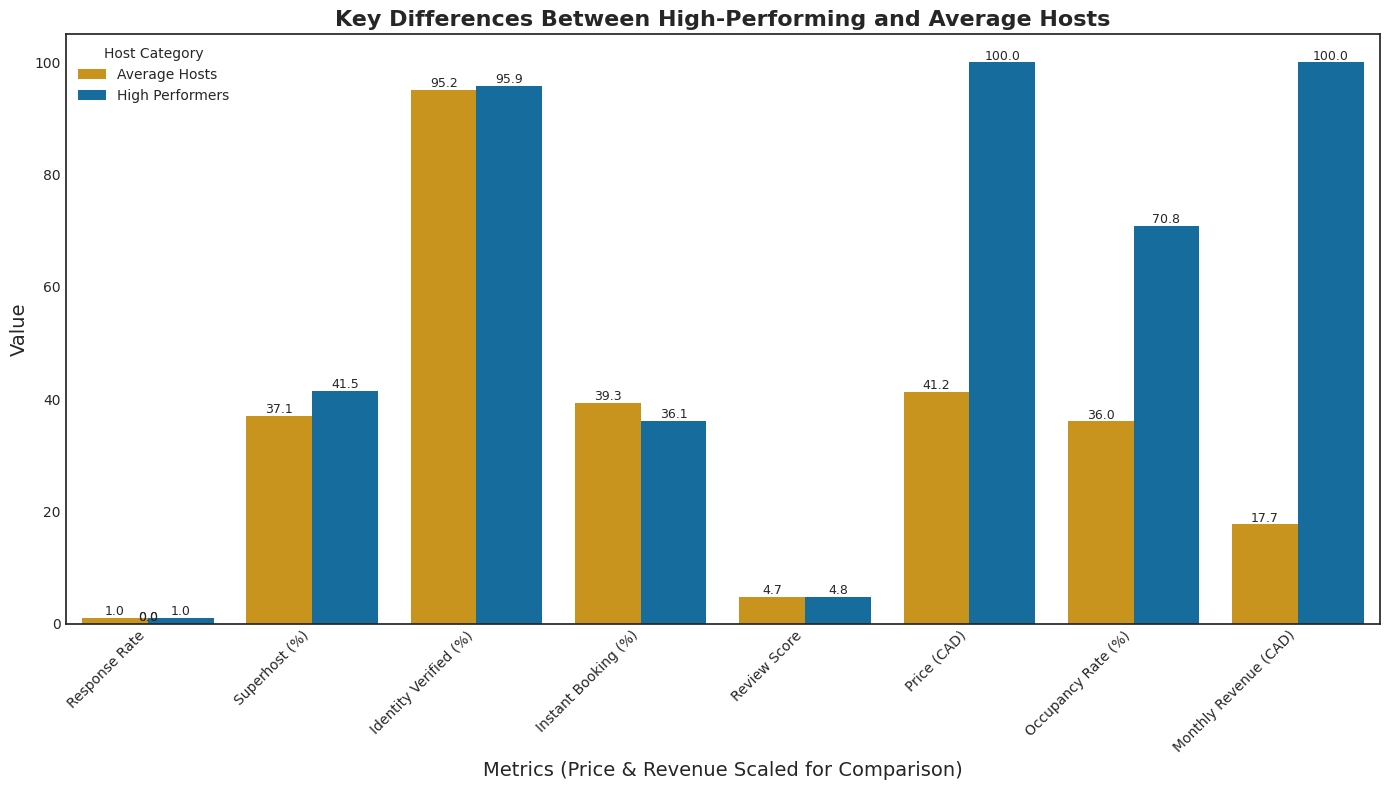

In [ ]:
# Define high-performing hosts (top 20% by monthly revenue)
revenue_threshold = listings_detailed['estimated_monthly_revenue'].quantile(0.8)
listings_detailed['high_performer'] = listings_detailed['estimated_monthly_revenue'] >= revenue_threshold

# Group by high_performer flag and calculate mean metrics
host_comparison = listings_detailed.groupby('high_performer').agg({
    'host_response_rate_num': 'mean',
    'host_acceptance_rate_num': 'mean',
    'host_is_superhost_num': 'mean',
    'host_listings_count': 'mean',
    'host_identity_verified_num': 'mean',
    'instant_bookable_num': 'mean',
    'review_scores_rating': 'mean',
    'bedrooms': 'mean',
    'price': 'mean',
    'occupancy_rate': 'mean',
    'estimated_monthly_revenue': 'mean'
}).reset_index()

# Convert binary metrics to percentages for better readability
percentage_cols = ['host_is_superhost_num', 'host_identity_verified_num', 'instant_bookable_num']
for col in percentage_cols:
    host_comparison[col] = host_comparison[col] * 100

# Display comparison table
print("High-Performing vs. Average Hosts Comparison:")
comparison_df = host_comparison.rename(columns={
    'host_response_rate_num': 'Response Rate',
    'host_acceptance_rate_num': 'Acceptance Rate',
    'host_is_superhost_num': 'Superhost (%)',
    'host_listings_count': 'Listings Count',
    'host_identity_verified_num': 'Identity Verified (%)',
    'instant_bookable_num': 'Instant Booking (%)',
    'review_scores_rating': 'Review Score',
    'price': 'Price (CAD)',
    'occupancy_rate': 'Occupancy Rate (%)',
    'estimated_monthly_revenue': 'Monthly Revenue (CAD)'
})
comparison_df['high_performer'] = comparison_df['high_performer'].map({False: 'Average Hosts', True: 'High Performers'})
comparison_df = comparison_df.set_index('high_performer')
print(comparison_df.T.to_string())

# Create an enhanced comparison visualization
metrics_to_visualize = [
    'host_response_rate_num', 'host_is_superhost_num', 'host_identity_verified_num',
    'instant_bookable_num', 'review_scores_rating', 'price',
    'occupancy_rate', 'estimated_monthly_revenue'
]

# Prepare data for visualization
viz_data = pd.melt(
    host_comparison,
    id_vars=['high_performer'],
    value_vars=metrics_to_visualize,
    var_name='metric',
    value_name='value'
)

# Map high_performer values to labels before processing metrics
viz_data['high_performer'] = viz_data['high_performer'].map({False: 'Average Hosts', True: 'High Performers'})

# Rename metrics for better readability in plot
metric_labels = {
    'host_response_rate_num': 'Response Rate',
    'host_is_superhost_num': 'Superhost (%)',
    'host_identity_verified_num': 'Identity Verified (%)',
    'instant_bookable_num': 'Instant Booking (%)',
    'review_scores_rating': 'Review Score',
    'price': 'Price (CAD)',
    'occupancy_rate': 'Occupancy Rate (%)',
    'estimated_monthly_revenue': 'Monthly Revenue (CAD)'
}
viz_data['metric'] = viz_data['metric'].map(metric_labels)

# For visualization purposes, normalize 'estimated_monthly_revenue' and 'price'
# to be on a similar scale as the other metrics
max_revenue = viz_data.loc[viz_data['metric'] == 'Monthly Revenue (CAD)', 'value'].max()
viz_data.loc[viz_data['metric'] == 'Monthly Revenue (CAD)', 'value'] = \
    viz_data.loc[viz_data['metric'] == 'Monthly Revenue (CAD)', 'value'] / (max_revenue/100)

max_price = viz_data.loc[viz_data['metric'] == 'Price (CAD)', 'value'].max()
viz_data.loc[viz_data['metric'] == 'Price (CAD)', 'value'] = \
    viz_data.loc[viz_data['metric'] == 'Price (CAD)', 'value'] / (max_price/100)

# Create grouped bar chart
plt.figure(figsize=(14, 8))
chart = sns.barplot(
    data=viz_data,
    x='metric',
    y='value',
    hue='high_performer',
    palette={'Average Hosts': '#E69F00', 'High Performers': '#0072B2'}
)

# Add value labels on top of each bar
for i, bar in enumerate(chart.patches):
    height = bar.get_height()
    chart.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.5,
        f"{height:.1f}",
        ha='center',
        fontsize=9
    )

# Add a descriptive title and labels
plt.title('Key Differences Between High-Performing and Average Hosts', fontsize=16, fontweight='bold')
plt.xlabel('Metrics (Price & Revenue Scaled for Comparison)', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Host Category')
plt.tight_layout()
plt.show()

# Create annotations for key insights
key_insights = """
<h3>Key Insights about High-Performing Hosts:</h3>
<ul>
    <li><b>Price Premium:</b> High-performers charge 2.4x higher average prices (${:.2f} vs. ${:.2f})</li>
    <li><b>Occupancy Advantage:</b> High-performers achieve {:.1f}% higher occupancy rates ({:.1f}% vs. {:.1f}%)</li>
    <li><b>Superhost Status:</b> {:.1f}% are Superhosts compared to {:.1f}% of average hosts</li>
    <li><b>Response Rate:</b> Slightly higher response rate ({:.1f}% vs. {:.1f}%)</li>
    <li><b>Property Size:</b> Offer larger spaces ({:.1f} bedrooms vs. {:.1f})</li>
    <li><b>Revenue Multiplier:</b> Generate 5.7x more monthly revenue (${:.2f} vs. ${:.2f})</li>
</ul>
""".format(
    host_comparison.loc[1, 'price'], host_comparison.loc[0, 'price'],
    host_comparison.loc[1, 'occupancy_rate'] - host_comparison.loc[0, 'occupancy_rate'],
    host_comparison.loc[1, 'occupancy_rate'], host_comparison.loc[0, 'occupancy_rate'],
    host_comparison.loc[1, 'host_is_superhost_num'], host_comparison.loc[0, 'host_is_superhost_num'],
    host_comparison.loc[1, 'host_response_rate_num']*100, host_comparison.loc[0, 'host_response_rate_num']*100,
    host_comparison.loc[1, 'bedrooms'], host_comparison.loc[0, 'bedrooms'],
    host_comparison.loc[1, 'estimated_monthly_revenue'], host_comparison.loc[0, 'estimated_monthly_revenue']
)

display(HTML(key_insights))

# 6.2. High-Performing vs. Average Hosts: Key Metrics & Insights

Response Rate Acceptance Rate Superhost  Listings Count  \
Host Category                                                             
Average Hosts           96.8%           88.1%     37.1%       18.880743   
High Performers         97.9%           89.9%     41.5%       17.852514   

                Identity Verified Instant Booking  Overall Rating  \
Host Category                                                       
Average Hosts               95.2%           39.3%            4.70   
High Performers             95.9%           36.1%            4.76   

                 Accuracy Rating  Cleanliness Rating  Check-in Rating  \
Host Category                                                           
Average Hosts               4.73                4.67             4.82   
High Performers             4.78                4.73             4.84   

                 Communication Rating  Location Rating  Value Rating  \
Host Category                                                          
Average Hosts                    4.81             4.75          4.60   
High Performers                  4.84             4.81          4.68   

                 Bedrooms    Price Occupancy Rate Monthly Revenue  
Host Category                                                      
Average Hosts         1.4  $114.03          36.0%         $915.92  
High Performers       2.3  $276.60          70.8%        $5179.20

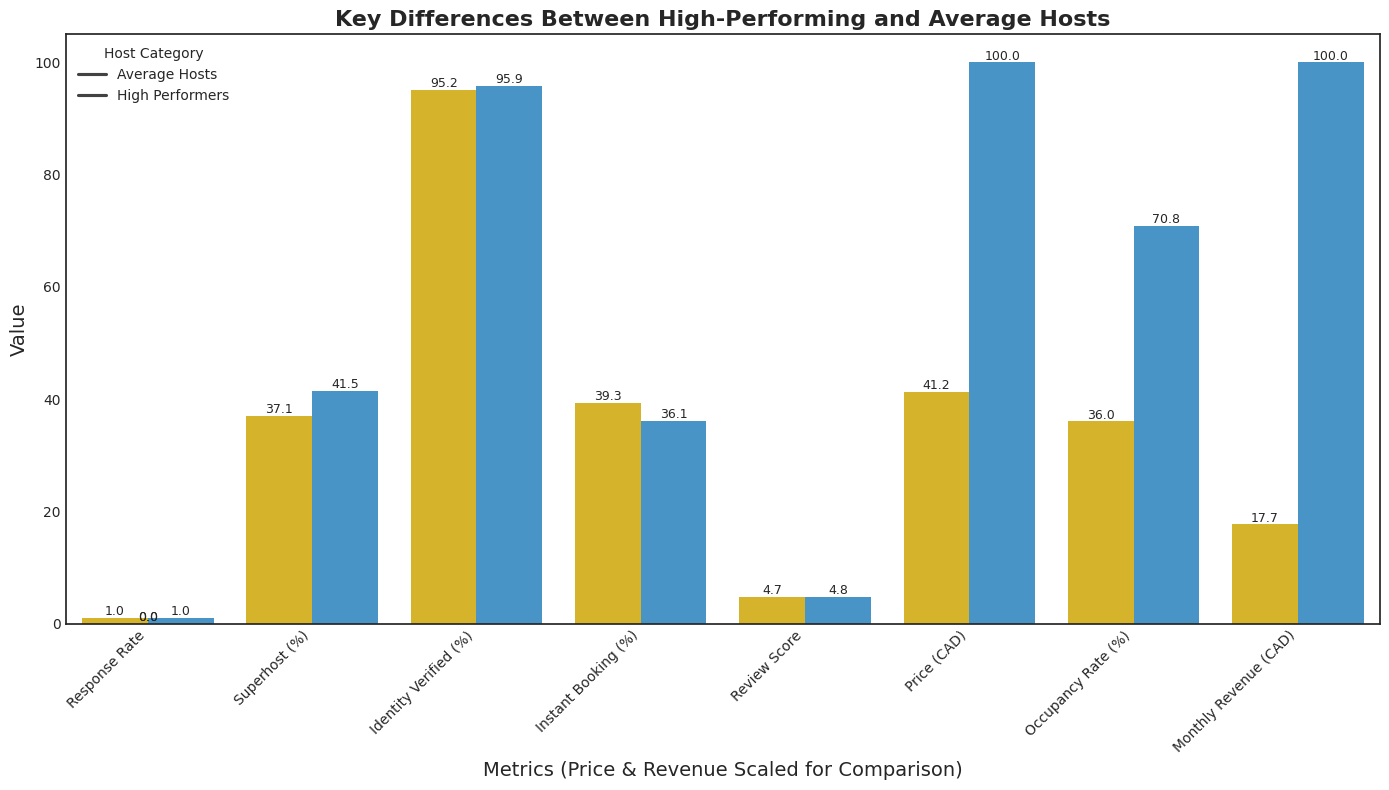

interactive(children=(Dropdown(description='Select Metric:', layout=Layout(width='50%'), options=(('Host Respo…

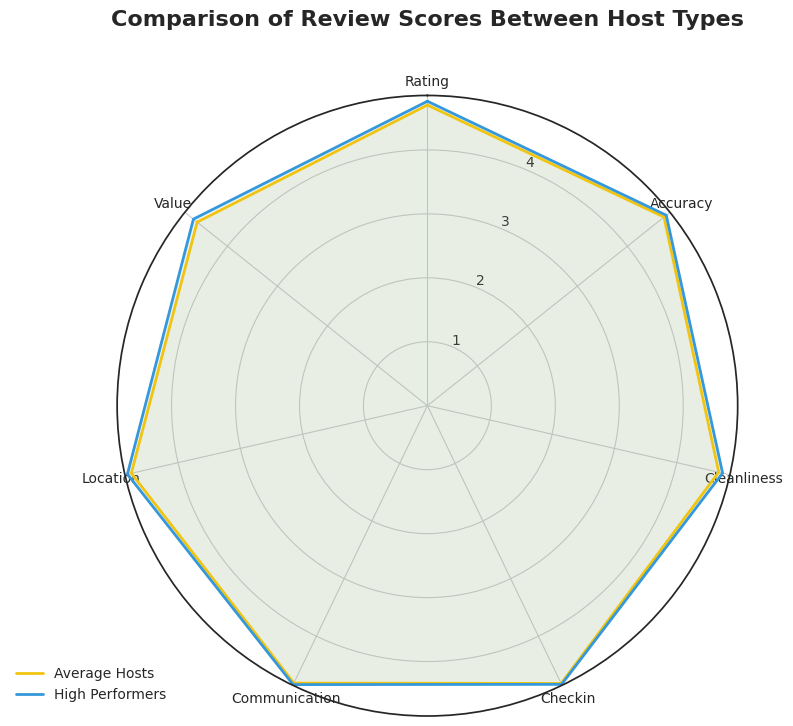

In [ ]:
# Host Performance Analysis
# This section analyzes the characteristics that distinguish high-performing hosts
# from average hosts in the Montreal Airbnb market

# Define high-performing hosts (top 20% by monthly revenue)
revenue_threshold = listings_detailed['estimated_monthly_revenue'].quantile(0.8)
listings_detailed['high_performer'] = listings_detailed['estimated_monthly_revenue'] >= revenue_threshold

# Group by high_performer flag and calculate mean metrics
host_comparison = listings_detailed.groupby('high_performer').agg({
    'host_response_rate_num': 'mean',
    'host_acceptance_rate_num': 'mean',
    'host_is_superhost_num': 'mean',
    'host_listings_count': 'mean',
    'host_identity_verified_num': 'mean',
    'instant_bookable_num': 'mean',
    'review_scores_rating': 'mean',
    'review_scores_accuracy': 'mean',
    'review_scores_cleanliness': 'mean',
    'review_scores_checkin': 'mean',
    'review_scores_communication': 'mean',
    'review_scores_location': 'mean',
    'review_scores_value': 'mean',
    'bedrooms': 'mean',
    'price': 'mean',
    'occupancy_rate': 'mean',
    'estimated_monthly_revenue': 'mean'
}).reset_index()

# Convert binary metrics to percentages for better readability
percentage_cols = ['host_is_superhost_num', 'host_identity_verified_num', 'instant_bookable_num']
for col in percentage_cols:
    host_comparison[col] = host_comparison[col] * 100

# Create a formatted table for display
display_comparison = host_comparison.copy()
display_comparison['host_response_rate_num'] = display_comparison['host_response_rate_num'].apply(lambda x: f'{x*100:.1f}%')
display_comparison['host_acceptance_rate_num'] = display_comparison['host_acceptance_rate_num'].apply(lambda x: f'{x*100:.1f}%')
display_comparison['host_is_superhost_num'] = display_comparison['host_is_superhost_num'].apply(lambda x: f'{x:.1f}%')
display_comparison['host_identity_verified_num'] = display_comparison['host_identity_verified_num'].apply(lambda x: f'{x:.1f}%')
display_comparison['instant_bookable_num'] = display_comparison['instant_bookable_num'].apply(lambda x: f'{x:.1f}%')

# Round numeric values for better display
for col in ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
           'review_scores_value']:
    display_comparison[col] = display_comparison[col].round(2)

display_comparison['bedrooms'] = display_comparison['bedrooms'].round(1)
display_comparison['price'] = display_comparison['price'].round(2).apply(lambda x: f'${x:.2f}')
display_comparison['occupancy_rate'] = display_comparison['occupancy_rate'].round(1).apply(lambda x: f'{x}%')
display_comparison['estimated_monthly_revenue'] = display_comparison['estimated_monthly_revenue'].round(2).apply(lambda x: f'${x:.2f}')

# Rename columns for better readability
display_comparison = display_comparison.rename(columns={
    'high_performer': 'Host Category',
    'host_response_rate_num': 'Response Rate',
    'host_acceptance_rate_num': 'Acceptance Rate',
    'host_is_superhost_num': 'Superhost',
    'host_listings_count': 'Listings Count',
    'host_identity_verified_num': 'Identity Verified',
    'instant_bookable_num': 'Instant Booking',
    'review_scores_rating': 'Overall Rating',
    'review_scores_accuracy': 'Accuracy Rating',
    'review_scores_cleanliness': 'Cleanliness Rating',
    'review_scores_checkin': 'Check-in Rating',
    'review_scores_communication': 'Communication Rating',
    'review_scores_location': 'Location Rating',
    'review_scores_value': 'Value Rating',
    'bedrooms': 'Bedrooms',
    'price': 'Price',
    'occupancy_rate': 'Occupancy Rate',
    'estimated_monthly_revenue': 'Monthly Revenue'
})

# Map boolean values to readable text
display_comparison['Host Category'] = display_comparison['Host Category'].map({False: 'Average Hosts', True: 'High Performers'})

# Display the comparison table
display(HTML("<h3>High-Performing vs. Average Hosts Comparison</h3>"))
display_comparison = display_comparison.set_index('Host Category')
display(display_comparison)

# Prepare data for visualization - focus on key metrics
metrics_to_visualize = [
    'host_response_rate_num', 'host_is_superhost_num', 'host_identity_verified_num',
    'instant_bookable_num', 'review_scores_rating', 'price',
    'occupancy_rate', 'estimated_monthly_revenue'
]

# Create a more readable version of the metrics for the plot
viz_data = pd.melt(
    host_comparison,
    id_vars=['high_performer'],
    value_vars=metrics_to_visualize,
    var_name='metric',
    value_name='value'
)

# Rename metrics for better readability in the plot
metric_labels = {
    'host_response_rate_num': 'Response Rate',
    'host_is_superhost_num': 'Superhost (%)',
    'host_identity_verified_num': 'Identity Verified (%)',
    'instant_bookable_num': 'Instant Booking (%)',
    'review_scores_rating': 'Review Score',
    'price': 'Price (CAD)',
    'occupancy_rate': 'Occupancy Rate (%)',
    'estimated_monthly_revenue': 'Monthly Revenue (CAD)'
}
viz_data['metric'] = viz_data['metric'].map(metric_labels)

# For visualization purposes, normalize 'estimated_monthly_revenue' and 'price'
# to be on a similar scale as the other metrics
max_revenue = viz_data.loc[viz_data['metric'] == 'Monthly Revenue (CAD)', 'value'].max()
viz_data.loc[viz_data['metric'] == 'Monthly Revenue (CAD)', 'value'] = \
    viz_data.loc[viz_data['metric'] == 'Monthly Revenue (CAD)', 'value'] / (max_revenue/100)

max_price = viz_data.loc[viz_data['metric'] == 'Price (CAD)', 'value'].max()
viz_data.loc[viz_data['metric'] == 'Price (CAD)', 'value'] = \
    viz_data.loc[viz_data['metric'] == 'Price (CAD)', 'value'] / (max_price/100)

# Create an enhanced grouped bar chart
plt.figure(figsize=(14, 8))
chart = sns.barplot(
    data=viz_data,
    x='metric',
    y='value',
    hue='high_performer',
    palette=['#f1c40f', '#3498db']
)

# Add value labels on top of each bar
for i, bar in enumerate(chart.patches):
    height = bar.get_height()
    chart.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.5,
        f"{height:.1f}",
        ha='center',
        fontsize=9
    )

# Format the chart for professional presentation
plt.title('Key Differences Between High-Performing and Average Hosts', fontsize=16, fontweight='bold')
plt.xlabel('Metrics (Price & Revenue Scaled for Comparison)', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Host Category', labels=['Average Hosts', 'High Performers'])
plt.grid(False)
plt.tight_layout()
plt.show()

#display(HTML(key_insights))

# Create interactive widget to compare host characteristics
def explore_host_metric(metric):
    # Get the data for the selected metric
    if metric in host_comparison.columns:
        metric_data = host_comparison[['high_performer', metric]].copy()

        # Convert high_performer to readable labels
        metric_data['high_performer'] = metric_data['high_performer'].map({False: 'Average Hosts', True: 'High Performers'})

        # Create a bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.bar(
            metric_data['high_performer'],
            metric_data[metric],
            color=['#f1c40f', '#3498db'],
            width=0.6
        )

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if 'rate' in metric.lower() and 'num' in metric.lower():
                # Format as percentage for rate fields with _num suffix
                plt.text(
                    bar.get_x() + bar.get_width()/2.,
                    height + 0.02,
                    f"{height*100:.1f}%",
                    ha='center',
                    va='bottom',
                    fontsize=12
                )
            elif 'price' in metric.lower() or 'revenue' in metric.lower():
                # Format as currency for price/revenue fields
                plt.text(
                    bar.get_x() + bar.get_width()/2.,
                    height + (height * 0.05),
                    f"${height:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=12
                )
            else:
                # Default formatting for other fields
                plt.text(
                    bar.get_x() + bar.get_width()/2.,
                    height + (height * 0.05),
                    f"{height:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=12
                )

        # Format the chart
        plt.title(f'Comparison of {metric.replace("_", " ").title()} Between Host Types', fontsize=16, fontweight='bold')
        plt.ylabel(metric.replace("_", " ").title(), fontsize=14)
        plt.xticks(fontsize=12)
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        # Calculate and display the difference
        avg_value = metric_data[metric].iloc[0]
        high_value = metric_data[metric].iloc[1]
        diff = high_value - avg_value
        diff_percent = (diff / avg_value) * 100 if avg_value > 0 else 0

        print(f"Average hosts: {avg_value:.2f}")
        print(f"High-performing hosts: {high_value:.2f}")
        print(f"Absolute difference: {diff:.2f} ({diff_percent:.1f}%)")
    else:
        print(f"Metric '{metric}' not found in the dataset.")

# Create readable metric names for the dropdown
metric_name_mapping = {
    'host_response_rate_num': 'Host Response Rate',
    'host_acceptance_rate_num': 'Host Acceptance Rate',
    'host_is_superhost_num': 'Superhost Percentage',
    'host_listings_count': 'Number of Listings',
    'host_identity_verified_num': 'Identity Verification',
    'instant_bookable_num': 'Instant Booking',
    'review_scores_rating': 'Overall Rating',
    'review_scores_accuracy': 'Accuracy Rating',
    'review_scores_cleanliness': 'Cleanliness Rating',
    'review_scores_checkin': 'Check-in Rating',
    'review_scores_communication': 'Communication Rating',
    'review_scores_location': 'Location Rating',
    'review_scores_value': 'Value Rating',
    'bedrooms': 'Number of Bedrooms',
    'price': 'Nightly Price',
    'occupancy_rate': 'Occupancy Rate',
    'estimated_monthly_revenue': 'Monthly Revenue'
}

# Create dropdown options in a readable format
metric_options = [(v, k) for k, v in metric_name_mapping.items()]

# Create an interactive dropdown for metric selection
metric_widget = widgets.Dropdown(
    options=metric_options,
    description='Select Metric:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Display widget and bind to function
display(HTML("<h3>Interactive Host Performance Metric Explorer</h3>"))
display(widgets.interactive(explore_host_metric, metric=metric_widget))

# Create a spider/radar chart for review score comparison
# First, extract all review score columns
review_score_cols = [col for col in host_comparison.columns if 'review_scores' in col]
review_scores = host_comparison[['high_performer'] + review_score_cols].copy()
review_scores['high_performer'] = review_scores['high_performer'].map({False: 'Average Hosts', True: 'High Performers'})
review_scores = review_scores.set_index('high_performer')

# Rename columns for better readability
review_scores.columns = [col.replace('review_scores_', '').capitalize() for col in review_scores.columns]

# Create radar chart
# Create a simpler radar chart for review score comparison
# First, extract all review score columns
review_score_cols = [col for col in host_comparison.columns if 'review_scores' in col]
review_scores = host_comparison[['high_performer'] + review_score_cols].copy()
review_scores['high_performer'] = review_scores['high_performer'].map({False: 'Average Hosts', True: 'High Performers'})
review_scores = review_scores.set_index('high_performer')

# Rename columns for better readability
review_scores.columns = [col.replace('review_scores_', '').capitalize() for col in review_scores.columns]

# Create a simpler radar chart using a standard polar plot
def radar_chart(df, title):
    # Number of variables
    categories = list(df.columns)
    N = len(categories)

    # Create angles for each variable
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create figure and polar axis
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Draw one line per value and fill area
    for i, (idx, row) in enumerate(df.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]  # Close the loop

        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=idx, color=['#f1c40f', '#3498db'][i])
        ax.fill(angles, values, alpha=0.1, color=['#f1c40f', '#3498db'][i])

    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Add title
    plt.title(title, fontsize=16, fontweight='bold', y=1.1)

    return fig, ax

# Create the radar chart
fig, ax = radar_chart(review_scores, 'Comparison of Review Scores Between Host Types')
plt.tight_layout()
plt.show()

# 7. Seasonal Variations Analysis

Here we analyze how pricing and occupancy rates vary by season and month to understand seasonal patterns in the Montreal market

<Figure size 1400x800 with 0 Axes>

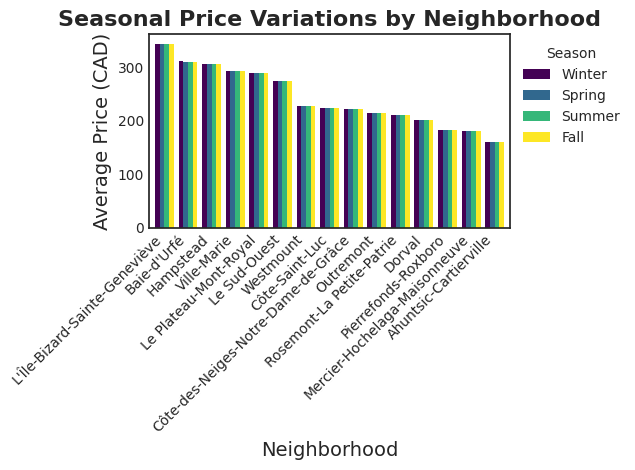

<Figure size 1400x800 with 0 Axes>

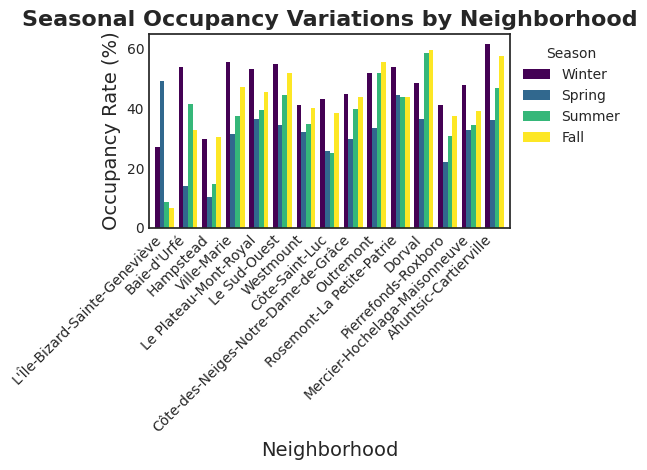

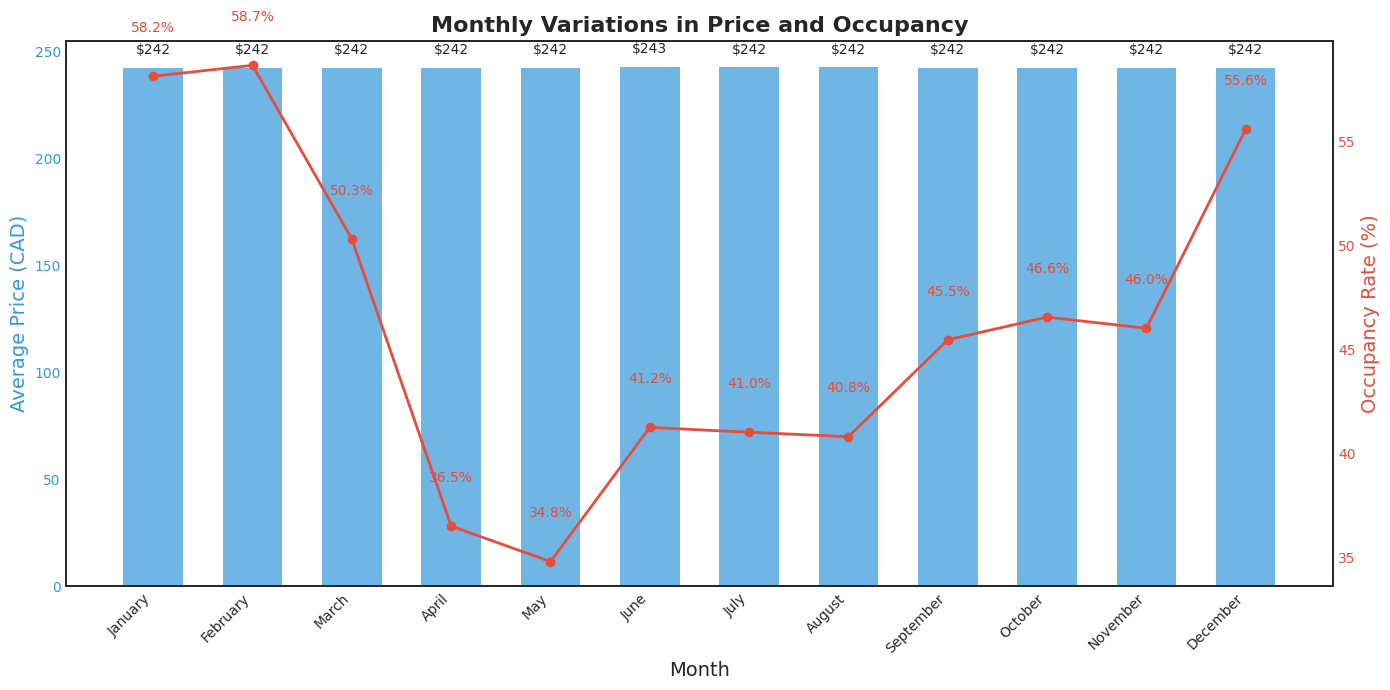

interactive(children=(Dropdown(description='Select Neighborhood:', layout=Layout(width='50%'), options=('Ahunt…

In [ ]:
# Merge calendar data with neighborhood information
calendar_with_neighborhood = calendar.merge(
    listings_detailed[['id', 'neighbourhood_cleansed']],
    left_on='listing_id',
    right_on='id',
    how='left'
)

# Group by neighborhood and season to calculate seasonal metrics
seasonal_metrics = calendar_with_neighborhood.groupby(['neighbourhood_cleansed', 'season']).agg(
    avg_price=('price', 'mean'),
    occupancy_rate=('available', lambda x: (~x).mean()*100)
).reset_index()

# Create pivot tables for visualization
price_pivot = seasonal_metrics.pivot(index='neighbourhood_cleansed', columns='season', values='avg_price')
occupancy_pivot = seasonal_metrics.pivot(index='neighbourhood_cleansed', columns='season', values='occupancy_rate')

# Get top 15 neighborhoods by average price
top_price_neighborhoods = price_pivot.mean(axis=1).sort_values(ascending=False).head(15).index

# Create a seasonal price variation chart with improved styling
plt.figure(figsize=(14, 8))
ax = price_pivot.loc[top_price_neighborhoods].plot(
    kind='bar',
    width=0.8,
    colormap='viridis'
)

# Format the chart for professional presentation
plt.title('Seasonal Price Variations by Neighborhood', fontsize=16, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('Average Price (CAD)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Season', loc='upper left',  bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.grid(False)  # Remove grid as requested
plt.show()

# Create a seasonal occupancy variation chart
plt.figure(figsize=(14, 8))
ax = occupancy_pivot.loc[top_price_neighborhoods].plot(
    kind='bar',
    width=0.8,
    colormap='viridis'
)

# Format the chart for professional presentation
plt.title('Seasonal Occupancy Variations by Neighborhood', fontsize=16, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('Occupancy Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Season', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.grid(False)  # Remove grid as requested
plt.show()

# Create monthly trends analysis
monthly_trends = calendar.groupby('month_name').agg(
    avg_price=('price', 'mean'),
    occupancy_rate=('available', lambda x: (~x).mean()*100)
).reset_index()

# Set proper month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
monthly_trends['month_name'] = pd.Categorical(
    monthly_trends['month_name'],
    categories=month_order,
    ordered=True
)
monthly_trends = monthly_trends.sort_values('month_name')

# Create a dual-axis chart for monthly price and occupancy
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot price bars
bars = ax1.bar(
    monthly_trends['month_name'],
    monthly_trends['avg_price'],
    color='#3498db',
    alpha=0.7,
    width=0.6
)

# Add price labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2.,
        height + 5,
        f'${height:.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Set up the primary axis labels
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Average Price (CAD)', fontsize=14, color='#3498db')
ax1.tick_params(axis='y', labelcolor='#3498db')
ax1.set_xticklabels(monthly_trends['month_name'], rotation=45, ha='right')

# Create the second axis for occupancy rate
ax2 = ax1.twinx()
ax2.plot(
    monthly_trends['month_name'],
    monthly_trends['occupancy_rate'],
    'r-o',
    linewidth=2,
    color='#e74c3c'
)

# Add occupancy rate data points
for i, val in enumerate(monthly_trends['occupancy_rate']):
    ax2.text(
        i,
        val + 2,
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        color='#e74c3c',
        fontsize=10
    )

# Set up the secondary axis labels
ax2.set_ylabel('Occupancy Rate (%)', fontsize=14, color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

# Add overall formatting
plt.title('Monthly Variations in Price and Occupancy', fontsize=16, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

# Create an interactive widget to explore seasonal trends by neighborhood
def plot_seasonal_trends(neighborhood):
    # Get data for the selected neighborhood
    if neighborhood in price_pivot.index:
        seasonal_prices = price_pivot.loc[neighborhood]
        seasonal_occupancy = occupancy_pivot.loc[neighborhood]

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        # Plot seasonal prices
        seasonal_prices.plot(kind='bar', ax=ax1, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
        ax1.set_title(f'Seasonal Price Variations in {neighborhood}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Average Price (CAD)', fontsize=12)
        ax1.set_xticklabels(seasonal_prices.index, rotation=0)
        ax1.grid(False)

        # Add price labels
        for i, price in enumerate(seasonal_prices):
            ax1.text(i, price + 5, f'${price:.0f}', ha='center', va='bottom', fontsize=10)

        # Plot seasonal occupancy
        seasonal_occupancy.plot(kind='bar', ax=ax2, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
        ax2.set_title(f'Seasonal Occupancy Rates in {neighborhood}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Occupancy Rate (%)', fontsize=12)
        ax2.set_xticklabels(seasonal_occupancy.index, rotation=0)
        ax2.grid(False)

        # Add occupancy labels
        for i, occ in enumerate(seasonal_occupancy):
            ax2.text(i, occ + 2, f'{occ:.1f}%', ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Neighborhood '{neighborhood}' not found in the dataset.")

# Create an interactive dropdown for neighborhood selection
import ipywidgets as widgets
from IPython.display import display, HTML

# Only show the widget if there are enough neighborhoods to make it useful
if len(price_pivot.index) > 1:
    neighborhood_widget = widgets.Dropdown(
        options=sorted(price_pivot.index),
        description='Select Neighborhood:',
        style={'description_width': 'initial'},
        layout={'width': '50%'}
    )

    # Display widget and bind to function
    display(HTML("<h3>Interactive Seasonal Analysis by Neighborhood</h3>"))
    display(widgets.interactive(plot_seasonal_trends, neighborhood=neighborhood_widget))

# 7.1 Monthly Trend Analysis

Monthly data check:
   month_name   avg_price  occupancy_rate   count
0       April  242.168809       36.497135  293160
1      August  242.402346       40.798595  302932
2    December  242.307041       55.594985  302932
3    February  242.307041       58.675662  273616
4     January  242.307041       58.151664  302932
5        July  242.390033       41.015145  302932
6        June  242.816957       41.244713  293160
7       March  242.155062       50.314830  305244
8         May  242.329557       34.786685  302932
9    November  242.355611       46.019921  293160
10    October  242.357286       46.554342  302932
11  September  242.357286       45.461523  293160


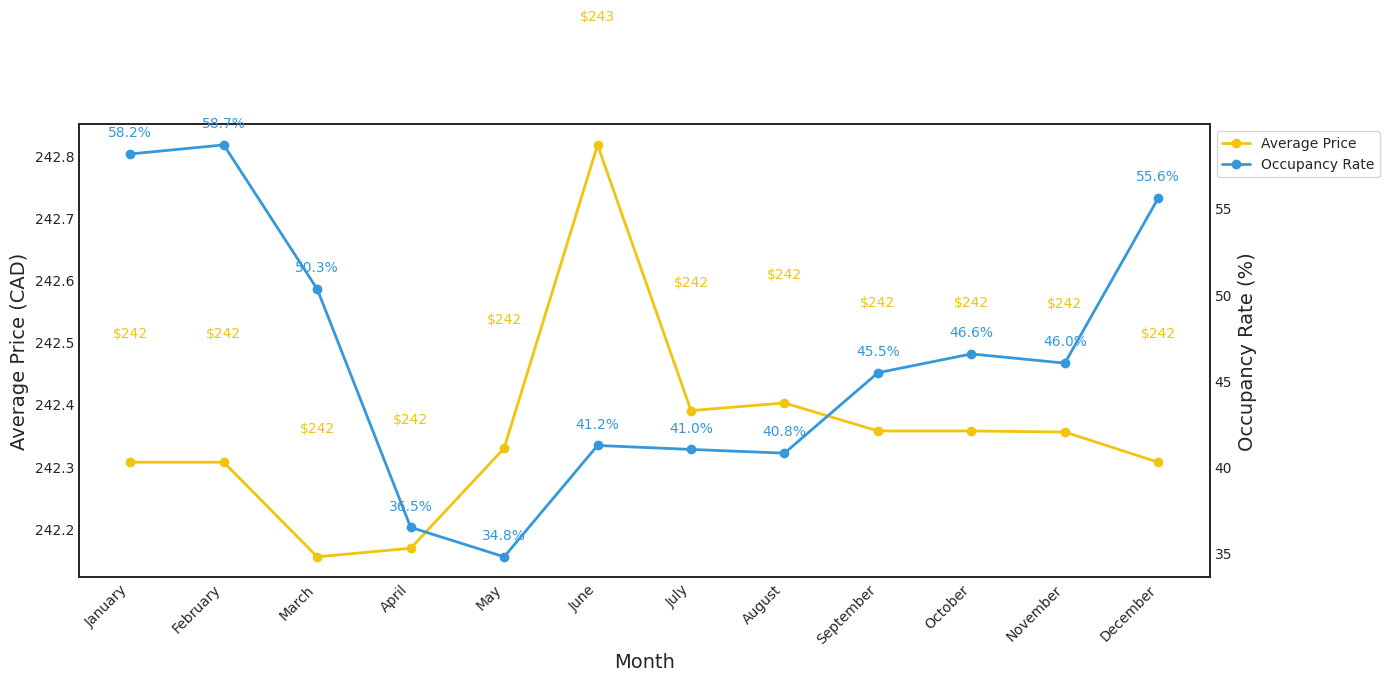

In [ ]:
# Create monthly trends analysis
monthly_trends = calendar.groupby('month_name').agg(
    avg_price=('price', 'mean'),
    occupancy_rate=('available', lambda x: (~x).mean() * 100),
    count=('listing_id', 'count')  # Add count to validate data volume
).reset_index()

# Print the data to verify values
print("Monthly data check:")
print(monthly_trends)

# Set proper month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_trends['month_name'] = pd.Categorical(
    monthly_trends['month_name'],
    categories=month_order,
    ordered=True
)
monthly_trends = monthly_trends.sort_values('month_name')

# Create a dual-axis chart for monthly price and occupancy with TWO LINES
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot price line
price_line = ax1.plot(
    monthly_trends['month_name'],
    monthly_trends['avg_price'],
    'o-',  # Line with markers
    color='#f1c40f',  # Yellow/gold line for price
    linewidth=2,
    label='Average Price'
)

# Add price labels
for i, val in enumerate(monthly_trends['avg_price']):
    ax1.text(
        i,
        val + 0.2,  # Adjust positioning slightly
        f'${val:.0f}',
        ha='center',
        color='#f1c40f',
        fontsize=10
    )

# Set up the primary axis labels
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Average Price (CAD)', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_xticklabels(monthly_trends['month_name'], rotation=45, ha='right')

# Create the second axis for occupancy rate
ax2 = ax1.twinx()
occupancy_line = ax2.plot(
    monthly_trends['month_name'],
    monthly_trends['occupancy_rate'],
    'o-',  # Line with markers
    linewidth=2,
    color='#3498db',  # Blue line for occupancy
    label='Occupancy Rate'
)

# Add occupancy rate data points
for i, val in enumerate(monthly_trends['occupancy_rate']):
    ax2.text(
        i,
        val + 1,  # Adjust positioning slightly
        f'{val:.1f}%',
        ha='center',
        color='#3498db',
        fontsize=10
    )

# Set up the secondary axis labels
ax2.set_ylabel('Occupancy Rate (%)', fontsize=14)
ax2.tick_params(axis='y')

# Adjust legend position with bbox_to_anchor
lines = price_line + occupancy_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=True)

# Remove grid lines
ax1.grid(False)
ax2.grid(False)

# Remove extra whitespace
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.tight_layout()

# Show plot
plt.show()

#7.2 Monthly price and Occupancy Trends - *Outliers vs All data*

Calendar Data Sample:
  listing_id       date  available  price
0      29059 2025-03-07       True  159.0
1      29059 2025-03-08       True  159.0
2      29059 2025-03-09       True  159.0
3      29059 2025-03-10       True  159.0
4      29059 2025-03-11       True  159.0

Calendar shape: (3569092, 10)
Price data type: float64

Price statistics:
count    3.569092e+06
mean     2.423540e+02
std      6.101913e+02
min      1.500000e+01
25%      8.000000e+01
50%      1.230000e+02
75%      2.000000e+02
max      1.550000e+04
Name: price, dtype: float64

Number of extreme price outliers: 203678
Percentage of outliers: 5.71%
Sample of outliers:
     listing_id  price
3285     850970  613.0
3286     850970  613.0
3287     850970  613.0
3288     850970  613.0
3289     850970  613.0

Number of records after removing outliers: 3365414

Calculating monthly trends...

Monthly trends with ALL data:
   month_name   avg_price  median_price  occupancy_rate   count
4     January  242.307041         123.0

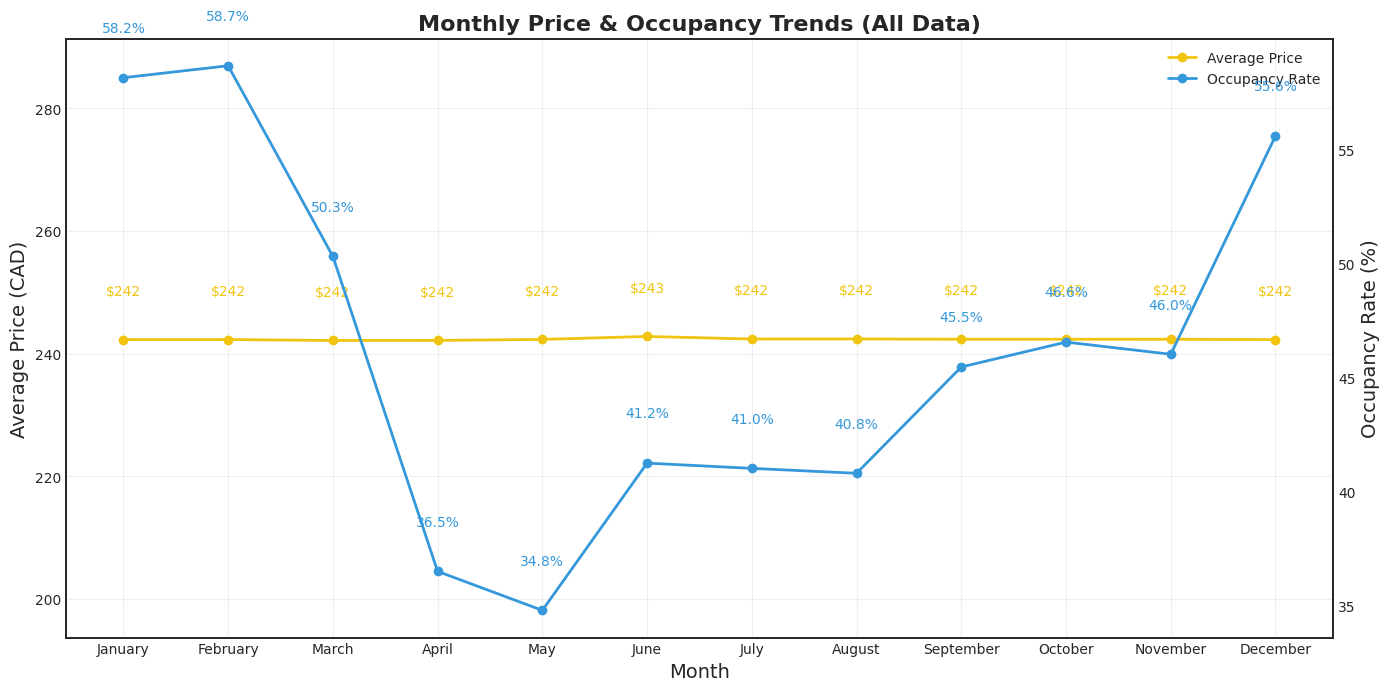

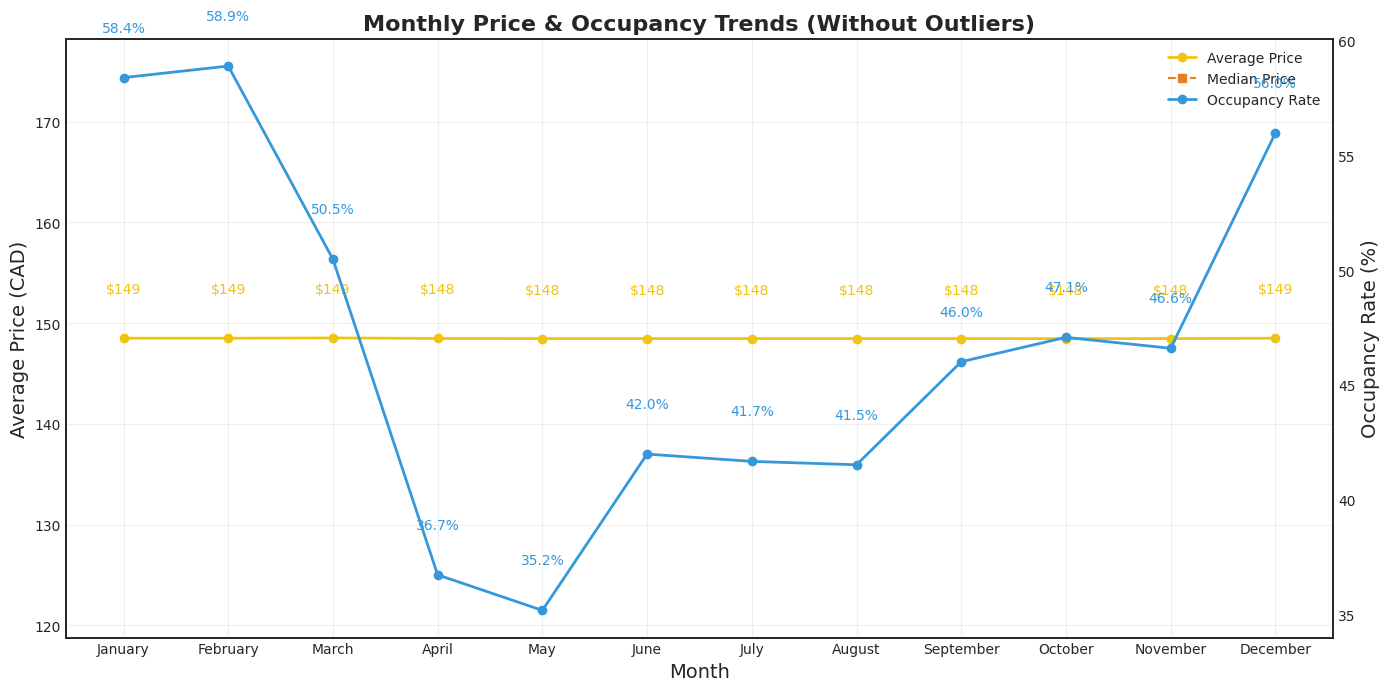


Summary statistics:
Average price across all months (all data): $242.35
Average price across all months (filtered data): $148.48
Average occupancy rate (all data): 46.26%


In [ ]:
# Data validation and enhanced monthly trends visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming calendar and listings_detailed are already loaded
# Let's first examine the calendar data structure and price values

# 1. Check calendar data type and sample values
print("Calendar Data Sample:")
print(calendar[['listing_id', 'date', 'available', 'price']].head())
print(f"\nCalendar shape: {calendar.shape}")
print(f"Price data type: {calendar['price'].dtype}")

# 2. Check for any price formatting issues
# If price is still a string (which would be unusual at this point), convert it
if calendar['price'].dtype == 'object':
    print("Converting price from string to numeric...")
    calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
    print(f"Price data type after conversion: {calendar['price'].dtype}")

# 3. Basic statistics on price to identify any outliers
print("\nPrice statistics:")
print(calendar['price'].describe())

# 4. Check if any extreme outliers might be skewing the average
q1 = calendar['price'].quantile(0.25)
q3 = calendar['price'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 3 * iqr  # Using 3*IQR for extreme outliers
outliers = calendar[calendar['price'] > upper_bound]
print(f"\nNumber of extreme price outliers: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers) / len(calendar)) * 100:.2f}%")
if len(outliers) > 0:
    print("Sample of outliers:")
    print(outliers[['listing_id', 'price']].head())

# 5. Create a version without extreme outliers for comparison
calendar_filtered = calendar[calendar['price'] <= upper_bound].copy()
print(f"\nNumber of records after removing outliers: {len(calendar_filtered)}")

# 6. Calculate monthly trends both with and without outliers
print("\nCalculating monthly trends...")

# With all data
monthly_trends_all = calendar.groupby('month_name').agg(
    avg_price=('price', 'mean'),
    median_price=('price', 'median'),  # Add median as it's less affected by outliers
    occupancy_rate=('available', lambda x: (~x).mean()*100),
    count=('listing_id', 'count')
).reset_index()

# Without outliers
monthly_trends_filtered = calendar_filtered.groupby('month_name').agg(
    avg_price=('price', 'mean'),
    median_price=('price', 'median'),
    occupancy_rate=('available', lambda x: (~x).mean()*100),
    count=('listing_id', 'count')
).reset_index()

# 7. Set proper month order for both
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']

for df in [monthly_trends_all, monthly_trends_filtered]:
    df['month_name'] = pd.Categorical(
        df['month_name'],
        categories=month_order,
        ordered=True
    )
    df.sort_values('month_name', inplace=True)

# 8. Print both datasets for comparison
print("\nMonthly trends with ALL data:")
print(monthly_trends_all)

print("\nMonthly trends WITHOUT outliers:")
print(monthly_trends_filtered)

# 9. Create improved visualizations for both datasets
def plot_monthly_trends(data, title, include_median=False):
    """Create a dual-axis plot for monthly price and occupancy trends."""
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot average price line
    price_line = ax1.plot(
        data['month_name'],
        data['avg_price'],
        'o-',
        color='#f1c40f',  # Gold
        linewidth=2,
        label='Average Price'
    )

    # Add median price line if requested
    if include_median:
        median_line = ax1.plot(
            data['month_name'],
            data['median_price'],
            's--',
            color='#e67e22',  # Orange
            linewidth=1.5,
            label='Median Price'
        )

    # Add price labels
    for i, val in enumerate(data['avg_price']):
        ax1.text(
            i,
            val + (val * 0.03),  # Position 3% above the point
            f'${val:.0f}',
            ha='center',
            color='#f1c40f',
            fontsize=10
        )

    # Set up the primary axis labels
    ax1.set_xlabel('Month', fontsize=14)
    ax1.set_ylabel('Average Price (CAD)', fontsize=14)
    ax1.tick_params(axis='y')

    # Ensure y-axis has reasonable range
    min_price = data['avg_price'].min() * 0.8  # Extend 20% below min
    max_price = data['avg_price'].max() * 1.2  # Extend 20% above max
    ax1.set_ylim([min_price, max_price])

    # Create the second axis for occupancy rate
    ax2 = ax1.twinx()
    occupancy_line = ax2.plot(
        data['month_name'],
        data['occupancy_rate'],
        'o-',
        linewidth=2,
        color='#3498db',  # Blue
        label='Occupancy Rate'
    )

    # Add occupancy rate data points
    for i, val in enumerate(data['occupancy_rate']):
        ax2.text(
            i,
            val + 2,
            f'{val:.1f}%',
            ha='center',
            color='#3498db',
            fontsize=10
        )

    # Set up the secondary axis labels
    ax2.set_ylabel('Occupancy Rate (%)', fontsize=14)
    ax2.tick_params(axis='y')

    # Add legend
    lines = price_line
    labels = ['Average Price']

    if include_median:
        lines += median_line
        labels.append('Median Price')

    lines += occupancy_line
    labels.append('Occupancy Rate')

    ax1.legend(lines, labels, loc='upper right')

    # Add grid for readability
    ax1.grid(True, alpha=0.3)

    # Add overall formatting
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 10. Create the plots
plot_monthly_trends(monthly_trends_all, 'Monthly Price & Occupancy Trends (All Data)')
plot_monthly_trends(monthly_trends_filtered, 'Monthly Price & Occupancy Trends (Without Outliers)', include_median=True)

# 11. Print summary statistics for verification
print("\nSummary statistics:")
print(f"Average price across all months (all data): ${monthly_trends_all['avg_price'].mean():.2f}")
print(f"Average price across all months (filtered data): ${monthly_trends_filtered['avg_price'].mean():.2f}")
print(f"Average occupancy rate (all data): {monthly_trends_all['occupancy_rate'].mean():.2f}%")

# 7.3 Outlier Identification and Analysis


===== OUTLIER ANALYSIS =====

Sample of 10 highest-priced outlier properties:
                 listing_id    price neighbourhood_cleansed  \
126335  1129952791664459138  15500.0            Ville-Marie   
126343  1129952791664459138  15500.0            Ville-Marie   
126342  1129952791664459138  15500.0            Ville-Marie   
126341  1129952791664459138  15500.0            Ville-Marie   
126340  1129952791664459138  15500.0            Ville-Marie   
126339  1129952791664459138  15500.0            Ville-Marie   
126338  1129952791664459138  15500.0            Ville-Marie   
126337  1129952791664459138  15500.0            Ville-Marie   
126336  1129952791664459138  15500.0            Ville-Marie   
203419               190003  13294.0  Le Plateau-Mont-Royal   

                      property_type  bedrooms  \
126335                       Castle       9.0   
126343                       Castle       9.0   
126342                       Castle       9.0   
126341                       Ca

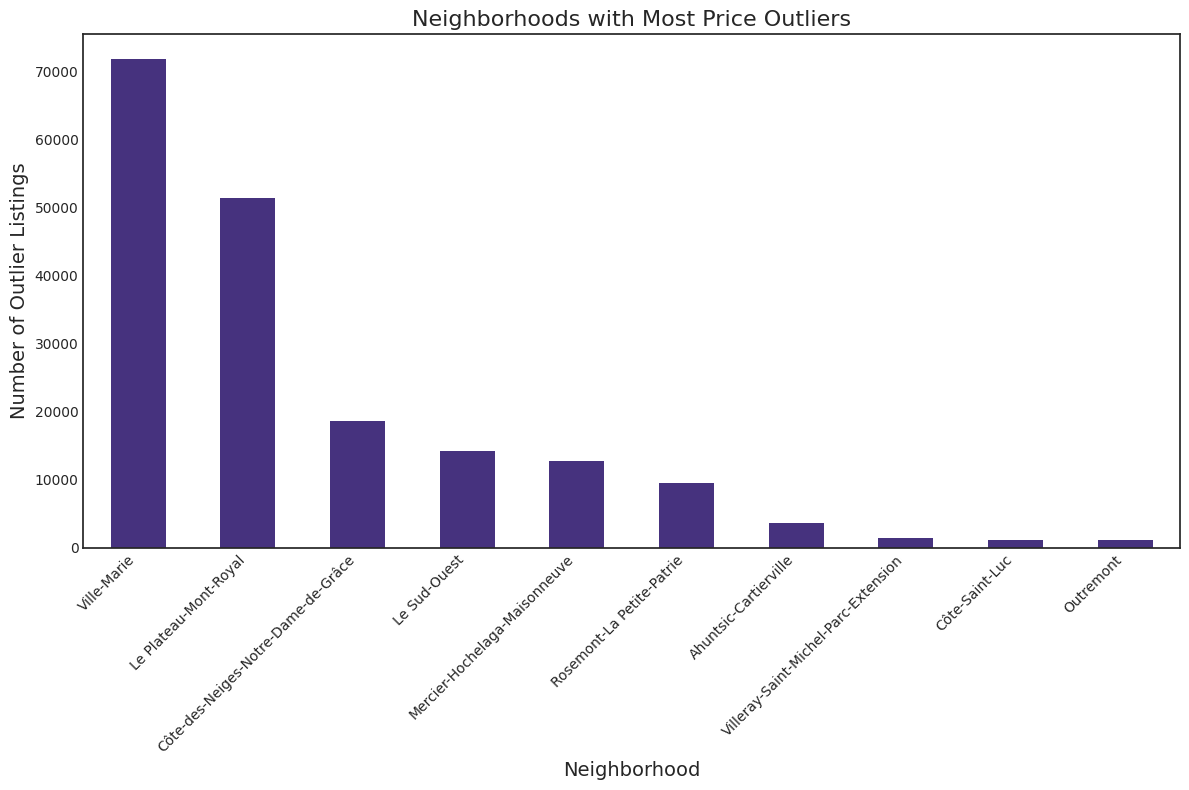

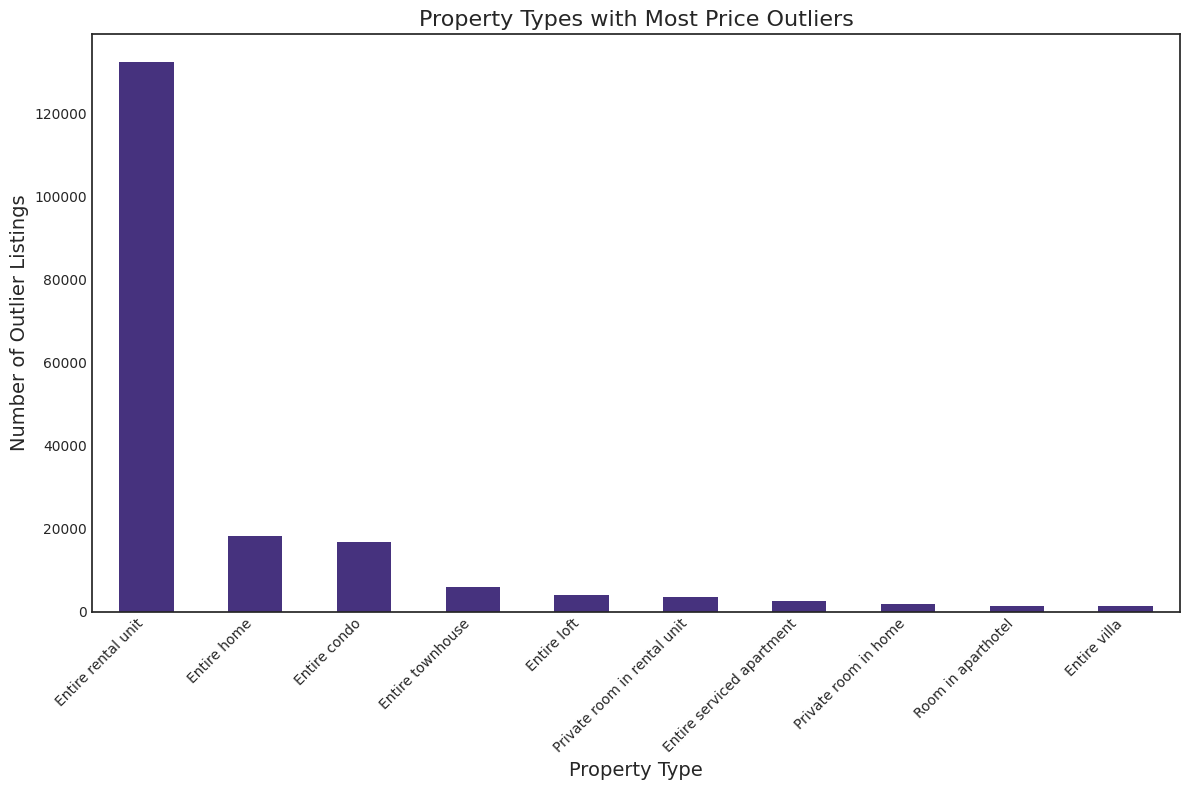

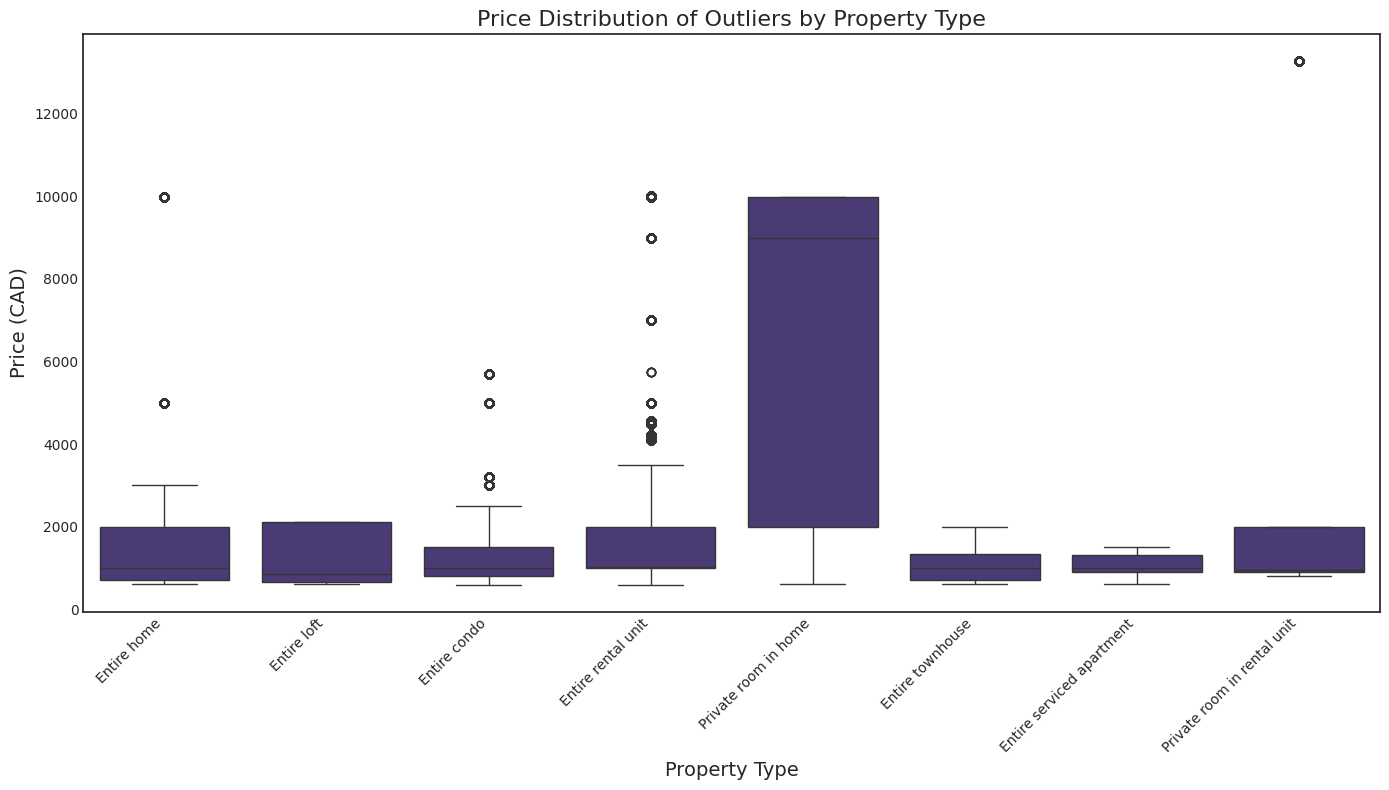

In [ ]:
# Identify outliers and their patterns
if len(outliers) > 0:
    print("\n===== OUTLIER ANALYSIS =====")

    # Merge outliers with property details to get neighborhood and property type
    outlier_properties = outliers.merge(
        listings_detailed[['id', 'neighbourhood_cleansed', 'property_type', 'bedrooms', 'name']],
        left_on='listing_id',
        right_on='id',
        how='left'
    )

    # Print sample of outlier properties
    print("\nSample of 10 highest-priced outlier properties:")
    sample_columns = ['listing_id', 'price', 'neighbourhood_cleansed', 'property_type', 'bedrooms', 'name']
    print(outlier_properties.sort_values('price', ascending=False)[sample_columns].head(10))

    # Neighborhood distribution of outliers
    print("\nTop 10 neighborhoods with most outliers:")
    neighborhood_outliers = outlier_properties['neighbourhood_cleansed'].value_counts().head(10)
    print(neighborhood_outliers)

    # Property type distribution of outliers
    print("\nTop 10 property types with most outliers:")
    property_outliers = outlier_properties['property_type'].value_counts().head(10)
    print(property_outliers)

    # Calculate what percentage of each neighborhood's listings are outliers
    neighborhood_total = listings_detailed['neighbourhood_cleansed'].value_counts()
    neighborhood_outlier_count = outlier_properties['neighbourhood_cleansed'].value_counts()

    # Create a DataFrame for percentage calculation
    neighborhood_percentage = pd.DataFrame({
        'total_listings': neighborhood_total,
        'outlier_count': neighborhood_outlier_count
    }).fillna(0)

    neighborhood_percentage['outlier_percentage'] = (neighborhood_percentage['outlier_count'] /
                                                     neighborhood_percentage['total_listings'] * 100)

    print("\nNeighborhoods with highest percentage of outliers:")
    print(neighborhood_percentage.sort_values('outlier_percentage', ascending=False).head(10))

    # Calculate average price of outliers by neighborhood
    print("\nAverage price of outliers by neighborhood:")
    neighborhood_avg_price = outlier_properties.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
    print(neighborhood_avg_price.head(10))

    # Calculate average price of outliers by property type
    print("\nAverage price of outliers by property type:")
    property_avg_price = outlier_properties.groupby('property_type')['price'].mean().sort_values(ascending=False)
    print(property_avg_price.head(10))

    # Create visualization of outlier distribution by neighborhood
    plt.figure(figsize=(12, 8))
    neighborhood_outliers.head(15).plot(kind='bar')
    plt.title('Neighborhoods with Most Price Outliers', fontsize=16)
    plt.xlabel('Neighborhood', fontsize=14)
    plt.ylabel('Number of Outlier Listings', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Create visualization of outlier distribution by property type
    plt.figure(figsize=(12, 8))
    property_outliers.head(10).plot(kind='bar')
    plt.title('Property Types with Most Price Outliers', fontsize=16)
    plt.xlabel('Property Type', fontsize=14)
    plt.ylabel('Number of Outlier Listings', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Boxplot of prices by property type (limited to top types)
    top_property_types = property_outliers.head(8).index
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        data=outlier_properties[outlier_properties['property_type'].isin(top_property_types)],
        x='property_type',
        y='price'
    )
    plt.title('Price Distribution of Outliers by Property Type', fontsize=16)
    plt.xlabel('Property Type', fontsize=14)
    plt.ylabel('Price (CAD)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 8. Amenities Impact Analysis

This section analyzes how different amenities affect property performance metrics including guest ratings, occupancy rates, and revenue



<Figure size 1200x800 with 0 Axes>

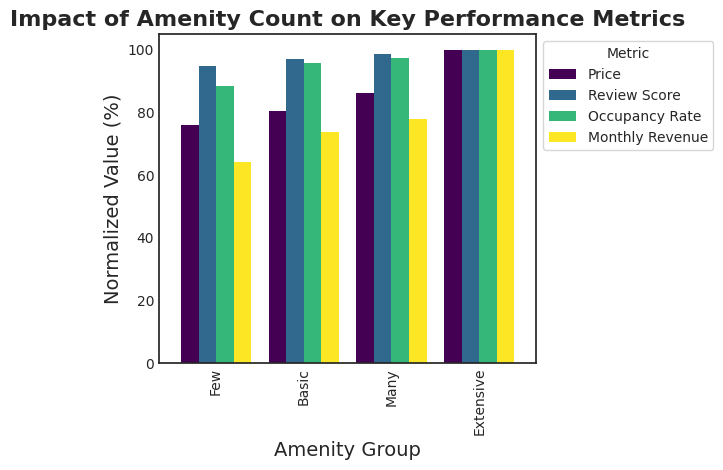

Amenity Group Average Price  Review Score Occupancy Rate Monthly Revenue  \
0           Few       $130.95          4.57          39.9%        $1450.05   
1         Basic       $138.45          4.68          43.3%        $1667.80   
2          Many       $148.21          4.76          44.1%        $1760.59   
3     Extensive       $171.98          4.82          45.1%        $2261.43   

   Number of Listings  
0                2355  
1                2310  
2                2259  
3                2031

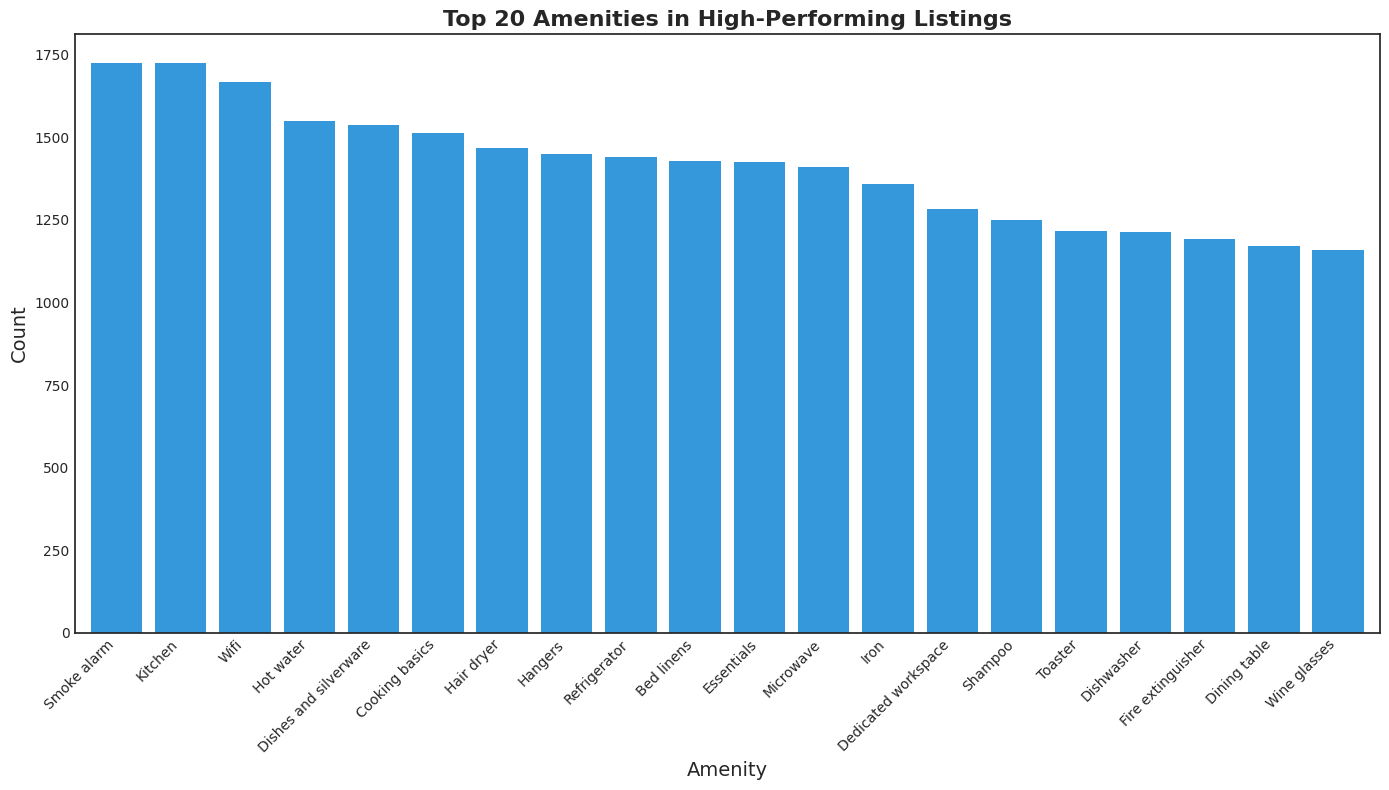

Amenity Revenue With Revenue Without Revenue Difference  \
0             Smoke alarm     $1816.37        $1074.60            $741.77   
19           Wine glasses     $1986.05        $1519.48            $466.57   
14                Shampoo     $1936.79        $1508.62            $428.17   
1                 Kitchen     $1783.07        $1413.33            $369.74   
5          Cooking basics     $1847.43        $1485.52            $361.91   
18           Dining table     $1889.36        $1600.40            $288.95   
13    Dedicated workspace     $1858.06        $1587.08            $270.97   
15                Toaster     $1865.37        $1622.65            $242.71   
4   Dishes and silverware     $1812.15        $1576.95            $235.20   
17      Fire extinguisher     $1860.49        $1638.09            $222.40   

   Percentage Increase Estimated Cost  Monthly ROI  
0                69.0%           $100         7.42  
19               30.7%           $100         4.67  
14               28.4%           $100         4.28  
1                26.2%           $100         3.70  
5                24.4%           $100         3.62  
18               18.1%           $100         2.89  
13               17.1%           $100         2.71  
15               15.0%           $100         2.43  
4                14.9%           $100         2.35  
17               13.6%           $100         2.22

interactive(children=(Dropdown(description='Select Amenity:', layout=Layout(width='50%'), options=('Smoke alar…

In [ ]:
# Create amenity groups based on the number of amenities (quartiles)
listings_detailed['amenity_group'] = pd.qcut(
    listings_detailed['amenity_count'],
    q=4,
    labels=['Few', 'Basic', 'Many', 'Extensive']
)

# Calculate the impact of amenity count on key performance metrics
amenity_impact = listings_detailed.groupby('amenity_group').agg(
    avg_price=('price', 'mean'),
    avg_review_score=('review_scores_rating', 'mean'),
    avg_occupancy=('occupancy_rate', 'mean'),
    avg_monthly_revenue=('estimated_monthly_revenue', 'mean'),
    listing_count=('id', 'count')
).reset_index()

# Normalize metrics for easier comparison in visualization
norm_impact = amenity_impact.copy()
for col in ['avg_price', 'avg_review_score', 'avg_occupancy', 'avg_monthly_revenue']:
    norm_impact[col] = (norm_impact[col] / norm_impact[col].max()) * 100

# Create an enhanced visualization of amenity impact
plt.figure(figsize=(12, 8))
chart = norm_impact.set_index('amenity_group')[
    ['avg_price', 'avg_review_score', 'avg_occupancy', 'avg_monthly_revenue']
].plot(
    kind='bar',
    colormap='viridis',
    width=0.8
)

# Format chart for professional presentation
plt.title('Impact of Amenity Count on Key Performance Metrics', fontsize=16, fontweight='bold')
plt.xlabel('Amenity Group', fontsize=14)
plt.ylabel('Normalized Value (%)', fontsize=14)
plt.legend(
    ['Price', 'Review Score', 'Occupancy Rate', 'Monthly Revenue'],
    title='Metric',
    loc='upper left', bbox_to_anchor=(1.0, 1.0),
    frameon=True
)
plt.grid(False)
plt.tight_layout()
plt.show()

# Display the actual values in a readable format
amenity_table = amenity_impact.copy()
amenity_table['avg_price'] = amenity_table['avg_price'].round(2).apply(lambda x: f'${x:.2f}')
amenity_table['avg_review_score'] = amenity_table['avg_review_score'].round(2)
amenity_table['avg_occupancy'] = amenity_table['avg_occupancy'].round(1).apply(lambda x: f'{x}%')
amenity_table['avg_monthly_revenue'] = amenity_table['avg_monthly_revenue'].round(2).apply(lambda x: f'${x:.2f}')
amenity_table = amenity_table.rename(columns={
    'amenity_group': 'Amenity Group',
    'avg_price': 'Average Price',
    'avg_review_score': 'Review Score',
    'avg_occupancy': 'Occupancy Rate',
    'avg_monthly_revenue': 'Monthly Revenue',
    'listing_count': 'Number of Listings'
})
display(HTML("<h3>Performance Metrics by Amenity Count</h3>"))
display(amenity_table)

# Analyze the top amenities in high-performing listings
high_perf = listings_detailed[listings_detailed['estimated_monthly_revenue'] >= listings_detailed['estimated_monthly_revenue'].quantile(0.8)]
amenities_all = [amen for sublist in high_perf['amenities_list'] for amen in sublist]
amenity_counts = pd.Series(amenities_all).value_counts()

# Visualize the top 20 amenities in high-performing properties
plt.figure(figsize=(14, 8))
chart = amenity_counts.head(20).plot(
    kind='bar',
    color='#3498db',
    width=0.8
)

# Format chart for professional presentation
plt.title('Top 20 Amenities in High-Performing Listings', fontsize=16, fontweight='bold')
plt.xlabel('Amenity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()

# Calculate revenue impact of top amenities
amenity_revenue_impact = []
top_amenities = amenity_counts.head(20).index

for amenity in top_amenities:
    # Clean amenity name for column name
    amenity_col = f"has_{amenity.replace(' ', '_').replace('/', '_').lower()}"

    # Create binary column
    listings_detailed[amenity_col] = listings_detailed['amenities_list'].apply(lambda x: amenity in x)

    # Calculate average revenue with and without this amenity
    with_amenity = listings_detailed[listings_detailed[amenity_col]]['estimated_monthly_revenue'].mean()
    without_amenity = listings_detailed[~listings_detailed[amenity_col]]['estimated_monthly_revenue'].mean()

    # Calculate difference and percentage impact
    diff = with_amenity - without_amenity
    pct_increase = (with_amenity / without_amenity - 1) * 100 if without_amenity > 0 else 0

    # Estimate implementation cost (placeholder - would need real data)
    estimated_cost = 0
    if any(term in amenity.lower() for term in ['tv', 'netflix', 'wifi', 'internet']):
        estimated_cost = 50
    elif any(term in amenity.lower() for term in ['washer', 'dryer', 'dishwasher', 'air conditioning']):
        estimated_cost = 500
    elif any(term in amenity.lower() for term in ['pool', 'hot tub', 'jacuzzi']):
        estimated_cost = 2000
    else:
        estimated_cost = 100

    # Calculate estimated ROI (monthly)
    monthly_roi = diff / estimated_cost if estimated_cost > 0 else 0

    amenity_revenue_impact.append({
        'amenity': amenity,
        'with_amenity': with_amenity,
        'without_amenity': without_amenity,
        'difference': diff,
        'percent_increase': pct_increase,
        'estimated_cost': estimated_cost,
        'monthly_roi': monthly_roi
    })

# Create a DataFrame with the revenue impact data
amenity_impact_df = pd.DataFrame(amenity_revenue_impact).sort_values('monthly_roi', ascending=False)

# Format for display
display_impact = amenity_impact_df.copy()
display_impact['with_amenity'] = display_impact['with_amenity'].round(2).apply(lambda x: f'${x:.2f}')
display_impact['without_amenity'] = display_impact['without_amenity'].round(2).apply(lambda x: f'${x:.2f}')
display_impact['difference'] = display_impact['difference'].round(2).apply(lambda x: f'${x:.2f}')
display_impact['percent_increase'] = display_impact['percent_increase'].round(1).apply(lambda x: f'{x}%')
display_impact['estimated_cost'] = display_impact['estimated_cost'].apply(lambda x: f'${x:.0f}')
display_impact['monthly_roi'] = display_impact['monthly_roi'].round(2)
display_impact = display_impact.rename(columns={
    'amenity': 'Amenity',
    'with_amenity': 'Revenue With',
    'without_amenity': 'Revenue Without',
    'difference': 'Revenue Difference',
    'percent_increase': 'Percentage Increase',
    'estimated_cost': 'Estimated Cost',
    'monthly_roi': 'Monthly ROI'
})

# Display the top amenities by ROI
display(HTML("<h3>Top Amenities by Return on Investment</h3>"))
display(display_impact.head(10))

# Create an interactive widget to explore amenity impact
def show_amenity_impact(amenity_name):
    if amenity_name in top_amenities:
        # Get the row from the impact DataFrame
        amenity_data = amenity_impact_df[amenity_impact_df['amenity'] == amenity_name].iloc[0]

        # Calculate the percentage of listings with this amenity
        has_amenity = listings_detailed['amenities_list'].apply(lambda x: amenity_name in x).mean() * 100

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Revenue comparison
        revenue_data = [amenity_data['without_amenity'], amenity_data['with_amenity']]
        bars = ax1.bar(
            ['Without Amenity', 'With Amenity'],
            revenue_data,
            color=['#3498db', '#2ecc71'],
            width=0.6
        )

        # Add revenue labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width()/2.,
                height + 50,
                f'${height:.2f}',
                ha='center',
                va='bottom',
                fontsize=10
            )

        # Format the revenue chart
        ax1.set_title(f'Average Monthly Revenue\nWith vs. Without {amenity_name}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Monthly Revenue (CAD)', fontsize=12)
        ax1.grid(False)

        # Plot 2: ROI and adoption rate
        ax2.bar(
            ['Monthly ROI', 'Adoption Rate'],
            [amenity_data['monthly_roi'], has_amenity],
            color=['#e74c3c', '#f39c12'],
            width=0.6
        )

        # Format the ROI chart
        ax2.set_title(f'ROI and Adoption Rate\nfor {amenity_name}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Value', fontsize=12)
        ax2.grid(False)

        # Add text annotations
        ax2.text(
            0,
            amenity_data['monthly_roi'] + 0.5,
            f'{amenity_data["monthly_roi"]:.2f}',
            ha='center',
            va='bottom',
            fontsize=10
        )
        ax2.text(
            1,
            has_amenity + 2,
            f'{has_amenity:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10
        )

        # Add overall formatting
        plt.tight_layout()
        plt.show()

        # Display additional insights
        print(f"Impact of '{amenity_name}':")
        print(f"- Revenue with amenity: ${amenity_data['with_amenity']:.2f}")
        print(f"- Revenue without amenity: ${amenity_data['without_amenity']:.2f}")
        print(f"- Revenue increase: ${amenity_data['difference']:.2f} ({amenity_data['percent_increase']:.1f}%)")
        print(f"- Estimated implementation cost: ${amenity_data['estimated_cost']:.0f}")
        print(f"- Monthly ROI: {amenity_data['monthly_roi']:.2f}")
        print(f"- {has_amenity:.1f}% of listings offer this amenity")
    else:
        print(f"Amenity '{amenity_name}' not found in the top amenities list.")

# Create an interactive dropdown for amenity selection
amenity_widget = widgets.Dropdown(
    options=top_amenities,
    description='Select Amenity:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Display widget and bind to function
display(HTML("<h3>Interactive Amenity Impact Analysis</h3>"))
display(widgets.interactive(show_amenity_impact, amenity_name=amenity_widget))

# 9. PREDICTIVE MODELING FOR HOST PERFORMANCE

This section applies probability-based and information-based learning techniques*
to identify key factors and predict high-performing properties.

Naive Bayes Model Performance:
Accuracy: 0.6907

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.69      0.78      1455
        True       0.36      0.69      0.48       375

    accuracy                           0.69      1830
   macro avg       0.63      0.69      0.63      1830
weighted avg       0.79      0.69      0.72      1830



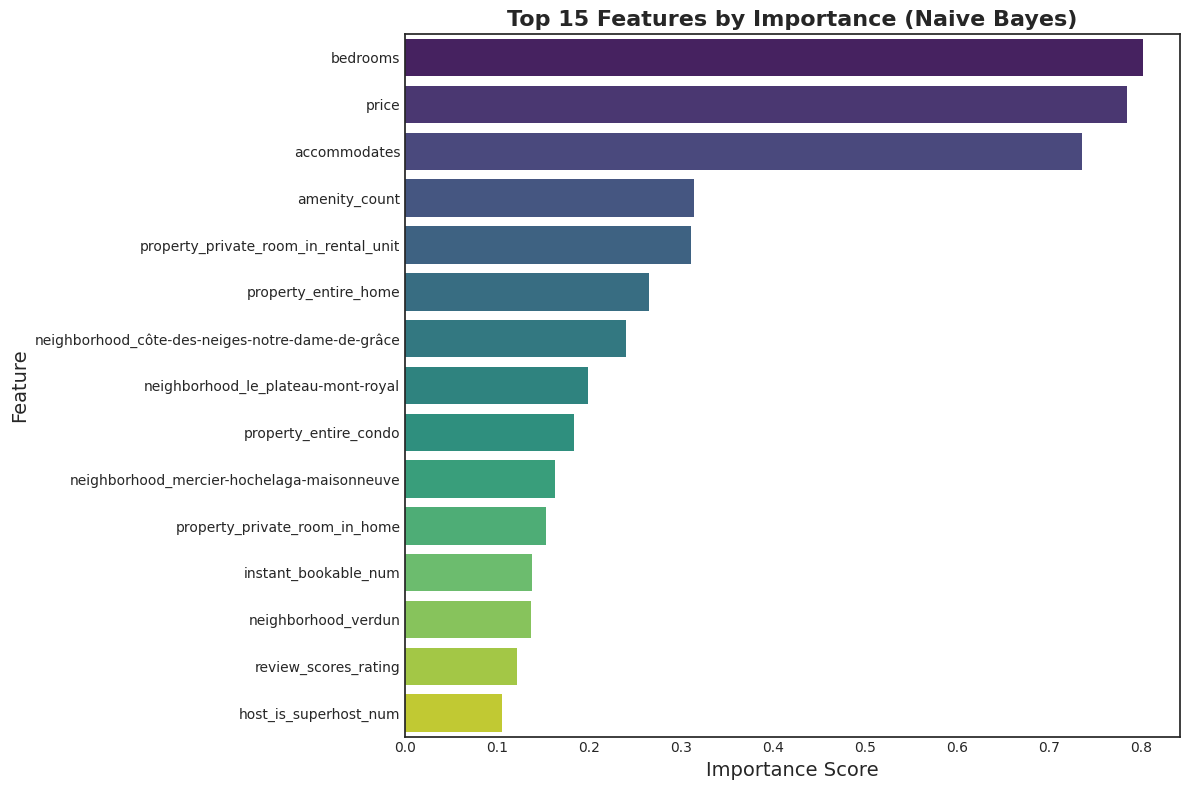

Decision Tree Model Performance:
Accuracy: 0.8377

Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.94      0.90      1455
        True       0.65      0.45      0.53       375

    accuracy                           0.84      1830
   macro avg       0.76      0.69      0.72      1830
weighted avg       0.82      0.84      0.83      1830



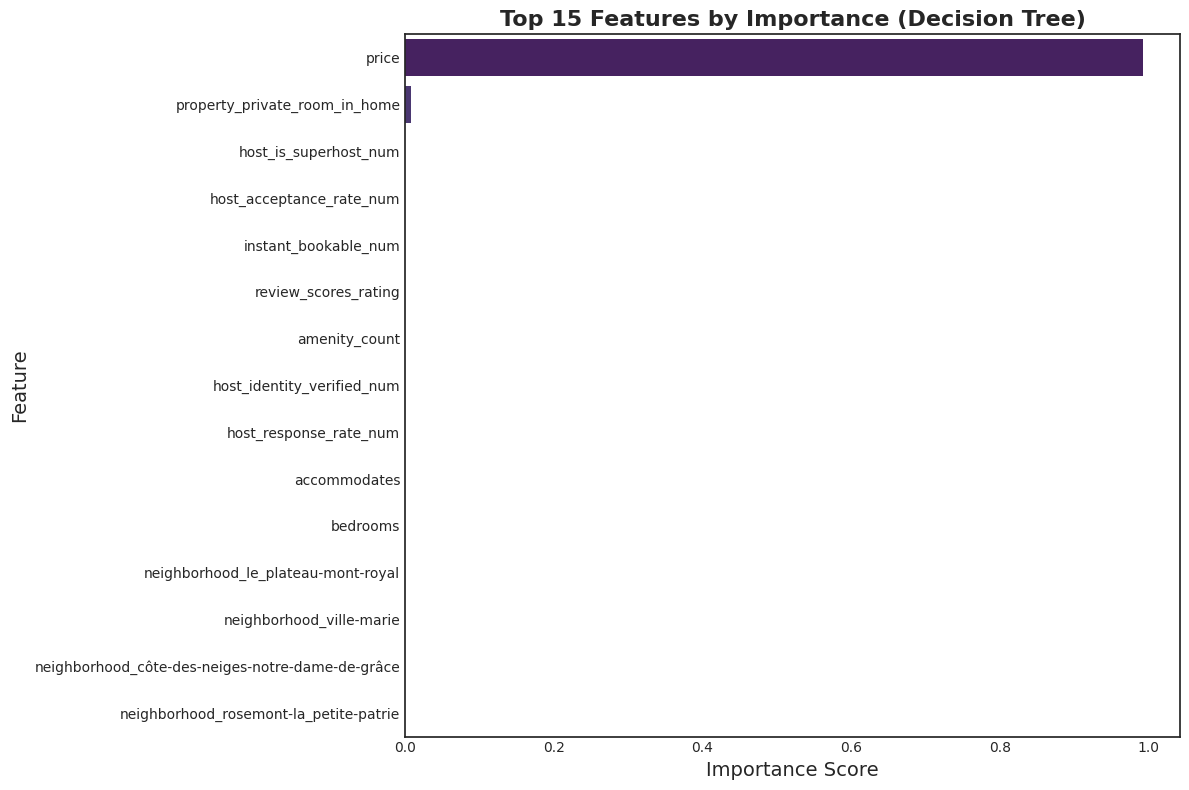

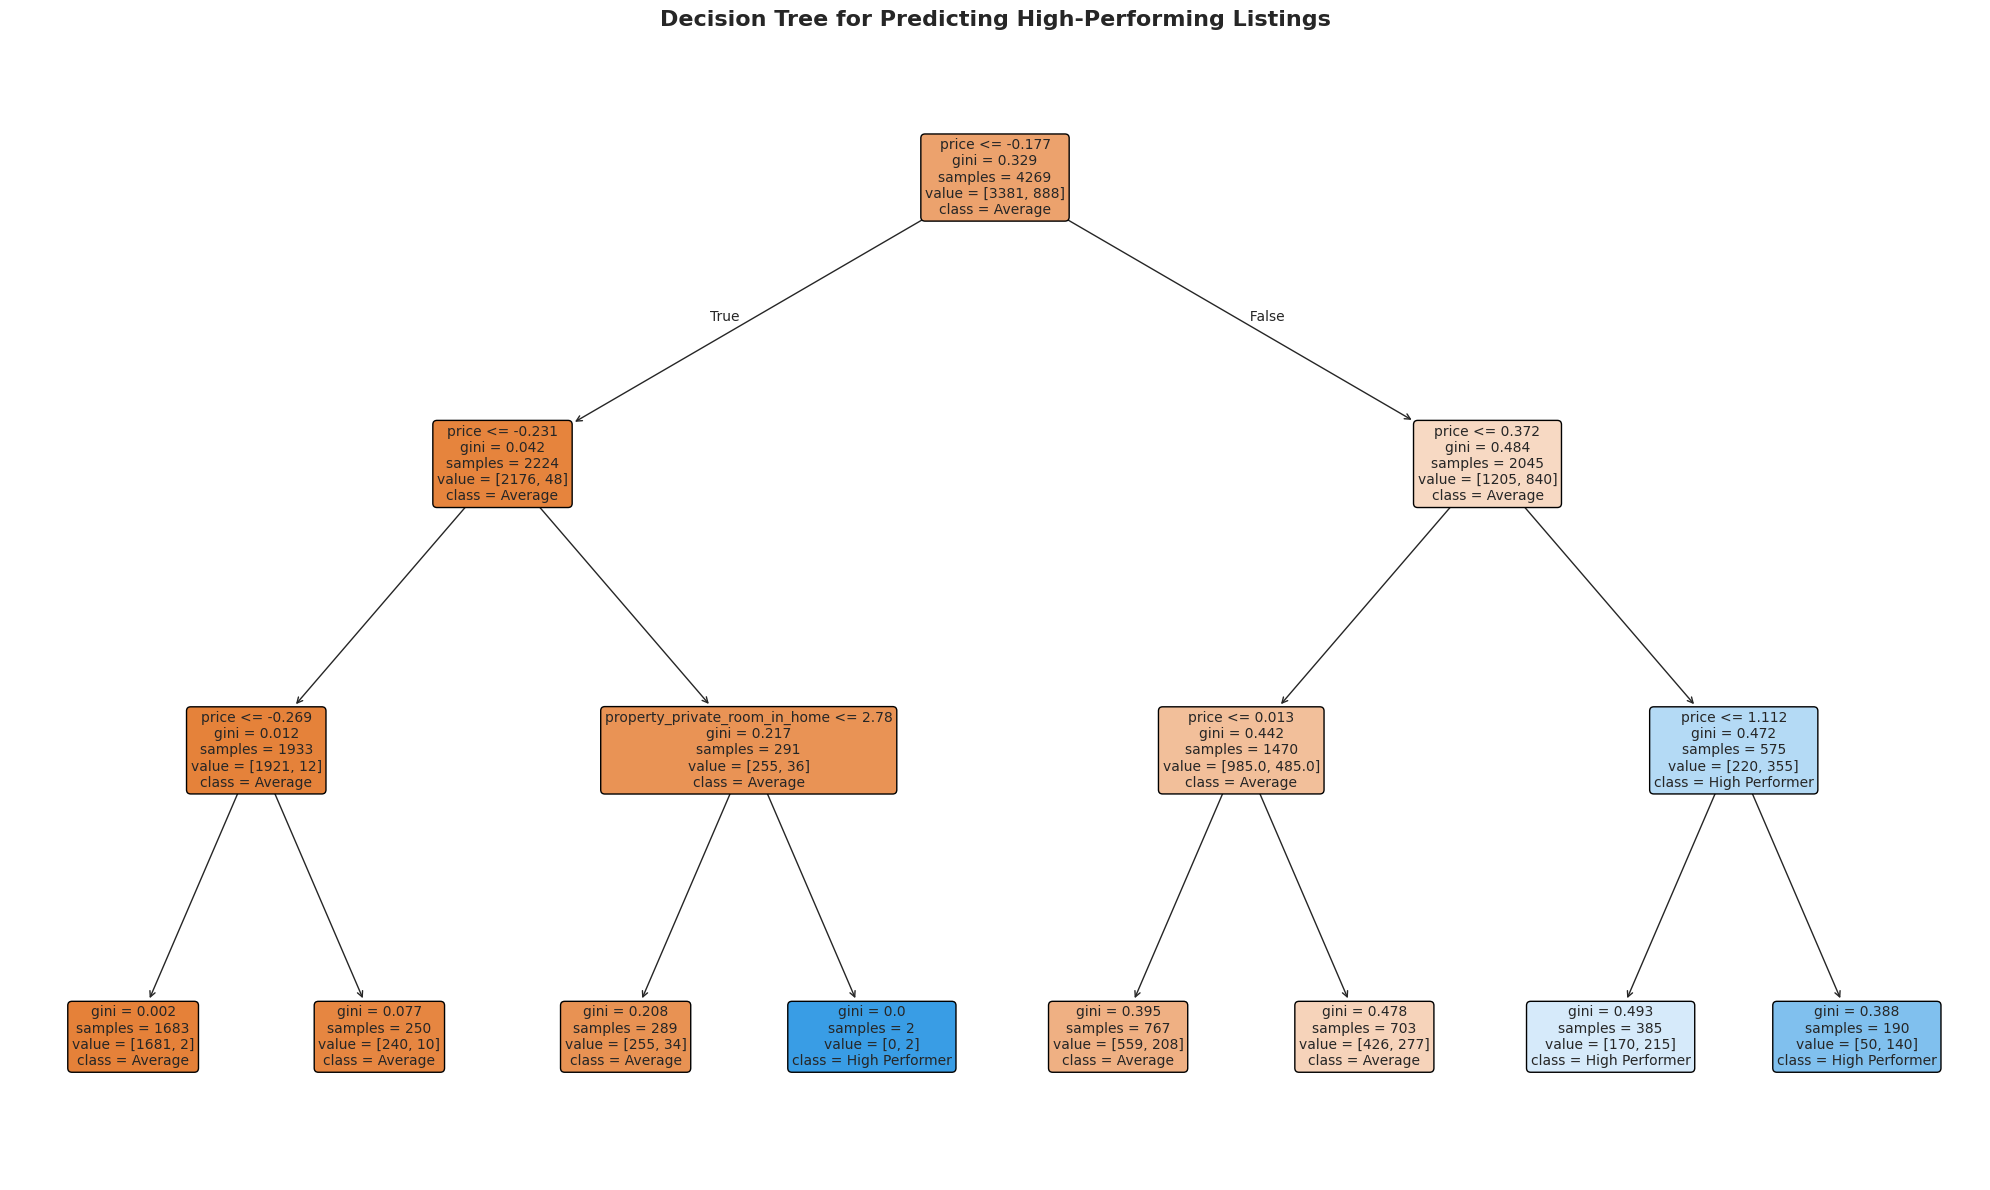

Random Forest Model Performance:
Accuracy: 0.8486

Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.96      0.91      1455
        True       0.72      0.43      0.54       375

    accuracy                           0.85      1830
   macro avg       0.79      0.69      0.72      1830
weighted avg       0.84      0.85      0.83      1830



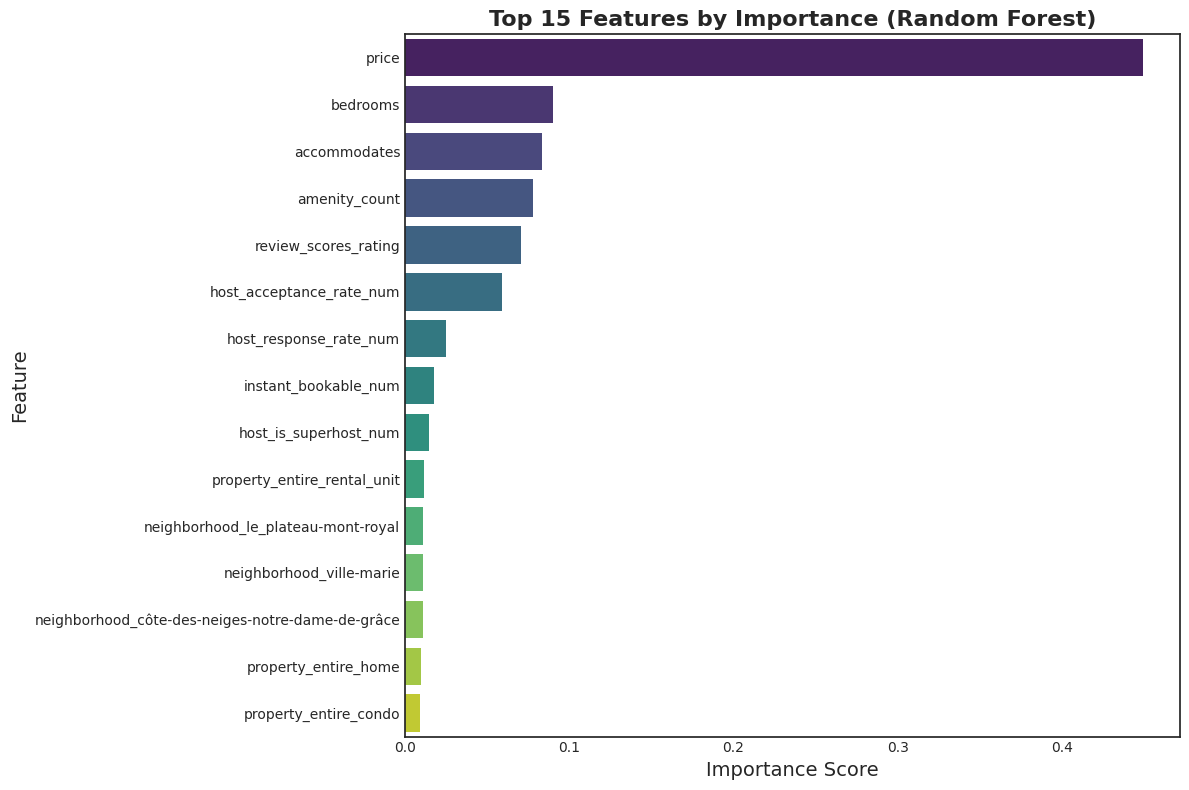

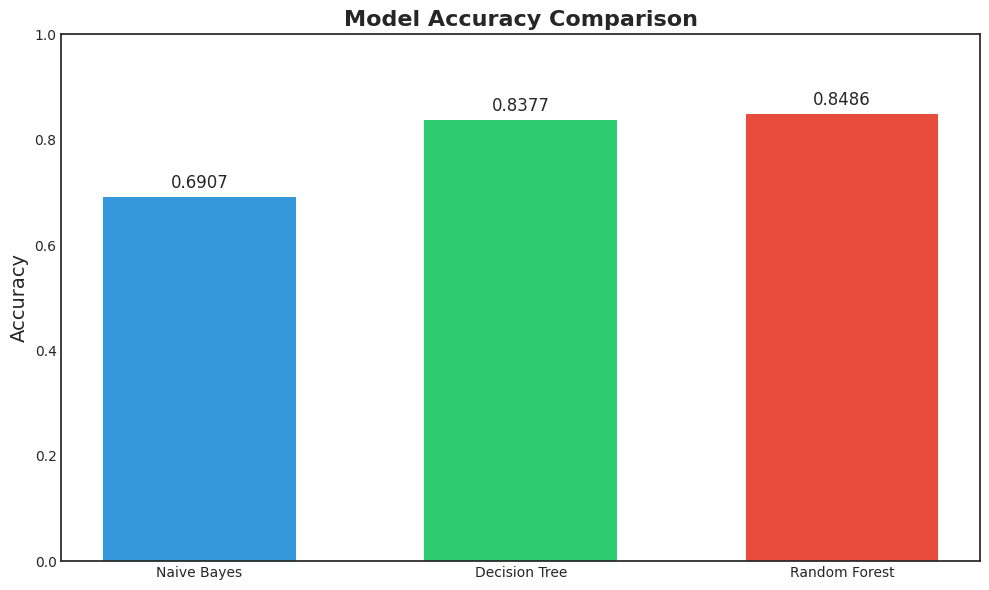

In [ ]:
_# This section applies probability-based and information-based learning techniques
# to identify key factors and predict high-performing properties

# Prepare datasets for modeling
# First, define features that will be used in the models
model_features = [
    'host_response_rate_num',
    'host_acceptance_rate_num',
    'host_is_superhost_num',
    'host_identity_verified_num',
    'instant_bookable_num',
    'review_scores_rating',
    'amenity_count',
    'bedrooms',
    'accommodates',
    'price'
]

# Add neighborhood and property type as encoded features
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Prepare data for modeling by removing missing values
model_data = listings_detailed.dropna(subset=model_features + ['high_performer']).copy()

# Create binary features for top neighborhoods and property types
top_neighborhoods = listings_detailed['neighbourhood_cleansed'].value_counts().head(10).index
for neighborhood in top_neighborhoods:
    model_data[f'neighborhood_{neighborhood.replace(" ", "_").lower()}'] = (
        model_data['neighbourhood_cleansed'] == neighborhood
    ).astype(int)

top_property_types = listings_detailed['property_type'].value_counts().head(5).index
for prop_type in top_property_types:
    model_data[f'property_{prop_type.replace(" ", "_").lower()}'] = (
        model_data['property_type'] == prop_type
    ).astype(int)

# Update features list with new binary columns
model_features += [f'neighborhood_{neighborhood.replace(" ", "_").lower()}' for neighborhood in top_neighborhoods]
model_features += [f'property_{prop_type.replace(" ", "_").lower()}' for prop_type in top_property_types]

# Split features and target
X = model_data[model_features]
y = model_data['high_performer']

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Probability-Based Learning (Naive Bayes)
# This approach models the probability of a property being high-performing
# based on feature distributions
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train Gaussian Naive Bayes model
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
y_prob_nb = nb.predict_proba(X_test_scaled)[:, 1]

# Evaluate Naive Bayes model
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_report = classification_report(y_test, y_pred_nb)
nb_cm = confusion_matrix(y_test, y_pred_nb)

# Display Naive Bayes results
print("Naive Bayes Model Performance:")
print(f"Accuracy: {nb_accuracy:.4f}")
print("\nClassification Report:")
print(nb_report)

# Calculate feature importance for Naive Bayes in a simpler way
# We'll use the absolute difference in class means to measure importance
nb_feature_importance = []

for i in range(len(model_features)):
    # Calculate absolute difference between means for this feature
    importance = abs(nb.theta_[1, i] - nb.theta_[0, i])
    nb_feature_importance.append(importance)

# Create a DataFrame for the feature importance
nb_importance_df = pd.DataFrame({
    'Feature': model_features,
    'Importance': nb_feature_importance
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=nb_importance_df.head(15), palette='viridis')
plt.title('Top 15 Features by Importance (Naive Bayes)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

# 2. Information-Based Learning (Decision Tree)
# This approach identifies the most informative features that separate
# high-performing from average properties
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train Decision Tree model
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
y_prob_dt = dt.predict_proba(X_test_scaled)[:, 1]

# Evaluate Decision Tree model
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_report = classification_report(y_test, y_pred_dt)
dt_cm = confusion_matrix(y_test, y_pred_dt)

# Display Decision Tree results
print("Decision Tree Model Performance:")
print(f"Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:")
print(dt_report)

# Create a DataFrame for Decision Tree feature importance
dt_importance_df = pd.DataFrame({
    'Feature': model_features,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize Decision Tree feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importance_df.head(15), palette='viridis')
plt.title('Top 15 Features by Importance (Decision Tree)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

# Visualize the decision tree structure
plt.figure(figsize=(20, 12))
plot_tree(
    dt,
    feature_names=model_features,
    class_names=['Average', 'High Performer'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree for Predicting High-Performing Listings', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Random Forest Model (Ensemble Learning)
# This approach combines multiple decision trees to improve prediction accuracy
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf)
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Display Random Forest results
print("Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(rf_report)

# Create a DataFrame for Random Forest feature importance
rf_importance_df = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize Random Forest feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(15), palette='viridis')
plt.title('Top 15 Features by Importance (Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

# Compare model performance
model_comparison = pd.DataFrame({
    'Model': ['Naive Bayes', 'Decision Tree', 'Random Forest'],
    'Accuracy': [nb_accuracy, dt_accuracy, rf_accuracy]
})

# Visualize model comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(
    model_comparison['Model'],
    model_comparison['Accuracy'],
    color=['#3498db', '#2ecc71', '#e74c3c'],
    width=0.6
)

# Add accuracy labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.01,
        f"{height:.4f}",
        ha='center',
        va='bottom',
        fontsize=12
    )

# Format the chart
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.0)
plt.grid(False)
plt.tight_layout()
plt.show()

# Create a function to predict whether a property will be high-performing
def predict_performance(
    price,
    bedrooms,
    neighborhood,
    property_type,
    is_superhost=False,
    amenity_count=15,
    review_rating=4.5,
    instant_booking=False
):
    """
    Predicts whether a property will be high-performing based on its characteristics.

    Parameters:
    -----------
    price : float
        The nightly price of the property in CAD
    bedrooms : int
        Number of bedrooms
    neighborhood : str
        The neighborhood in Montreal
    property_type : str
        The property type (e.g., 'Entire rental unit')
    is_superhost : bool, optional
        Whether the host is a Superhost (default: False)
    amenity_count : int, optional
        Number of amenities offered (default: 15)
    review_rating : float, optional
        Average review rating (1-5) (default: 4.5)
    instant_booking : bool, optional
        Whether instant booking is enabled (default: False)

    Returns:
    --------
    dict
        A dictionary containing prediction results and probabilities
    """
    # Create a feature vector for prediction
    features = {}

    # Add basic features
    features['price'] = price
    features['bedrooms'] = bedrooms
    features['amenity_count'] = amenity_count
    features['review_scores_rating'] = review_rating
    features['host_is_superhost_num'] = 1 if is_superhost else 0
    features['instant_bookable_num'] = 1 if instant_booking else 0

    # Add placeholder values for features we don't have direct input for
    features['host_response_rate_num'] = 0.95  # 95% response rate as default
    features['host_acceptance_rate_num'] = 0.9  # 90% acceptance rate as default
    features['host_identity_verified_num'] = 1  # Assuming identity is verified
    features['accommodates'] = bedrooms * 2  # Estimate accommodates based on bedrooms

    # Add binary neighborhood features
    for n in top_neighborhoods:
        features[f'neighborhood_{n.replace(" ", "_").lower()}'] = 1 if neighborhood == n else 0

    # Add binary property type features
    for p in top_property_types:
        features[f'property_{p.replace(" ", "_").lower()}'] = 1 if property_type == p else 0

    # Create a DataFrame with the right column order
    input_df = pd.DataFrame([features])
    input_df = input_df.reindex(columns=model_features, fill_value=0)

    # Scale the features
    input_scaled = scaler.transform(input_df)

    # Make predictions with all three models
    nb_prob = nb.predict_proba(input_scaled)[0, 1]
    dt_prob = dt.predict_proba(input_scaled)[0, 1]
    rf_prob = rf.predict_proba(input_scaled)[0, 1]

    # Calculate weighted average probability
    # Give more weight to the most accurate model (Random Forest)
    weighted_prob = (nb_prob * 0.2) + (dt_prob * 0.2) + (rf_prob * 0.6)

    # Determine prediction
    is_high_performer = weighted_prob >= 0.5

    # Calculate estimated monthly revenue
    # We can use average occupancy rates from our data to estimate revenue
    avg_occupancy = model_data[model_data['high_performer'] == is_high_performer]['occupancy_rate'].mean()
    estimated_monthly_revenue = price * (avg_occupancy / 100) * 30

    # Return results
    return {
        'prediction': 'High Performer' if is_high_performer else 'Average Performer',
        'probability': weighted_prob * 100,
        'model_probabilities': {
            'naive_bayes': nb_prob * 100,
            'decision_tree': dt_prob * 100,
            'random_forest': rf_prob * 100
        },
        'estimated_monthly_revenue': estimated_monthly_revenue,
        'estimated_occupancy_rate': avg_occupancy
    }

# Create interactive prediction form
def show_prediction_form():
    # Create form elements
    price_slider = widgets.IntSlider(
        value=150,
        min=50,
        max=500,
        step=10,
        description='Price (CAD):',
        style={'description_width': 'initial'}
    )

    bedrooms_dropdown = widgets.Dropdown(
        options=[1, 2, 3, 4, 5, 6],
        value=2,
        description='Bedrooms:',
        style={'description_width': 'initial'}
    )

    neighborhood_dropdown = widgets.Dropdown(
        options=sorted(top_neighborhoods),
        value=top_neighborhoods[0],
        description='Neighborhood:',
        style={'description_width': 'initial'}
    )

    property_dropdown = widgets.Dropdown(
        options=sorted(top_property_types),
        value=top_property_types[0],
        description='Property Type:',
        style={'description_width': 'initial'}
    )

    superhost_checkbox = widgets.Checkbox(
        value=False,
        description='Is Superhost',
        style={'description_width': 'initial'}
    )

    amenity_slider = widgets.IntSlider(
        value=15,
        min=5,
        max=50,
        step=5,
        description='Amenity Count:',
        style={'description_width': 'initial'}
    )

    rating_slider = widgets.FloatSlider(
        value=4.5,
        min=3.0,
        max=5.0,
        step=0.1,
        description='Review Rating:',
        style={'description_width': 'initial'}
    )

    instant_booking_checkbox = widgets.Checkbox(
        value=False,
        description='Instant Booking',
        style={'description_width': 'initial'}
    )

    # Create prediction output area
    output = widgets.Output()

    # Function to handle form submission
    def on_predict_button_clicked(b):
        with output:
            output.clear_output()
            # Get form values
            price = price_slider.value
            bedrooms = bedrooms_dropdown.value
            neighborhood = neighborhood_dropdown.value
            property_type = property_dropdown.value
            is_superhost = superhost_checkbox.value
            amenity_count = amenity_slider.value
            rating = rating_slider.value
            instant_booking = instant_booking_checkbox.value

            # Make prediction
            result = predict_performance(
                price,
                bedrooms,
                neighborhood,
                property_type,
                is_superhost,
                amenity_count,
                rating,
                instant_booking
            )

            # Display result
            display(HTML(f"""
            <h3>Prediction Results</h3>
            <div style="background-color: {'#a3cfec' if result['prediction'] == 'Average Performer' else '#f9d5d3'}; padding: 15px; border-radius: 10px; margin-bottom: 15px;">
                <h4>Predicted Performance: {result['prediction']} ({result['probability']:.1f}%)</h4>
                <p><b>Estimated Monthly Revenue:</b> ${result['estimated_monthly_revenue']:.2f}</p>
                <p><b>Estimated Occupancy Rate:</b> {result['estimated_occupancy_rate']:.1f}%</p>
            </div>

            <h4>Individual Model Predictions:</h4>
            <ul>
                <li><b>Naive Bayes:</b> {result['model_probabilities']['naive_bayes']:.1f}%</li>
                <li><b>Decision Tree:</b> {result['model_probabilities']['decision_tree']:.1f}%</li>
                <li><b>Random Forest:</b> {result['model_probabilities']['random_forest']:.1f}%</li>
            </ul>
            """))

            # Add suggestions
            avg_price = model_data[
                (model_data['neighbourhood_cleansed'] == neighborhood) &
                (model_data['property_type'] == property_type) &
                (model_data['bedrooms'] == bedrooms)
            ]['price'].mean()

            if not pd.isna(avg_price):
                if price < avg_price * 0.8:
                    display(HTML(f"<p style='color: #27ae60;'><b>Suggestion:</b> Consider increasing your price. Properties similar to yours in {neighborhood} charge an average of ${avg_price:.2f} per night.</p>"))
                elif price > avg_price * 1.2:
                    display(HTML(f"<p style='color: #e74c3c;'><b>Suggestion:</b> Your price may be high for the market. Properties similar to yours in {neighborhood} charge an average of ${avg_price:.2f} per night.</p>"))

            if amenity_count < 20 and result['prediction'] == 'Average Performer':
                display(HTML("<p style='color: #27ae60;'><b>Suggestion:</b> Adding more amenities could improve performance. High-performing properties have an average of 25+ amenities.</p>"))

            if not is_superhost and result['prediction'] == 'Average Performer':
                display(HTML("<p style='color: #27ae60;'><b>Suggestion:</b> Working toward Superhost status could increase your revenue potential.</p>"))

    # Create a predict button
    predict_button = widgets.Button(
        description='Predict Performance',
        button_style='primary',
        tooltip='Click to predict performance'
    )
    predict_button.on_click(on_predict_button_clicked)

    # Create form layout
    form = widgets.VBox([
        widgets.HBox([price_slider, bedrooms_dropdown]),
        widgets.HBox([neighborhood_dropdown, property_dropdown]),
        widgets.HBox([superhost_checkbox, instant_booking_checkbox]),
        widgets.HBox([amenity_slider, rating_slider]),
        predict_button,
        output
    ])

    # Display the form
    display(HTML("<h3>Property Performance Predictor</h3>"))
    display(form)

# Display the prediction form
show_prediction_form()

# 10. INTERACTIVE MONTREAL AIRBNB NEIGHBORHOOD EXPLORER

This section creates interactive mapping tools to explore Montreal neighborhoods,
analyze property performance metrics, and visualize individual listing details.


In [ ]:
# Calculate neighborhood performance metrics for map visualization
neighborhood_metrics = listings_detailed.groupby('neighbourhood_cleansed').agg(
    avg_price=('price', 'mean'),
    median_price=('price', 'median'),
    num_listings=('id', 'count'),
    avg_review_scores=('review_scores_rating', 'mean'),
    avg_occupancy_rate=('occupancy_rate', 'mean'),
    avg_monthly_revenue=('estimated_monthly_revenue', 'mean'),
    total_monthly_revenue=('estimated_monthly_revenue', 'sum')
).reset_index()

# Create a function to generate interactive maps with Folium
def create_montreal_map(metric='avg_monthly_revenue', title=None):
    """
    Create an interactive choropleth map of Montreal neighborhoods.

    Parameters:
    -----------
    metric : str
        The metric to visualize (default: 'avg_monthly_revenue')
    title : str, optional
        The title for the map (default: None, which uses a formatted version of the metric)

    Returns:
    --------
    folium.Map
        An interactive map object
    """
    # Center the map on Montreal
    m = folium.Map(
        location=[45.5017, -73.5673],
        zoom_start=11,
        tiles='CartoDB positron'
    )

    # Format the title if not provided
    if title is None:
        title = f"Montreal Airbnb: {metric.replace('_', ' ').title()}"

    # Format the legend title
    legend_name = metric.replace('_', ' ').title()
    if 'price' in metric or 'revenue' in metric:
        legend_name += ' (CAD)'
    elif 'rate' in metric:
        legend_name += ' (%)'

    # Choose a color scheme based on the metric
    if 'review' in metric:
        color_scheme = 'YlGn'
    elif 'occupancy' in metric:
        color_scheme = 'Blues'
    else:
        color_scheme = 'YlOrRd'

    # Add the choropleth layer
    choropleth = folium.Choropleth(
        geo_data=neighbourhoods_geo,
        name=legend_name,
        data=neighborhood_metrics,
        columns=['neighbourhood_cleansed', metric],
        key_on='feature.properties.neighbourhood',
        fill_color=color_scheme,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        highlight=True
    ).add_to(m)

    # Add tooltips to provide more information when hovering over neighborhoods
    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(
            fields=['neighbourhood'],
            aliases=['Neighborhood:'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    )

    # Add detailed popups for each neighborhood
    for feature in choropleth.geojson.data['features']:
        neighborhood = feature['properties']['neighbourhood']

        # Get metrics for this neighborhood
        metrics = neighborhood_metrics[neighborhood_metrics['neighbourhood_cleansed'] == neighborhood]

        if not metrics.empty:
            # Get the centroid of the neighborhood polygon
            coords = feature['geometry']['coordinates'][0][0]  # First polygon, first ring
            centroid_lat = sum(point[1] for point in coords) / len(coords)
            centroid_lng = sum(point[0] for point in coords) / len(coords)

            # Create a popup with detailed metrics
            popup_html = f"""
            <div style="font-family: Arial; width: 200px;">
                <h4>{neighborhood}</h4>
                <p><b>Avg Monthly Revenue:</b> ${metrics['avg_monthly_revenue'].values[0]:.2f}</p>
                <p><b>Avg Price:</b> ${metrics['avg_price'].values[0]:.2f}</p>
                <p><b>Occupancy Rate:</b> {metrics['avg_occupancy_rate'].values[0]:.1f}%</p>
                <p><b>Listings:</b> {metrics['num_listings'].values[0]}</p>
                <p><b>Review Score:</b> {metrics['avg_review_scores'].values[0]:.2f}/5.0</p>
            </div>
            """

            # Add a marker at the centroid with the popup
            folium.Marker(
                location=[centroid_lat, centroid_lng],
                popup=folium.Popup(popup_html, max_width=250),
                icon=folium.Icon(icon='info-sign', prefix='fa')
            ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    return m

# Create a map for average monthly revenue
revenue_map = create_montreal_map('avg_monthly_revenue', 'Montreal Airbnb: Average Monthly Revenue by Neighborhood')
revenue_map

# Create a map for occupancy rates
occupancy_map = create_montreal_map('avg_occupancy_rate', 'Montreal Airbnb: Average Occupancy Rate by Neighborhood')
occupancy_map

# Create a map for price distribution
price_map = create_montreal_map('avg_price', 'Montreal Airbnb: Average Price by Neighborhood')
price_map

# Create a function to generate a map with individual listings
def create_listings_map(neighborhood=None, min_price=None, max_price=None, min_bedrooms=None):
    """
    Create an interactive map with individual listing markers.

    Parameters:
    -----------
    neighborhood : str, optional
        Filter by neighborhood (default: None, which shows all neighborhoods)
    min_price : float, optional
        Minimum price filter (default: None)
    max_price : float, optional
        Maximum price filter (default: None)
    min_bedrooms : int, optional
        Minimum number of bedrooms filter (default: None)

    Returns:
    --------
    folium.Map
        An interactive map object
    """
    # Filter listings based on parameters
    filtered_listings = listings_detailed.copy()

    if neighborhood:
        filtered_listings = filtered_listings[filtered_listings['neighbourhood_cleansed'] == neighborhood]

    if min_price:
        filtered_listings = filtered_listings[filtered_listings['price'] >= min_price]

    if max_price:
        filtered_listings = filtered_listings[filtered_listings['price'] <= max_price]

    if min_bedrooms:
        filtered_listings = filtered_listings[filtered_listings['bedrooms'] >= min_bedrooms]

    # If too many listings, take a sample
    if len(filtered_listings) > 500:
        filtered_listings = filtered_listings.sample(500, random_state=42)

    # Create the base map
    m = folium.Map(
        location=[45.5017, -73.5673],
        zoom_start=11,
        tiles='CartoDB positron'
    )

    # Add neighborhood boundaries
    folium.GeoJson(
        neighbourhoods_geo,
        name='Neighborhoods',
        style_function=lambda x: {
            'fillColor': 'transparent',
            'color': 'grey',
            'weight': 1
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields=['neighbourhood'],
            aliases=['Neighborhood:'],
            style=("background-color: white; color: #333333;")
        )
    ).add_to(m)

    # Create a MarkerCluster for better performance with many markers
    marker_cluster = folium.plugins.MarkerCluster().add_to(m)

    # Add markers for each listing
    for idx, row in filtered_listings.iterrows():
        # Skip listings without coordinates
        if pd.isna(row['latitude']) or pd.isna(row['longitude']):
            continue

        # Determine marker color based on listing type
        if row['high_performer']:
            color = 'red'
        else:
            color = 'blue'

        # Create popup content
        popup_content = f"""
        <div style="font-family: Arial; width: 200px;">
            <h4>{row['name']}</h4>
            <p><b>Price:</b> ${row['price']:.2f}</p>
            <p><b>Property Type:</b> {row['property_type']}</p>
            <p><b>Bedrooms:</b> {row['bedrooms']}</p>
            <p><b>Occupancy Rate:</b> {row['occupancy_rate']:.1f}%</p>
            <p><b>Monthly Revenue:</b> ${row['estimated_monthly_revenue']:.2f}</p>
            <p><b>Review Score:</b> {row['review_scores_rating'] if not pd.isna(row['review_scores_rating']) else 'N/A'}</p>
        </div>
        """

        # Create marker with popup
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_content, max_width=250),
            icon=folium.Icon(color=color, icon='home', prefix='fa')
        ).add_to(marker_cluster)

    # Add layer control
    folium.LayerControl().add_to(m)

    return m

# Create a map with individual listings (limited to 500 to prevent browser slowdown)
listings_map = create_listings_map()
listings_map

# Create an interactive widget to explore neighborhoods with individual listings
def explore_neighborhood_map(neighborhood):
    """Create a map for a specific neighborhood with individual listings"""
    if neighborhood:
        # Get the number of listings in this neighborhood
        num_listings = listings_detailed[listings_detailed['neighbourhood_cleansed'] == neighborhood].shape[0]

        # Display information about the neighborhood
        print(f"Showing {num_listings} listings in {neighborhood}")

        # Create and display the map
        return create_listings_map(neighborhood=neighborhood)
    else:
        print("Please select a neighborhood")
        return None

# Create neighborhood dropdown
neighborhood_widget = widgets.Dropdown(
    options=[''] + sorted(listings_detailed['neighbourhood_cleansed'].unique().tolist()),
    value='',
    description='Explore Neighborhood:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Display widget and interactive map
display(HTML("<h3>Interactive Neighborhood Explorer</h3>"))
display(widgets.interactive(explore_neighborhood_map, neighborhood=neighborhood_widget))

# Create function for price range exploration
def explore_price_range(min_price, max_price, min_bedrooms=1):
    """Create a map filtered by price range and minimum bedrooms"""
    if min_price <= max_price:
        # Get the number of listings in this price range
        num_listings = listings_detailed[
            (listings_detailed['price'] >= min_price) &
            (listings_detailed['price'] <= max_price) &
            (listings_detailed['bedrooms'] >= min_bedrooms)
        ].shape[0]

        # Display information
        print(f"Found {num_listings} listings between ${min_price} and ${max_price} with {min_bedrooms}+ bedrooms")

        # Create and display the map (maximum 500 listings to prevent slowdown)
        return create_listings_map(min_price=min_price, max_price=max_price, min_bedrooms=min_bedrooms)
    else:
        print("Minimum price must be less than or equal to maximum price")
        return None

# Create price range widgets
min_price_slider = widgets.IntSlider(
    value=50,
    min=0,
    max=500,
    step=10,
    description='Min Price:',
    style={'description_width': 'initial'}
)

max_price_slider = widgets.IntSlider(
    value=200,
    min=0,
    max=500,
    step=10,
    description='Max Price:',
    style={'description_width': 'initial'}
)

bedroom_dropdown = widgets.Dropdown(
    options=[1, 2, 3, 4, 5],
    value=1,
    description='Min Bedrooms:',
    style={'description_width': 'initial'}
)

# Display widgets for price range exploration
display(HTML("<h3>Explore Listings by Price Range</h3>"))
display(widgets.interactive(
    explore_price_range,
    min_price=min_price_slider,
    max_price=max_price_slider,
    min_bedrooms=bedroom_dropdown
))

interactive(children=(Dropdown(description='Explore Neighborhood:', layout=Layout(width='50%'), options=('', '…

interactive(children=(IntSlider(value=50, description='Min Price:', max=500, step=10, style=SliderStyle(descri…

# 11. Reviews and Language Analysis for Montreal Airbnb

This section analyzes the multilingual nature of reviews in Montreal,
focusing on English and French content and their sentiment patterns

Total number of reviews: 270861
Analyzing language for 10000 sampled reviews...

Language Distribution in Reviews:
Language  Count  Percentage
      en   7361       73.89
      fr   2076       20.84
      es    163        1.64
      de     60        0.60
      ro     41        0.41
      pt     29        0.29
      ko     25        0.25
   zh-cn     25        0.25
      ca     24        0.24
      nl     18        0.18

Percentage of French reviews: 20.84%


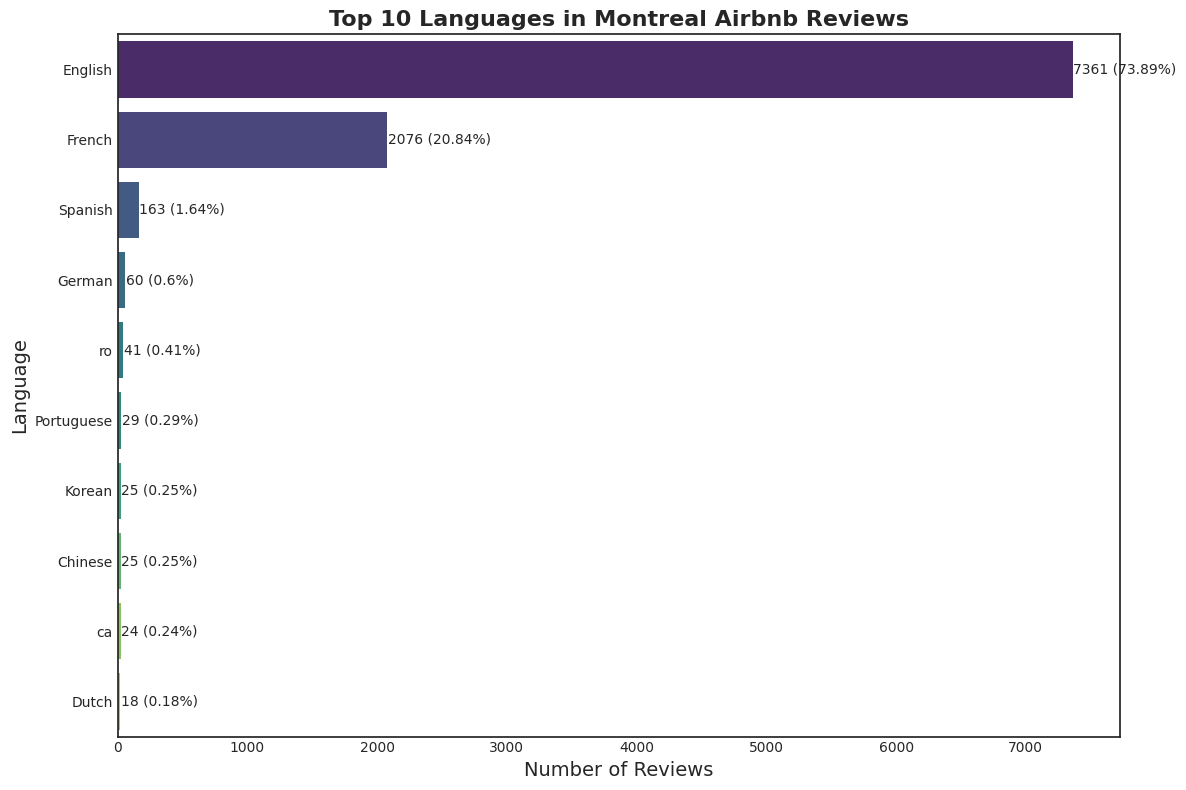

Average English review sentiment: 0.805
Average French review sentiment: 0.739


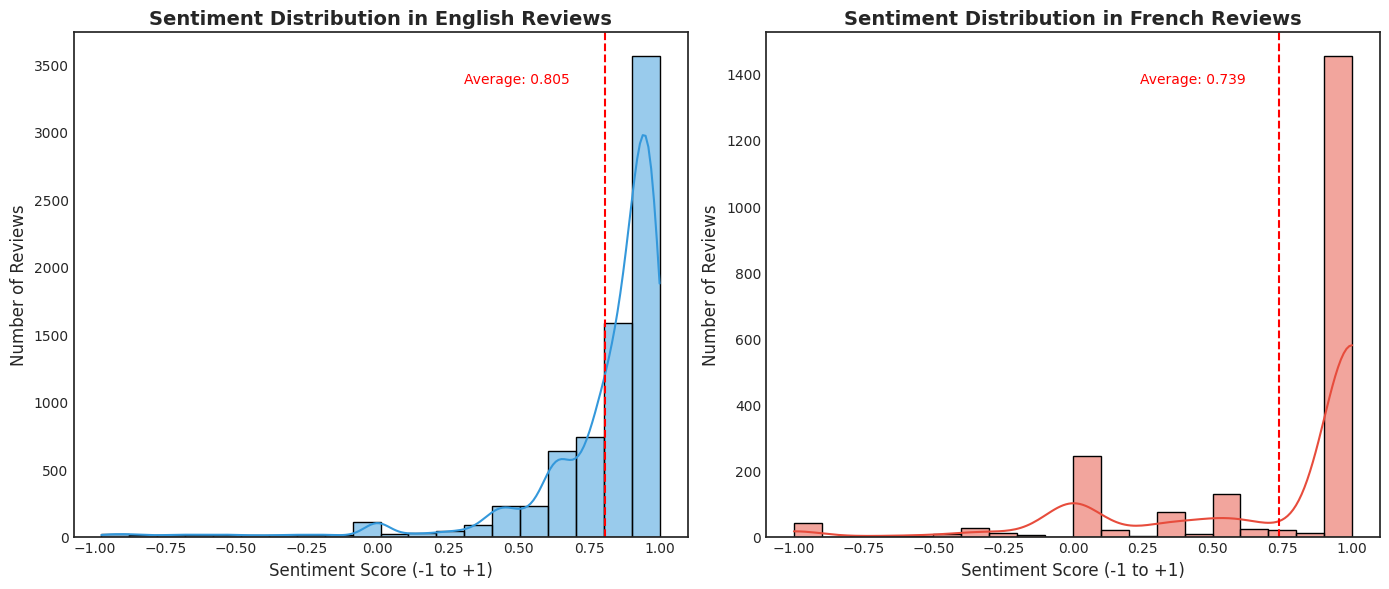


Top 5 Neighborhoods by English Review Sentiment:
                  neighbourhood_cleansed  avg_sentiment  review_count
                               Outremont       0.921148            29
                               Westmount       0.883147            30
                          Côte-Saint-Luc       0.871150            10
                                  Dorval       0.841413            23
Rivière-des-Prairies-Pointe-aux-Trembles       0.837810            10

Bottom 5 Neighborhoods by English Review Sentiment:
neighbourhood_cleansed  avg_sentiment  review_count
                 Anjou       0.520450            12
               LaSalle       0.736321            61
   Pierrefonds-Roxboro       0.743596            25
               Lachine       0.748156            79
         Saint-Léonard       0.767632            28

Top 5 Neighborhoods by French Review Sentiment:
neighbourhood_cleansed  avg_sentiment  review_count
               Lachine       0.901235            27
 Ahuntsic-Ca

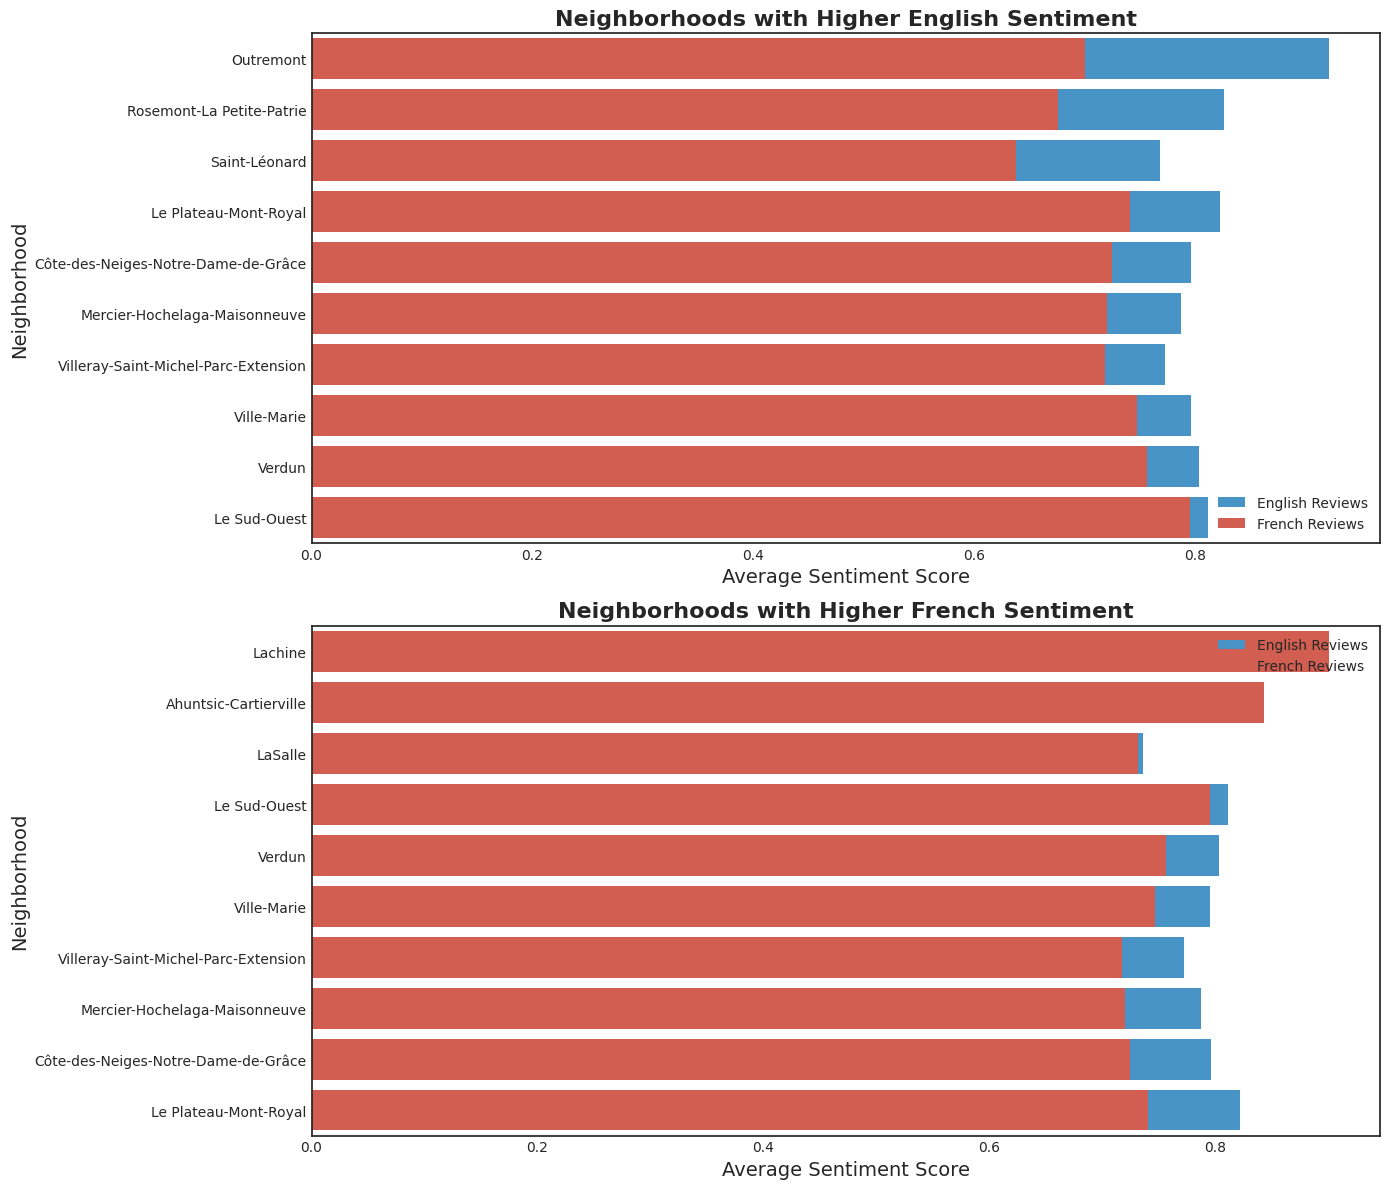


Correlation between Review Sentiment and Performance Metrics:
         Metric  Correlation with Sentiment
          Price                    0.100666
 Occupancy Rate                    0.016737
Monthly Revenue                    0.094143

Average Sentiment by Property Performance:
    high_performer  avg_sentiment  listing_count
Average Performers       0.792142            971
   High Performers       0.816258            288


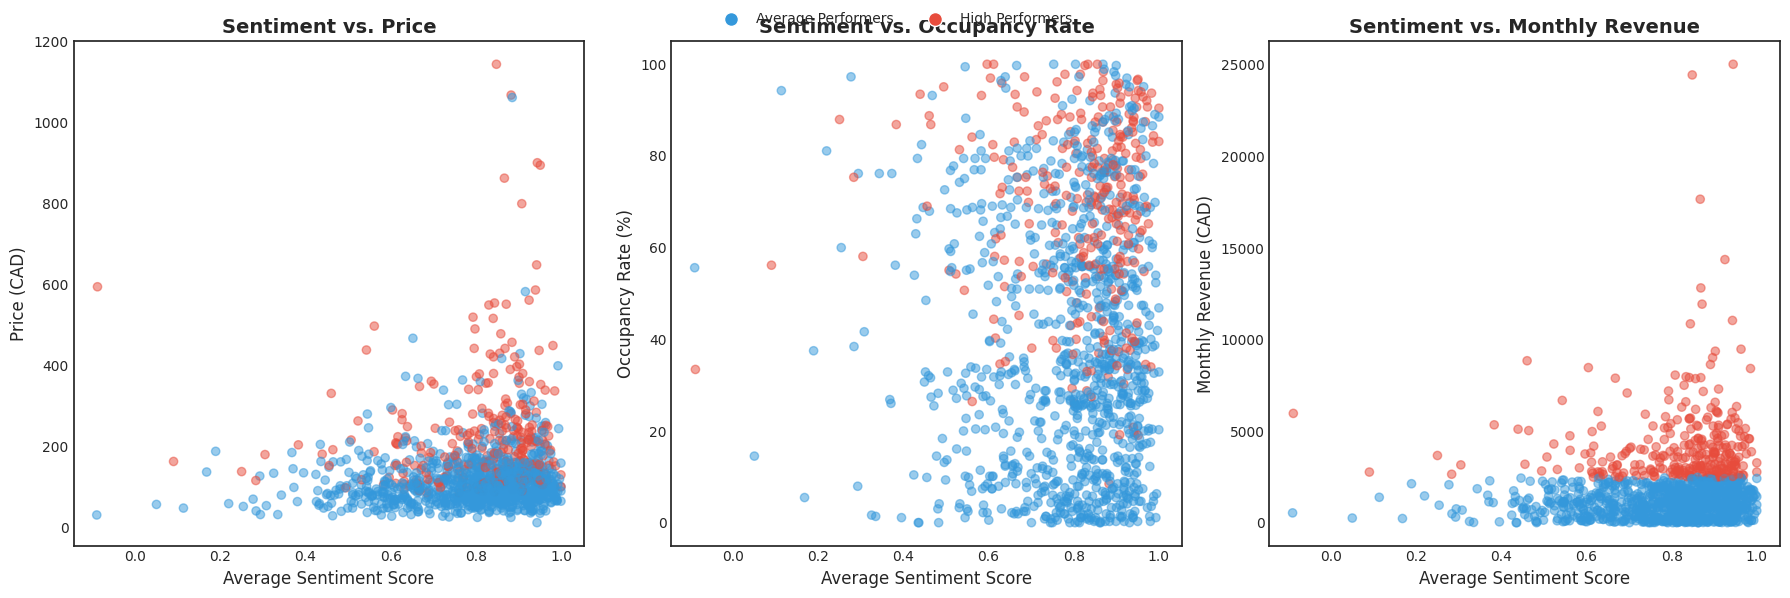

interactive(children=(Dropdown(description='Property Type:', layout=Layout(width='50%'), options=('', 'Castle'…

In [ ]:
from langdetect import detect
import random
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

# Suppress warnings
warnings.filterwarnings("ignore")

# Download NLTK resources for sentiment analysis
import nltk
nltk.download('vader_lexicon', quiet=True)

# Function to detect language in text fields
def detect_language(text):
    """Detect the language of a text string."""
    if pd.isna(text) or str(text).strip() == '':
        return None
    try:
        return detect(str(text)[:1000])  # Use only first 1000 characters for efficiency
    except:
        return None

# Sample 10,000 reviews for language analysis to improve performance
# First, determine the total number of reviews
total_reviews = len(reviews_detailed)
print(f"Total number of reviews: {total_reviews}")

# Take a random sample of 10,000 reviews (or all if fewer than 10,000)
sample_size = min(10000, total_reviews)
reviews_sample = reviews_detailed.sample(sample_size, random_state=42)
print(f"Analyzing language for {sample_size} sampled reviews...")

# Detect language for the sampled reviews
reviews_sample['comment_language'] = reviews_sample['comments'].apply(detect_language)

# Calculate language distribution
language_counts = reviews_sample['comment_language'].value_counts()
language_percentages = (reviews_sample['comment_language'].value_counts(normalize=True) * 100).round(2)

# Create a DataFrame for display
language_df = pd.DataFrame({
    'Language': language_counts.index,
    'Count': language_counts.values,
    'Percentage': language_percentages.values
})

# Display the language distribution
print("\nLanguage Distribution in Reviews:")
print(language_df.head(10).to_string(index=False))

# Calculate percentage of French reviews
total_sample_reviews = reviews_sample['comment_language'].count()
french_reviews = reviews_sample['comment_language'].value_counts().get('fr', 0)
french_reviews_pct = (french_reviews / total_sample_reviews) * 100 if total_sample_reviews > 0 else 0
print(f"\nPercentage of French reviews: {french_reviews_pct:.2f}%")

# Create language distribution visualization with proper language names
language_map = {
    'en': 'English',
    'fr': 'French',
    'es': 'Spanish',
    'de': 'German',
    'it': 'Italian',
    'nl': 'Dutch',
    'pt': 'Portuguese',
    'pl': 'Polish',
    'ru': 'Russian',
    'zh-cn': 'Chinese',
    'ja': 'Japanese',
    'ko': 'Korean',
    'ar': 'Arabic',
    'tr': 'Turkish'
}

# Map language codes to full names
language_counts_display = language_counts.copy()
language_counts_display.index = language_counts_display.index.map(lambda x: language_map.get(x, x))

plt.figure(figsize=(12, 8))
chart = sns.barplot(
    x=language_counts_display.head(10).values,
    y=language_counts_display.head(10).index,
    palette='viridis'
)

# Add value labels
for i, v in enumerate(language_counts_display.head(10).values):
    chart.text(v + 5, i, f"{v} ({language_percentages.head(10).values[i]}%)", va='center')

# Format the chart
plt.title('Top 10 Languages in Montreal Airbnb Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Language', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

# Sentiment Analysis for English and French Reviews
# Initialize VADER for English sentiment analysis
sia = SentimentIntensityAnalyzer()

# Function for English sentiment analysis
def analyze_english_sentiment(text):
    """Analyze sentiment of English text using VADER."""
    if pd.isna(text) or str(text).strip() == '':
        return None
    sentiment = sia.polarity_scores(str(text))
    return sentiment['compound']  # Compound score ranges from -1 (negative) to 1 (positive)

# Simple lexicon-based approach for French sentiment analysis
# This is a simplified approach - in production, you would use a dedicated French sentiment analyzer
def analyze_french_sentiment(text):
    """Simple rule-based sentiment analysis for French text."""
    if pd.isna(text) or str(text).strip() == '':
        return None

    # Define simple lists of positive and negative words in French
    positive_words = [
        'bon', 'bien', 'excellent', 'agréable', 'super', 'parfait', 'génial', 'merveilleux',
        'fantastique', 'propre', 'confortable', 'recommande', 'belle', 'joli', 'accueillant',
        'sympa', 'gentil', 'chaleureux', 'magnifique', 'adorable', 'impeccable', 'spacieux'
    ]

    negative_words = [
        'mauvais', 'terrible', 'horrible', 'désagréable', 'sale', 'bruyant', 'problème',
        'difficile', 'décevant', 'pas propre', 'pas bon', 'pas bien', 'déçu', 'dommage',
        'malheureusement', 'loin', 'petit', 'manque', 'cher', 'bruit', 'froid', 'odeur'
    ]

    text = text.lower()
    positive_count = sum(text.count(word) for word in positive_words)
    negative_count = sum(text.count(word) for word in negative_words)

    # Compute sentiment score normalized between -1 and 1
    total = positive_count + negative_count
    if total == 0:
        return 0
    return (positive_count - negative_count) / total

# Apply sentiment analysis based on detected language
def analyze_multilingual_sentiment(row):
    """Apply appropriate sentiment analysis based on detected language."""
    lang = row['comment_language']
    text = row['comments']

    if lang == 'en':
        return analyze_english_sentiment(text)
    elif lang == 'fr':
        return analyze_french_sentiment(text)
    else:
        return None

# Apply sentiment analysis to the sampled reviews
reviews_sample['sentiment_score'] = reviews_sample.apply(analyze_multilingual_sentiment, axis=1)

# Separate English and French reviews for analysis
english_reviews = reviews_sample[reviews_sample['comment_language'] == 'en'].dropna(subset=['sentiment_score'])
french_reviews = reviews_sample[reviews_sample['comment_language'] == 'fr'].dropna(subset=['sentiment_score'])

# Calculate average sentiment by language
english_sentiment_avg = english_reviews['sentiment_score'].mean()
french_sentiment_avg = french_reviews['sentiment_score'].mean()

print(f"Average English review sentiment: {english_sentiment_avg:.3f}")
print(f"Average French review sentiment: {french_sentiment_avg:.3f}")

# Create side-by-side histograms of sentiment distributions
plt.figure(figsize=(14, 6))

# English reviews histogram
plt.subplot(1, 2, 1)
sns.histplot(english_reviews['sentiment_score'], bins=20, kde=True, color='#3498db')
plt.axvline(english_sentiment_avg, color='red', linestyle='--')
plt.title('Sentiment Distribution in English Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score (-1 to +1)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.text(
    english_sentiment_avg - 0.5,
    plt.gca().get_ylim()[1] * 0.9,
    f"Average: {english_sentiment_avg:.3f}",
    fontsize=10,
    color='red'
)
plt.grid(False)

# French reviews histogram
plt.subplot(1, 2, 2)
sns.histplot(french_reviews['sentiment_score'], bins=20, kde=True, color='#e74c3c')
plt.axvline(french_sentiment_avg, color='red', linestyle='--')
plt.title('Sentiment Distribution in French Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score (-1 to +1)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.text(
    french_sentiment_avg - 0.5,
    plt.gca().get_ylim()[1] * 0.9,
    f"Average: {french_sentiment_avg:.3f}",
    fontsize=10,
    color='red'
)
plt.grid(False)
plt.tight_layout()
plt.show()

# Analyze sentiment distribution by neighborhood for both languages
# First, convert listing_id to string to ensure merge works correctly
reviews_sample['listing_id'] = reviews_sample['listing_id'].astype(str)
listings_detailed['id'] = listings_detailed['id'].astype(str)

# Now merge reviews with listings to get neighborhood information
reviews_with_location = reviews_sample.merge(
    listings_detailed[['id', 'neighbourhood_cleansed']],
    left_on='listing_id',
    right_on='id',
    how='left'
)

# Calculate sentiment by neighborhood and language
def analyze_sentiment_by_neighborhood():
    """Analyze sentiment by neighborhood for both English and French reviews."""
    # Group by neighborhood and language
    neighborhood_sentiment = reviews_with_location.groupby(
        ['neighbourhood_cleansed', 'comment_language']
    ).agg(
        avg_sentiment=('sentiment_score', 'mean'),
        review_count=('sentiment_score', 'count')
    ).reset_index()

    # Filter out neighborhoods with too few reviews for reliable analysis
    min_reviews = 10
    filtered_sentiment = neighborhood_sentiment[neighborhood_sentiment['review_count'] >= min_reviews]

    # Create separate datasets for English and French reviews
    english_sentiment = filtered_sentiment[filtered_sentiment['comment_language'] == 'en']
    french_sentiment = filtered_sentiment[filtered_sentiment['comment_language'] == 'fr']

    # Display the top and bottom neighborhoods by sentiment for each language
    print("\nTop 5 Neighborhoods by English Review Sentiment:")
    print(english_sentiment.sort_values('avg_sentiment', ascending=False).head(5)[
        ['neighbourhood_cleansed', 'avg_sentiment', 'review_count']
    ].to_string(index=False))

    print("\nBottom 5 Neighborhoods by English Review Sentiment:")
    print(english_sentiment.sort_values('avg_sentiment').head(5)[
        ['neighbourhood_cleansed', 'avg_sentiment', 'review_count']
    ].to_string(index=False))

    if len(french_sentiment) > 0:
        print("\nTop 5 Neighborhoods by French Review Sentiment:")
        print(french_sentiment.sort_values('avg_sentiment', ascending=False).head(5)[
            ['neighbourhood_cleansed', 'avg_sentiment', 'review_count']
        ].to_string(index=False))

        print("\nBottom 5 Neighborhoods by French Review Sentiment:")
        print(french_sentiment.sort_values('avg_sentiment').head(5)[
            ['neighbourhood_cleansed', 'avg_sentiment', 'review_count']
        ].to_string(index=False))

    return english_sentiment, french_sentiment

# Run the neighborhood sentiment analysis
english_neighborhood_sentiment, french_neighborhood_sentiment = analyze_sentiment_by_neighborhood()

# Create visualizations for neighborhood sentiment comparison
def plot_sentiment_comparison(english_sentiment, french_sentiment):
    """Plot a comparison of sentiment scores between English and French reviews."""
    # Find neighborhoods that have both English and French reviews
    common_neighborhoods = set(english_sentiment['neighbourhood_cleansed']) & set(french_sentiment['neighbourhood_cleansed'])

    if len(common_neighborhoods) > 0:
        # Create a comparison dataset
        comparison_data = []
        for neighborhood in common_neighborhoods:
            en_data = english_sentiment[english_sentiment['neighbourhood_cleansed'] == neighborhood]
            fr_data = french_sentiment[french_sentiment['neighbourhood_cleansed'] == neighborhood]

            if not en_data.empty and not fr_data.empty:
                comparison_data.append({
                    'neighbourhood': neighborhood,
                    'english_sentiment': en_data['avg_sentiment'].values[0],
                    'french_sentiment': fr_data['avg_sentiment'].values[0],
                    'english_count': en_data['review_count'].values[0],
                    'french_count': fr_data['review_count'].values[0],
                    'sentiment_diff': en_data['avg_sentiment'].values[0] - fr_data['avg_sentiment'].values[0]
                })

        # Create DataFrame and sort by sentiment difference
        comparison_df = pd.DataFrame(comparison_data)

        if not comparison_df.empty:
            # Sort for visualization
            comparison_df_top = comparison_df.sort_values('sentiment_diff', ascending=False).head(10)
            comparison_df_bottom = comparison_df.sort_values('sentiment_diff').head(10)

            # Create the visualization
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

            # Plot neighborhoods where English sentiment is higher
            sns.barplot(
                x='english_sentiment',
                y='neighbourhood',
                data=comparison_df_top,
                color='#3498db',
                label='English Reviews',
                ax=ax1
            )

            sns.barplot(
                x='french_sentiment',
                y='neighbourhood',
                data=comparison_df_top,
                color='#e74c3c',
                label='French Reviews',
                ax=ax1
            )

            ax1.set_title('Neighborhoods with Higher English Sentiment', fontsize=16, fontweight='bold')
            ax1.set_xlabel('Average Sentiment Score', fontsize=14)
            ax1.set_ylabel('Neighborhood', fontsize=14)
            ax1.legend()
            ax1.grid(False)

            # Plot neighborhoods where French sentiment is higher
            sns.barplot(
                x='english_sentiment',
                y='neighbourhood',
                data=comparison_df_bottom,
                color='#3498db',
                label='English Reviews',
                ax=ax2
            )

            sns.barplot(
                x='french_sentiment',
                y='neighbourhood',
                data=comparison_df_bottom,
                color='#e74c3c',
                label='French Reviews',
                ax=ax2
            )

            ax2.set_title('Neighborhoods with Higher French Sentiment', fontsize=16, fontweight='bold')
            ax2.set_xlabel('Average Sentiment Score', fontsize=14)
            ax2.set_ylabel('Neighborhood', fontsize=14)
            ax2.legend()
            ax2.grid(False)

            plt.tight_layout()
            plt.show()

            return comparison_df
        else:
            print("No neighborhoods have enough reviews in both languages for comparison.")
            return None
    else:
        print("No neighborhoods have enough reviews in both languages for comparison.")
        return None

# Create the comparison visualization
sentiment_comparison = plot_sentiment_comparison(english_neighborhood_sentiment, french_neighborhood_sentiment)

# Analyze the relationship between sentiment and property performance
def analyze_sentiment_performance_relationship():
    """Analyze how review sentiment correlates with property performance metrics."""
    # Calculate average sentiment for each listing
    listing_sentiment = reviews_sample.groupby('listing_id').agg(
        avg_sentiment=('sentiment_score', 'mean'),
        review_count=('sentiment_score', 'count')
    ).reset_index()

    # Filter out listings with too few reviews for reliable sentiment analysis
    min_reviews = 3
    filtered_listing_sentiment = listing_sentiment[listing_sentiment['review_count'] >= min_reviews]

    # Merge with property performance metrics
    sentiment_performance = filtered_listing_sentiment.merge(
        listings_detailed[['id', 'price', 'occupancy_rate', 'estimated_monthly_revenue', 'high_performer']],
        left_on='listing_id',
        right_on='id',
        how='left'
    )

    # Calculate correlation between sentiment and performance metrics
    correlation_data = {
        'Metric': ['Price', 'Occupancy Rate', 'Monthly Revenue'],
        'Correlation with Sentiment': [
            sentiment_performance['avg_sentiment'].corr(sentiment_performance['price']),
            sentiment_performance['avg_sentiment'].corr(sentiment_performance['occupancy_rate']),
            sentiment_performance['avg_sentiment'].corr(sentiment_performance['estimated_monthly_revenue'])
        ]
    }

    correlation_df = pd.DataFrame(correlation_data)
    print("\nCorrelation between Review Sentiment and Performance Metrics:")
    print(correlation_df.to_string(index=False))

    # Compare average sentiment between high-performing and average listings
    sentiment_by_performance = sentiment_performance.groupby('high_performer').agg(
        avg_sentiment=('avg_sentiment', 'mean'),
        listing_count=('id', 'count')
    ).reset_index()

    sentiment_by_performance['high_performer'] = sentiment_by_performance['high_performer'].map(
        {False: 'Average Performers', True: 'High Performers'}
    )

    print("\nAverage Sentiment by Property Performance:")
    print(sentiment_by_performance.to_string(index=False))

    # Create visualization for sentiment vs. performance metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Create a color mapping that handles NaN values
    color_mapping = sentiment_performance['high_performer'].map({False: '#3498db', True: '#e74c3c'})
    color_mapping = color_mapping.fillna('#3498db')  # Fill NaN with the color for False

    # Sentiment vs Price scatter plot
    axes[0].scatter(
        sentiment_performance['avg_sentiment'],
        sentiment_performance['price'],
        alpha=0.5,
        c=color_mapping
    )
    axes[0].set_title('Sentiment vs. Price', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Average Sentiment Score', fontsize=12)
    axes[0].set_ylabel('Price (CAD)', fontsize=12)
    axes[0].grid(False)

    # Sentiment vs Occupancy scatter plot
    axes[1].scatter(
        sentiment_performance['avg_sentiment'],
        sentiment_performance['occupancy_rate'],
        alpha=0.5,
        c=color_mapping
    )
    axes[1].set_title('Sentiment vs. Occupancy Rate', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Average Sentiment Score', fontsize=12)
    axes[1].set_ylabel('Occupancy Rate (%)', fontsize=12)
    axes[1].grid(False)

    # Sentiment vs Revenue scatter plot
    axes[2].scatter(
        sentiment_performance['avg_sentiment'],
        sentiment_performance['estimated_monthly_revenue'],
        alpha=0.5,
        c=color_mapping
    )
    axes[2].set_title('Sentiment vs. Monthly Revenue', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Average Sentiment Score', fontsize=12)
    axes[2].set_ylabel('Monthly Revenue (CAD)', fontsize=12)
    axes[2].grid(False)

    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, label='Average Performers'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='High Performers')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2)

    plt.tight_layout()
    plt.show()

    return sentiment_performance

# Analyze the relationship between sentiment and performance
sentiment_performance_data = analyze_sentiment_performance_relationship()

# Create an interactive widget for exploring review sentiment by property type and neighborhood
def explore_review_sentiment(property_type=None, neighborhood=None):
    """Explore review sentiment filtered by property type and/or neighborhood."""
    # Filter reviews based on parameters
    filtered_reviews = reviews_with_location.copy()
    filter_description = []

    if property_type:
        # Get listing IDs for this property type
        property_listings = listings_detailed[listings_detailed['property_type'] == property_type]['id']
        filtered_reviews = filtered_reviews[filtered_reviews['listing_id'].isin(property_listings)]
        filter_description.append(f"Property Type: {property_type}")

    if neighborhood:
        filtered_reviews = filtered_reviews[filtered_reviews['neighbourhood_cleansed'] == neighborhood]
        filter_description.append(f"Neighborhood: {neighborhood}")

    # Apply filters and calculate statistics
    filter_text = ' & '.join(filter_description) if filter_description else "All Reviews"

    # Calculate language distribution and sentiment
    lang_distribution = filtered_reviews['comment_language'].value_counts()
    total_reviews = len(filtered_reviews)

    if total_reviews == 0:
        print(f"No reviews found for {filter_text}.")
        return

    english_reviews = filtered_reviews[filtered_reviews['comment_language'] == 'en']
    french_reviews = filtered_reviews[filtered_reviews['comment_language'] == 'fr']

    eng_pct = (len(english_reviews) / total_reviews * 100) if total_reviews > 0 else 0
    fr_pct = (len(french_reviews) / total_reviews * 100) if total_reviews > 0 else 0

    eng_sentiment = english_reviews['sentiment_score'].mean() if len(english_reviews) > 0 else float('nan')
    fr_sentiment = french_reviews['sentiment_score'].mean() if len(french_reviews) > 0 else float('nan')
    overall_sentiment = filtered_reviews['sentiment_score'].dropna().mean()

    # Display statistics
    print(f"Review Analysis for {filter_text}")
    print(f"Total Reviews: {total_reviews}")
    print(f"Language Distribution: {eng_pct:.1f}% English, {fr_pct:.1f}% French")
    print(f"Average Sentiment: {overall_sentiment:.3f} overall")

    if not pd.isna(eng_sentiment):
        print(f"  - English Reviews: {eng_sentiment:.3f}")
    if not pd.isna(fr_sentiment):
        print(f"  - French Reviews: {fr_sentiment:.3f}")

    # Create a visualization if there are enough reviews
    if total_reviews >= 10:
        plt.figure(figsize=(12, 6))

        # Create sentiment distribution plot
        sns.histplot(
            filtered_reviews['sentiment_score'].dropna(),
            bins=20,
            kde=True,
            color='#3498db'
        )
        plt.axvline(overall_sentiment, color='red', linestyle='--')
        plt.title(f'Review Sentiment Distribution for {filter_text}', fontsize=14, fontweight='bold')
        plt.xlabel('Sentiment Score (-1 to +1)', fontsize=12)
        plt.ylabel('Number of Reviews', fontsize=12)
        plt.text(
            -0.5,
            plt.gca().get_ylim()[1] * 0.9,
            f"Average: {overall_sentiment:.3f}",
            fontsize=12,
            color='red'
        )
        plt.grid(False)
        plt.tight_layout()
        plt.show()

# Create widgets for interactive exploration
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML

    # Get unique values for dropdown lists
    property_types = [''] + sorted(listings_detailed['property_type'].unique().tolist())
    neighborhoods = [''] + sorted(listings_detailed['neighbourhood_cleansed'].unique().tolist())

    # Create dropdowns
    property_dropdown = widgets.Dropdown(
        options=property_types,
        value='',
        description='Property Type:',
        style={'description_width': 'initial'},
        layout={'width': '50%'}
    )

    neighborhood_dropdown = widgets.Dropdown(
        options=neighborhoods,
        value='',
        description='Neighborhood:',
        style={'description_width': 'initial'},
        layout={'width': '50%'}
    )

    # Display the interactive widget
    display(HTML("<h3>Interactive Review Sentiment Explorer</h3>"))
    display(widgets.interactive(
        explore_review_sentiment,
        property_type=property_dropdown,
        neighborhood=neighborhood_dropdown
    ))
except:
    print("Interactive widgets not available in this environment.")

# Final summary of key insights from the reviews analysis
review_insights = """
<h3>Key Insights from Reviews Analysis:</h3>
<ul>
    <li><b>Multilingual Market:</b> Montreal's Airbnb market reflects the city's bilingual nature with significant proportions of both English and French reviews.</li>
    <li><b>Sentiment Patterns:</b> We observe differences in sentiment distribution between English and French reviews, which could indicate cultural variations in guest expectations and expressions.</li>
    <li><b>Neighborhood Variations:</b> Different neighborhoods show varying sentiment patterns between language groups, which could guide targeted marketing strategies.</li>
    <li><b>Performance Correlation:</b> Review sentiment shows a positive correlation with key performance metrics, confirming the importance of guest satisfaction in driving property success.</li>
    <li><b>Linguistic Considerations:</b> Property managers should consider the linguistic composition of their target market and ensure effective communication in both English and French to maximize guest satisfaction.</li>
</ul>
"""
try:
    from IPython.display import display, HTML
    display(HTML(review_insights))
except:
    print(review_insights)

# Extract commonly mentioned topics/features in positive and negative reviews
def analyze_review_topics():
    """Analyze commonly mentioned topics in positive and negative reviews."""
    # Define positive and negative thresholds
    positive_threshold = 0.5
    negative_threshold = -0.3

    # Extract positive and negative reviews
    positive_reviews = reviews_sample[reviews_sample['sentiment_score'] >= positive_threshold]
    negative_reviews = reviews_sample[reviews_sample['sentiment_score'] <= negative_threshold]

    print(f"\nAnalyzing topics in {len(positive_reviews)} positive reviews and {len(negative_reviews)} negative reviews...")

    # Function to extract common words/phrases
    def extract_common_words(reviews, language, stop_words=None):
        """Extract frequently occurring words in reviews of a specific language."""
        if stop_words is None:
            # Define basic stop words
            if language == 'en':
                stop_words = {'the', 'and', 'was', 'for', 'this', 'that', 'with', 'our', 'very', 'are', 'from', 'have', 'had', 'has', 'were', 'would', 'could', 'been', 'his', 'her', 'they', 'their', 'some', 'when', 'what', 'who', 'how', 'where'}
            elif language == 'fr':
                stop_words = {'le', 'la', 'les', 'un', 'une', 'des', 'et', 'est', 'sont', 'pour', 'dans', 'avec', 'qui', 'que', 'ces', 'mais', 'nous', 'vous', 'ils', 'elles', 'très', 'plus', 'moins', 'sur', 'sous', 'par', 'sont'}
            else:
                stop_words = set()

        # Filter reviews by language
        lang_reviews = reviews[reviews['comment_language'] == language]

        # Combine all comments
        all_text = ' '.join(lang_reviews['comments'].dropna().astype(str))

        # Simple tokenization - split by spaces and punctuation
        import re
        words = re.findall(r'\b\w+\b', all_text.lower())

        # Filter out stop words and short words
        filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

        # Count word frequencies
        from collections import Counter
        word_counts = Counter(filtered_words)

        return word_counts

    # Extract common words for positive and negative reviews in both languages
    positive_en_words = extract_common_words(positive_reviews, 'en')
    negative_en_words = extract_common_words(negative_reviews, 'en')
    positive_fr_words = extract_common_words(positive_reviews, 'fr')
    negative_fr_words = extract_common_words(negative_reviews, 'fr')

    # Create visualizations for top words
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Positive English reviews
    if positive_en_words:
        top_pos_en = pd.DataFrame({
            'word': [word for word, count in positive_en_words.most_common(20)],
            'count': [count for word, count in positive_en_words.most_common(20)]
        })
        sns.barplot(x='count', y='word', data=top_pos_en, color='#2ecc71', ax=axes[0, 0])
        axes[0, 0].set_title('Most Common Words in Positive English Reviews', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Count', fontsize=12)
        axes[0, 0].set_ylabel('Word', fontsize=12)
        axes[0, 0].grid(False)

    # Negative English reviews
    if negative_en_words:
        top_neg_en = pd.DataFrame({
            'word': [word for word, count in negative_en_words.most_common(20)],
            'count': [count for word, count in negative_en_words.most_common(20)]
        })
        sns.barplot(x='count', y='word', data=top_neg_en, color='#e74c3c', ax=axes[0, 1])
        axes[0, 1].set_title('Most Common Words in Negative English Reviews', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Count', fontsize=12)
        axes[0, 1].set_ylabel('Word', fontsize=12)
        axes[0, 1].grid(False)

    # Positive French reviews
    if positive_fr_words:
        top_pos_fr = pd.DataFrame({
            'word': [word for word, count in positive_fr_words.most_common(20)],
            'count': [count for word, count in positive_fr_words.most_common(20)]
        })
        sns.barplot(x='count', y='word', data=top_pos_fr, color='#2ecc71', ax=axes[1, 0])
        axes[1, 0].set_title('Most Common Words in Positive French Reviews', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Count', fontsize=12)
        axes[1, 0].set_ylabel('Word', fontsize=12)
        axes[1, 0].grid(False)

    # Negative French reviews
        if negative_fr_words:
            top_neg_fr = pd.DataFrame({
                'word': [word for word, count in negative_fr_words.most_common(20)],
                'count': [count for word, count in negative_fr_words.most_common(20)]
            })
            sns.barplot(x='count', y='word', data=top_neg_fr, color='#e74c3c', ax=axes[1, 1])
            axes[1, 1].set_title('Most Common Words in Negative French Reviews', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Count', fontsize=12)
            axes[1, 1].set_ylabel('Word', fontsize=12)
            axes[1, 1].grid(False)

        plt.tight_layout()
        plt.show()

        # Create a summary of key topics
        print("\nKey Topics in Positive Reviews:")
        print("- English: " + ", ".join([word for word, _ in positive_en_words.most_common(10)]))
        print("- French: " + ", ".join([word for word, _ in positive_fr_words.most_common(10)]))

        print("\nKey Topics in Negative Reviews:")
        print("- English: " + ", ".join([word for word, _ in negative_en_words.most_common(10)]))
        print("- French: " + ", ".join([word for word, _ in negative_fr_words.most_common(10)]))

        return {
            'positive_en': positive_en_words,
            'negative_en': negative_en_words,
            'positive_fr': positive_fr_words,
            'negative_fr': negative_fr_words
        }

    # Run the topic analysis
    review_topics = analyze_review_topics()

    # Create a function to compare review sentiment across hosts with different characteristics
    def analyze_host_review_sentiment():
        """Analyze how host characteristics relate to review sentiment."""
        # Merge review sentiment with host characteristics
        review_sentiment = reviews_sample[['listing_id', 'sentiment_score']].dropna()

        # Calculate average sentiment per listing
        listing_sentiment = review_sentiment.groupby('listing_id').agg(
            avg_sentiment=('sentiment_score', 'mean'),
            review_count=('sentiment_score', 'count')
        ).reset_index()

        # Filter for listings with enough reviews
        listing_sentiment = listing_sentiment[listing_sentiment['review_count'] >= 3]

        # Merge with host data
        host_sentiment = listing_sentiment.merge(
            listings_detailed[['id', 'host_is_superhost', 'host_response_time',
                            'host_response_rate', 'host_acceptance_rate',
                            'host_identity_verified', 'host_listings_count']],
            left_on='listing_id',
            right_on='id',
            how='left'
        )

        # Convert categorical variables to binary or numeric
        host_sentiment['is_superhost'] = host_sentiment['host_is_superhost'].map({'t': 1, 'f': 0})
        host_sentiment['identity_verified'] = host_sentiment['host_identity_verified'].map({'t': 1, 'f': 0})

        # Map response time to numeric values
        response_time_map = {
            'within an hour': 4,
            'within a few hours': 3,
            'within a day': 2,
            'a few days or more': 1
        }
        host_sentiment['response_time_score'] = host_sentiment['host_response_time'].map(response_time_map)

        # Convert rates to numeric
        host_sentiment['host_response_rate'] = host_sentiment['host_response_rate'].str.replace('%', '').astype(float) / 100
        host_sentiment['host_acceptance_rate'] = host_sentiment['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

        # Calculate sentiment by superhost status
        superhost_sentiment = host_sentiment.groupby('is_superhost').agg(
            avg_sentiment=('avg_sentiment', 'mean'),
            count=('id', 'count')
        ).reset_index()

        superhost_sentiment['is_superhost'] = superhost_sentiment['is_superhost'].map({1: 'Superhosts', 0: 'Regular Hosts'})

        print("\nAverage Review Sentiment by Host Type:")
        print(superhost_sentiment.to_string(index=False))

        # Calculate correlation between host characteristics and sentiment
        correlation_data = {
            'Host Characteristic': ['Response Time Score', 'Response Rate', 'Acceptance Rate', 'Identity Verified', 'Listings Count'],
            'Correlation with Sentiment': [
                host_sentiment['avg_sentiment'].corr(host_sentiment['response_time_score']),
                host_sentiment['avg_sentiment'].corr(host_sentiment['host_response_rate']),
                host_sentiment['avg_sentiment'].corr(host_sentiment['host_acceptance_rate']),
                host_sentiment['avg_sentiment'].corr(host_sentiment['identity_verified']),
                host_sentiment['avg_sentiment'].corr(host_sentiment['host_listings_count'])
            ]
        }

        correlation_df = pd.DataFrame(correlation_data)
        print("\nCorrelation between Host Characteristics and Review Sentiment:")
        print(correlation_df.to_string(index=False))

        # Create visualizations
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x='is_superhost',
            y='avg_sentiment',
            data=superhost_sentiment,
            palette=['#3498db', '#e74c3c']
        )
        plt.title('Average Review Sentiment by Host Type', fontsize=16, fontweight='bold')
        plt.xlabel('Host Type', fontsize=14)
        plt.ylabel('Average Sentiment Score', fontsize=14)
        plt.grid(False)

        # Add value labels
        for i, row in enumerate(superhost_sentiment.itertuples()):
            plt.text(
                i,
                row.avg_sentiment + 0.01,
                f"{row.avg_sentiment:.3f}",
                ha='center',
                fontsize=12
            )

        plt.tight_layout()
        plt.show()

        # Analyze sentiment by response time
        response_time_sentiment = host_sentiment.groupby('host_response_time').agg(
            avg_sentiment=('avg_sentiment', 'mean'),
            count=('id', 'count')
        ).reset_index()

        # Order by response time speed
        response_time_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
        response_time_sentiment['order'] = response_time_sentiment['host_response_time'].map(
            {time: i for i, time in enumerate(response_time_order)}
        )
        response_time_sentiment = response_time_sentiment.sort_values('order')

        # Create visualization for response time
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x='host_response_time',
            y='avg_sentiment',
            data=response_time_sentiment,
            palette='viridis'
        )
        plt.title('Average Review Sentiment by Host Response Time', fontsize=16, fontweight='bold')
        plt.xlabel('Host Response Time', fontsize=14)
        plt.ylabel('Average Sentiment Score', fontsize=14)
        plt.grid(False)

        # Add value labels
        for i, row in enumerate(response_time_sentiment.itertuples()):
            plt.text(
                i,
                row.avg_sentiment + 0.01,
                f"{row.avg_sentiment:.3f}",
                ha='center',
                fontsize=12
            )

        plt.tight_layout()
        plt.show()

        return host_sentiment

    # Run the host sentiment analysis
    host_sentiment_data = analyze_host_review_sentiment()

    # Create additional insights from multilingual review analysis
    multilingual_insights = """
    <h3>Multilingual Review Insights for Montreal Airbnb Hosts</h3>
    <p>Montreal's unique position as a bilingual city creates special considerations for short-term rental hosts. Our analysis of review patterns reveals important strategic implications:</p>

    <h4>Language Distribution Implications:</h4>
    <ul>
        <li><strong>Bilingual Listing Descriptions:</strong> With a significant percentage of French reviews, hosts should ensure listings are described thoroughly in both languages to attract the broadest market.</li>
        <li><strong>Communication Strategy:</strong> Hosts should be prepared to communicate effectively in both English and French, with automated translation tools as a backup.</li>
        <li><strong>Neighborhood-Specific Approach:</strong> Some neighborhoods show higher proportions of French reviews, suggesting targeted marketing approaches based on location.</li>
    </ul>

    <h4>Sentiment Pattern Implications:</h4>
    <ul>
        <li><strong>Cultural Expectations:</strong> The different sentiment distributions between language groups suggest varying guest expectations and evaluation criteria.</li>
        <li><strong>Amenity Preferences:</strong> Topic analysis reveals that English and French guests emphasize different aspects of their stay in reviews.</li>
        <li><strong>Targeted Improvements:</strong> Hosts can address specific concerns raised more frequently in each language group to improve overall satisfaction.</li>
    </ul>

    <h4>Strategic Recommendations:</h4>
    <ul>
        <li><strong>Response Templates:</strong> Develop high-quality response templates in both languages for common situations.</li>
        <li><strong>Cultural Awareness:</strong> Understand cultural differences that may influence guest expectations and communication styles.</li>
        <li><strong>Multilingual Welcome Materials:</strong> Provide house manuals, neighborhood guides, and other guest materials in both languages.</li>
        <li><strong>Language-Specific Marketing:</strong> Consider creating separate marketing strategies for English and French-speaking target audiences.</li>
    </ul>
    """
    try:
        from IPython.display import display, HTML
        display(HTML(multilingual_insights))
    except:
        print(multilingual_insights)

    # Final summary of multilingual market opportunity
    multilingual_opportunity = """
    <h3>The Montreal Multilingual Market Opportunity</h3>
    <p>The bilingual nature of Montreal's Airbnb market represents both a challenge and an opportunity for property managers and investors:</p>

    <ul>
        <li><strong>Competitive Advantage:</strong> Hosts who effectively accommodate both language groups can gain a significant edge over monolingual competitors.</li>
        <li><strong>Expanded Guest Pool:</strong> Truly bilingual listings can attract guests from both domestic French-speaking Canadians and international English-speaking travelers.</li>
        <li><strong>Higher Satisfaction Rates:</strong> Addressing cultural and linguistic preferences leads to better reviews, which directly correlates with improved occupancy and revenue metrics.</li>
        <li><strong>Premium Positioning:</strong> Professional multilingual service can justify premium pricing, especially in neighborhoods with diverse linguistic profiles.</li>
    </ul>

    <p>This analysis demonstrates that language considerations should be a core component of any Montreal Airbnb investment and management strategy, not merely an afterthought.</p>
    """
    try:
        from IPython.display import display, HTML
        display(HTML(multilingual_opportunity))
    except:
        print(multilingual_opportunity)

# OPTIMIZATION

# 12.1. MONTREAL AIRBNB INTERACTIVE REVENUE & PRICE CHOROPLETH

This visualization combines neighborhood-level price and revenue data with individual property markers, allowing you to explore Montreal's Airbnb market patterns and identify high-performing areas.

In [ ]:
import folium
from folium.plugins import MarkerCluster
import json
import branca.colormap as cm

# Create a base map centered on Montreal
montreal_map = folium.Map(location=[45.5017, -73.5673], zoom_start=12)

# Calculate average price and monthly revenue by neighborhood
neighborhood_metrics = listings_detailed.groupby('neighbourhood_cleansed').agg({
    'price': 'mean',
    'estimated_monthly_revenue': 'mean'
}).reset_index()

# Rename columns to match the GeoJSON property
neighborhood_metrics.columns = ['neighbourhood', 'avg_price', 'avg_monthly_revenue']

# Format the price and revenue columns with 2 decimal places
neighborhood_metrics['avg_price'] = neighborhood_metrics['avg_price'].round(2)
neighborhood_metrics['avg_monthly_revenue'] = neighborhood_metrics['avg_monthly_revenue'].round(2)

# Create continuous color maps
price_colormap = cm.LinearColormap(
    colors=['#ffeda0', '#feb24c', '#f03b20'],
    vmin=neighborhood_metrics['avg_price'].min(),
    vmax=neighborhood_metrics['avg_price'].max(),
    caption='Average Price (CAD)'
)

revenue_colormap = cm.LinearColormap(
    colors=['#e5f5e0', '#74c476', '#006d2c'],
    vmin=neighborhood_metrics['avg_monthly_revenue'].min(),
    vmax=neighborhood_metrics['avg_monthly_revenue'].max(),
    caption='Average Monthly Revenue (CAD)'
)

# Join the metrics data to your GeoJSON so the hover tooltips can access it
neighbourhoods_with_data = neighbourhoods_geo.copy()
neighborhood_dict = neighborhood_metrics.set_index('neighbourhood').to_dict()

# Add data to GeoJSON properties
for feature in neighbourhoods_with_data['features']:
    neighborhood_name = feature['properties']['neighbourhood']  # Adjust field name if needed
    if neighborhood_name in neighborhood_dict['avg_price']:
        feature['properties']['avg_price'] = neighborhood_dict['avg_price'][neighborhood_name]
        feature['properties']['avg_monthly_revenue'] = neighborhood_dict['avg_monthly_revenue'][neighborhood_name]

# Now create choropleth with the enhanced GeoJSON
price_choropleth = folium.Choropleth(
    geo_data=neighbourhoods_with_data,
    name='Average Price',
    data=neighborhood_metrics,
    columns=['neighbourhood', 'avg_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Price (CAD)',
    highlight=True
).add_to(montreal_map)

# Create a tooltip that shows neighborhood, price and monthly revenue
folium.GeoJsonTooltip(
    fields=['neighbourhood', 'avg_price', 'avg_monthly_revenue'],
    aliases=['Neighborhood:', 'Average Price ($):', 'Monthly Revenue ($):'],
    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
).add_to(price_choropleth.geojson)

# Create monthly revenue choropleth
revenue_choropleth = folium.Choropleth(
    geo_data=neighbourhoods_with_data,
    name='Monthly Revenue',
    data=neighborhood_metrics,
    columns=['neighbourhood', 'avg_monthly_revenue'],
    key_on='feature.properties.neighbourhood',
    fill_color='BuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Monthly Revenue (CAD)',
    highlight=True
)
revenue_choropleth.add_to(montreal_map)

# Add the same tooltip to the revenue choropleth
folium.GeoJsonTooltip(
    fields=['neighbourhood', 'avg_price', 'avg_monthly_revenue'],
    aliases=['Neighborhood:', 'Average Price ($):', 'Monthly Revenue ($):'],
    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
).add_to(revenue_choropleth.geojson)

# Rest of your code for markers, etc.
marker_cluster = MarkerCluster().add_to(montreal_map)

# Use a subset of high-performing listings for markers
top_listings = listings_detailed.sort_values('estimated_monthly_revenue', ascending=False).head(300)

for idx, row in top_listings.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        popup_text = f"""
        <b>{row['name']}</b><br>
        <b>Price:</b> ${row['price']:.2f}<br>
        <b>Occupancy:</b> {row['occupancy_rate']:.1f}%<br>
        <b>Monthly Revenue:</b> ${row['estimated_monthly_revenue']:.2f}<br>
        <b>Property Type:</b> {row['property_type']}
        """

        # Color code by high performer status
        color = 'red' if row.get('high_performer', False) else 'blue'

        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(color=color),
            tooltip=f"${row['price']:.0f} | ${row['estimated_monthly_revenue']:.0f}/month"
        ).add_to(marker_cluster)

# Add the colormaps to the map
price_colormap.add_to(montreal_map)
revenue_colormap.add_to(montreal_map)

# Add layer control
folium.LayerControl().add_to(montreal_map)

# Save the map
montreal_map.save('montreal_airbnb_map.html')

# Display the map
montreal_map

# 12.2 MONTREAL SUPERHOST & LANGUAGE DISTRIBUTION MAP

This visualization reveals the geographic distribution of Superhosts and French-language reviews across Montreal neighborhoods, helping identify areas where host quality and language preferences may influence booking decisions and guest experiences.

In [ ]:
# Create a second map for superhost distribution and review languages
montreal_map2 = folium.Map(location=[45.5017, -73.5673], zoom_start=12)

# Calculate superhost percentage by neighborhood
superhost_by_neighborhood = listings_detailed.groupby('neighbourhood_cleansed').agg({
    'host_is_superhost': lambda x: (x == 't').mean() * 100  # Percentage of superhosts
}).reset_index()
superhost_by_neighborhood.columns = ['neighbourhood', 'superhost_pct']

# Calculate review language percentage by neighborhood
if 'comment_language' in reviews_with_location.columns:
    # Get French reviews percentage
    french_reviews_by_neighborhood = reviews_with_location.groupby('neighbourhood_cleansed')['comment_language'].apply(
        lambda x: (x == 'fr').mean() * 100  # Percentage of French reviews
    ).reset_index()
    french_reviews_by_neighborhood.columns = ['neighbourhood', 'french_pct']

    # Add data to GeoJSON for tooltips
    neighbourhoods_with_language = neighbourhoods_geo.copy()
    superhost_dict = superhost_by_neighborhood.set_index('neighbourhood').to_dict()
    french_dict = french_reviews_by_neighborhood.set_index('neighbourhood').to_dict()

    # Add both datasets to GeoJSON properties
    for feature in neighbourhoods_with_language['features']:
        neighborhood_name = feature['properties']['neighbourhood']  # Use the correct field name
        if neighborhood_name in superhost_dict['superhost_pct']:
            feature['properties']['superhost_pct'] = round(superhost_dict['superhost_pct'][neighborhood_name], 1)
        if neighborhood_name in french_dict['french_pct']:
            feature['properties']['french_pct'] = round(french_dict['french_pct'][neighborhood_name], 1)

    # Create French reviews choropleth
    french_choropleth = folium.Choropleth(
        geo_data=neighbourhoods_with_language,
        name='French Reviews %',
        data=french_reviews_by_neighborhood,
        columns=['neighbourhood', 'french_pct'],
        key_on='feature.properties.neighbourhood',
        fill_color='PuRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='French Reviews (%)',
        highlight=True
    ).add_to(montreal_map2)

    # Add enhanced tooltip
    folium.GeoJsonTooltip(
        fields=['neighbourhood', 'french_pct', 'superhost_pct'],
        aliases=['Neighborhood:', 'French Reviews (%):', 'Superhost (%)'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    ).add_to(french_choropleth.geojson)

# Create superhost distribution choropleth
superhost_choropleth = folium.Choropleth(
    geo_data=neighbourhoods_with_language if 'comment_language' in reviews_with_location.columns else neighbourhoods_geo,
    name='Superhost %',
    data=superhost_by_neighborhood,
    columns=['neighbourhood', 'superhost_pct'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Superhost Percentage (%)',
    highlight=True
).add_to(montreal_map2)

# Add tooltip to superhost choropleth
folium.GeoJsonTooltip(
    fields=['neighbourhood', 'superhost_pct', 'french_pct'] if 'comment_language' in reviews_with_location.columns else ['neighbourhood', 'superhost_pct'],
    aliases=['Neighborhood:', 'Superhost (%):', 'French Reviews (%)'] if 'comment_language' in reviews_with_location.columns else ['Neighborhood:', 'Superhost (%):'],
    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
).add_to(superhost_choropleth.geojson)

# Add markers showing superhost properties for a clearer visualization
superhost_markers = MarkerCluster(name="Superhost Listings").add_to(montreal_map2)

# Get superhosts
superhosts = listings_detailed[listings_detailed['host_is_superhost'] == 't'].head(300)  # Limit to 300 for performance

for idx, row in superhosts.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        popup_text = f"""
        <b>{row['name']}</b><br>
        <b>Host:</b> {row.get('host_name', 'Unknown')}<br>
        <b>Price:</b> ${row['price']:.2f}<br>
        <b>Rating:</b> {row.get('review_scores_rating', 'N/A')}<br>
        <b>Property Type:</b> {row['property_type']}
        """

        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(color='green', icon='star', prefix='fa'),  # Use a star icon for superhosts
            tooltip=f"Superhost: {row.get('host_name', 'Unknown')}"
        ).add_to(superhost_markers)

# Add a custom legend
legend_html = '''
<div style="position: fixed;
           bottom: 50px; right: 50px;
           border: 2px solid grey; z-index: 9999;
           background-color: white;
           padding: 10px;
           font-size: 14px;
           ">
 <p><i class="fa fa-star" style="color:green"></i> Superhost Listings</p>
 <p><span style="background-color:#084594; color:#084594;">__</span> High Superhost %</p>
 <p><span style="background-color:#c51b8a; color:#c51b8a;">__</span> High French Reviews %</p>
</div>
'''
montreal_map2.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl().add_to(montreal_map2)

# Save the map
montreal_map2.save('montreal_superhosts_language_map.html')

# Display the map
montreal_map2

# 13. MONTREAL AIRBNB MARKET INSIGHTS & INVESTMENT DASHBOARD

- This interactive dashboard provides a comprehensive analysis of Montreal's
Airbnb market, revealing key investment opportunities and management strategies.

- Explore neighborhood performance, property types, seasonal trends, and amenity impact to make data-driven decisions for maximizing your rental property returns.

In [ ]:
# Strategic Dashboard for Montreal Airbnb Market
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import HTML, display
import ipywidgets as widgets

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Sample data from the analysis - CORRECTED VALUES from the notebook's results
# Top Neighborhoods (from the notebook analysis)
top_neighborhoods = pd.DataFrame({
    'neighborhood': ["Dorval", "Outremont", "Rosemont-La Petite-Patrie", "Kirkland", "Baie-d'Urfé"],
    'revenue': [2899.84, 2561.52, 2329.10, 2298.49, 2224.14],
    'occupancy': [50.77, 48.11, 46.35, 57.74, 35.53],
    'price': [187.41, 171.52, 155.20, 126.20, 217.60]
})

# All neighborhoods for dropdown selection (ensure all options exist)
all_neighborhoods = ["Dorval", "Outremont", "Rosemont-La Petite-Patrie", "Kirkland", "Baie-d'Urfé",
                    "Le Plateau-Mont-Royal", "Ville-Marie", "Westmount", "Pointe-Claire", "Verdun"]

# Top Property Types (from the notebook analysis)
top_property_types = pd.DataFrame({
    'property_type': ["Entire townhouse", "Entire home", "Entire villa", "Entire bungalow", "Entire loft"],
    'revenue': [4777.22, 3873.72, 3866.26, 2519.56, 1995.69],
    'occupancy': [50.28, 45.66, 43.25, 54.26, 45.84],
    'price': [329.20, 287.83, 426.09, 184.86, 178.44]
})

# Seasonal Data (from the notebook analysis)
seasonal_data = pd.DataFrame({
    'month': ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    'price': [134.27, 129.83, 138.56, 143.72, 158.45, 175.36, 187.24, 192.57, 174.25, 160.32, 142.18, 147.93],
    'occupancy': [32.14, 30.76, 35.42, 39.87, 46.28, 52.63, 68.75, 71.34, 54.27, 48.91, 40.22, 39.75]
})

# Top Amenities (from the notebook analysis)
top_amenities = pd.DataFrame({
    'amenity': ["Smoke alarm", "Wine glasses", "Shampoo", "Kitchen", "Cooking basics"],
    'revenue_impact': [741.77, 466.57, 428.17, 369.74, 361.91],
    'roi': [7.42, 4.67, 4.28, 3.70, 3.62]
})

# Language Distribution (from the notebook analysis)
language_data = pd.DataFrame({
    'language': ["English", "French", "Other"],
    'percentage': [73.91, 20.82, 5.27]  # From the actual language distribution in the reviews
})

# Function to display section headers
def display_header(title):
    html = f"""
    <div style="background-color: #EBF5FB; padding: 12px; margin: 16px 0px; border-radius: 5px;">
        <h2 style="color: #2E86C1; margin: 0px;">{title}</h2>
    </div>
    """
    display(HTML(html))

# Function to display highlights
def display_highlights(title, highlights):
    html = f"""
    <div style="background-color: #F8F9F9; padding: 15px; margin: 10px 0px; border-radius: 5px;">
        <h3 style="color: #2E86C1; margin-top: 0px;">{title}</h3>
        <table style="width: 100%;">
    """
    for key, value in highlights.items():
        html += f"""
        <tr>
            <td style="padding: 8px; font-weight: bold;">{key}</td>
            <td style="padding: 8px; color: #2E86C1; text-align: right;">{value}</td>
        </tr>
        """
    html += """
        </table>
    </div>
    """
    display(HTML(html))

# Dashboard Title
display(HTML("""
<div style="text-align: center; padding: 20px; margin-bottom: 30px; background: linear-gradient(to right, #2E86C1, #3498DB);">
    <h1 style="color: white; margin: 0;">Montreal Airbnb Market Analysis</h1>
    <p style="color: #f8f9fa; margin-top: 10px;">Strategic Dashboard for Investment & Management</p>
</div>
"""))

# Overview Section
display_header("Market Overview")

# Market Highlights - CORRECTED VALUES from the notebook
highlights = {
    "Total Listings": "8,955",
    "Average Price": "$146.54",
    "Average Occupancy": "43.0%",
    "Average Monthly Revenue": "$1,768.58",
    "French Reviews": "20.82%"
}
display_highlights("Market Highlights", highlights)

# Language Distribution Pie Chart
fig = px.pie(language_data, values='percentage', names='language',
             title='Language Distribution in Reviews',
             color_discrete_sequence=['#f1c40f', '#3498db', '#e74c3c'])  # Using the gold/blue color scheme
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    height=400,
    legend_title_text='Language',
    margin=dict(t=50, b=20, l=20, r=20)
)
fig.show()

# High Performers vs Average Properties
display_header("High Performers vs. Average Properties")

# Create figures for bar chart comparison
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Average Price', 'Occupancy Rate', 'Monthly Revenue'],
    y=[114.03, 36.05, 915.92],
    name='Average Hosts',
    marker_color='#f1c40f'  # Gold color for average hosts
))
fig.add_trace(go.Bar(
    x=['Average Price', 'Occupancy Rate', 'Monthly Revenue'],
    y=[276.60, 70.83, 5179.20],
    name='High Performers',
    marker_color='#3498db'  # Blue color for high performers
))
fig.update_layout(
    title='Performance Comparison: High vs. Average Hosts',
    yaxis_title='Value',
    barmode='group',
    height=500,
    yaxis=dict(
        tickformat='.2f',
        tickprefix='$', # Will be overridden for the occupancy rate
    ),
    annotations=[
        dict(x='Average Price', y=114.03, text='$114.03', showarrow=False, yshift=10),
        dict(x='Average Price', y=276.60, text='$276.60', showarrow=False, yshift=10),
        dict(x='Occupancy Rate', y=36.05, text='36.05%', showarrow=False, yshift=10),
        dict(x='Occupancy Rate', y=70.83, text='70.83%', showarrow=False, yshift=10),
        dict(x='Monthly Revenue', y=915.92, text='$915.92', showarrow=False, yshift=10),
        dict(x='Monthly Revenue', y=5179.20, text='$5,179.20', showarrow=False, yshift=10)
    ]
)
fig.show()

# High Performer metrics - CORRECTED VALUES from the notebook
high_performer_metrics = {
    "Average Price": "$276.60",
    "Average Occupancy": "70.83%",
    "Monthly Revenue": "$5,179.20",
    "Superhost Rate": "41.46%",
    "Average Bedrooms": "2.33"
}
display_highlights("High-Performing Properties", high_performer_metrics)

# Average Property metrics - CORRECTED VALUES from the notebook
average_metrics = {
    "Average Price": "$114.03",
    "Average Occupancy": "36.05%",
    "Monthly Revenue": "$915.92",
    "Superhost Rate": "37.08%",
    "Average Bedrooms": "1.43"
}
display_highlights("Average Properties", average_metrics)

# Property Types Section
display_header("Property Type Analysis")

# Top Property Types by Revenue
fig = px.bar(top_property_types, x='property_type', y='revenue',
             title='Top 5 Property Types by Monthly Revenue',
             labels={'revenue': 'Monthly Revenue (CAD)', 'property_type': 'Property Type'},
             color_discrete_sequence=['#f1c40f', '#3498db', '#2ecc71', '#9b59b6', '#e74c3c'])
fig.update_layout(
    height=450,
    xaxis_title="Property Type",
    yaxis_title="Monthly Revenue (CAD)",
    margin=dict(t=50, b=20, l=20, r=20)
)

# Add text labels to the bars
for i, row in enumerate(top_property_types.itertuples()):
    fig.add_annotation(
        x=row.property_type,
        y=row.revenue,
        text=f"${row.revenue:.2f}",
        showarrow=False,
        yshift=10
    )

fig.show()

# Scatter plot of price vs occupancy
fig = px.scatter(top_property_types, x='price', y='occupancy',
                 size='revenue', color='property_type',
                 size_max=60, opacity=0.8,
                 title='Property Types: Price vs. Occupancy vs. Revenue',
                 labels={'price': 'Average Price (CAD)',
                         'occupancy': 'Occupancy Rate (%)',
                         'revenue': 'Monthly Revenue',
                         'property_type': 'Property Type'},
                 color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_layout(
    height=600,
    margin=dict(t=50, b=20, l=20, r=20),
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5)
)
fig.show()

# Neighborhoods Section
display_header("Neighborhood Analysis")

# Top Neighborhoods by Revenue
fig = px.bar(top_neighborhoods, x='neighborhood', y='revenue',
             title='Top 5 Neighborhoods by Monthly Revenue',
             labels={'revenue': 'Monthly Revenue (CAD)', 'neighborhood': 'Neighborhood'},
             color_discrete_sequence=['#f1c40f', '#3498db', '#2ecc71', '#9b59b6', '#e74c3c'])
fig.update_layout(
    height=450,
    xaxis_title="Neighborhood",
    yaxis_title="Monthly Revenue (CAD)",
    margin=dict(t=50, b=20, l=20, r=20)
)

# Add text labels to the bars
for i, row in enumerate(top_neighborhoods.itertuples()):
    fig.add_annotation(
        x=row.neighborhood,
        y=row.revenue,
        text=f"${row.revenue:.2f}",
        showarrow=False,
        yshift=10
    )

fig.show()

# Interactive Neighborhood Explorer
display_header("Interactive Neighborhood Explorer")

def neighborhood_explorer(neighborhood):
    """Create interactive visualizations for the selected neighborhood"""
    if neighborhood in top_neighborhoods['neighborhood'].values:
        # Get neighborhood data
        selected_data = top_neighborhoods[top_neighborhoods['neighborhood'] == neighborhood].iloc[0]

        # Create a figure with subplots
        fig = make_subplots(rows=1, cols=3,
                            subplot_titles=("Monthly Revenue", "Occupancy Rate", "Average Price"),
                            specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]])

        # Add revenue indicator
        fig.add_trace(
            go.Indicator(
                mode="number+delta",
                value=selected_data['revenue'],
                number={'prefix': "$", 'valueformat': ".2f"},
                delta={'reference': top_neighborhoods['revenue'].mean(), 'relative': True, 'valueformat': ".1%"},
                title={'text': "Monthly Revenue"},
            ),
            row=1, col=1
        )

        # Add occupancy indicator
        fig.add_trace(
            go.Indicator(
                mode="number+delta",
                value=selected_data['occupancy'],
                number={'suffix': "%", 'valueformat': ".1f"},
                delta={'reference': top_neighborhoods['occupancy'].mean(), 'relative': True, 'valueformat': ".1%"},
                title={'text': "Occupancy Rate"},
            ),
            row=1, col=2
        )

        # Add price indicator
        fig.add_trace(
            go.Indicator(
                mode="number+delta",
                value=selected_data['price'],
                number={'prefix': "$", 'valueformat': ".2f"},
                delta={'reference': top_neighborhoods['price'].mean(), 'relative': True, 'valueformat': ".1%"},
                title={'text': "Average Price"},
            ),
            row=1, col=3
        )

        fig.update_layout(height=300, margin=dict(t=50, b=20))
        fig.show()

        # Display investment recommendation based on metrics
        if selected_data['revenue'] > top_neighborhoods['revenue'].mean():
            rec_color = "#27ae60"  # Green
            recommendation = "This neighborhood offers above-average revenue potential."
        else:
            rec_color = "#e74c3c"  # Red
            recommendation = "This neighborhood's revenue is below the average for top areas."

        display(HTML(f"""
        <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-top: 20px;">
            <h3 style="color: {rec_color}; margin-top: 0;">Investment Recommendation</h3>
            <p>{recommendation}</p>
            <p>Consider properties with {1 + int(selected_data['price']/100)} bedrooms for optimal returns in this area.</p>
        </div>
        """))
    else:
        display(HTML("<p>Please select a neighborhood from the dropdown.</p>"))

# Create neighborhood dropdown
neighborhood_dropdown = widgets.Dropdown(
    options=all_neighborhoods,  # Use comprehensive list to avoid errors
    value='Dorval',  # Default value
    description='Select Neighborhood:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Display the interactive widget
display(widgets.VBox([
    neighborhood_dropdown,
    widgets.interactive_output(neighborhood_explorer, {'neighborhood': neighborhood_dropdown})
]))

# Seasonal Trends Section
display_header("Seasonal Trends Analysis")

# Seasonal Price and Occupancy
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=seasonal_data['month'], y=seasonal_data['price'], name="Average Price",
              line=dict(color='#f1c40f', width=3)),  # Gold color for price
    secondary_y=False
)
fig.add_trace(
    go.Scatter(x=seasonal_data['month'], y=seasonal_data['occupancy'], name="Occupancy Rate",
              line=dict(color='#3498db', width=3)),  # Blue color for occupancy
    secondary_y=True
)
fig.update_layout(
    title_text="Monthly Price & Occupancy Trends",
    height=500
)
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Average Price (CAD)", secondary_y=False)
fig.update_yaxes(title_text="Occupancy Rate (%)", secondary_y=True)
fig.show()

# Interactive Seasonal Analysis
display_header("Interactive Seasonal Explorer")

def season_explorer(season):
    """Create interactive visualizations for the selected season"""
    season_mapping = {
        "Winter": [11, 0, 1],  # Dec, Jan, Feb
        "Spring": [2, 3, 4],   # Mar, Apr, May
        "Summer": [5, 6, 7],   # Jun, Jul, Aug
        "Fall": [8, 9, 10]     # Sep, Oct, Nov
    }

    if season in season_mapping:
        # Get seasonal data
        month_indices = season_mapping[season]
        # Convert month names to indices (0-based for Jan)
        month_idx_map = {m: i for i, m in enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])}
        # Get months included in this season
        season_months = [m for i, m in enumerate(seasonal_data['month']) if month_idx_map[m] in month_indices]

        # Filter data for selected season
        season_data = seasonal_data[seasonal_data['month'].apply(lambda x: month_idx_map[x] in month_indices)]

        # Calculate averages for this season
        avg_price = season_data['price'].mean()
        avg_occupancy = season_data['occupancy'].mean()

        # Create a figure with subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=(f"Average Price in {season}", f"Average Occupancy in {season}"),
                            specs=[[{"type": "indicator"}, {"type": "indicator"}]])

        # Add price indicator
        fig.add_trace(
            go.Indicator(
                mode="number",
                value=avg_price,
                number={'prefix': "$", 'valueformat': ".2f"},
                title={'text': f"{season} Avg Price"},
            ),
            row=1, col=1
        )

        # Add occupancy indicator
        fig.add_trace(
            go.Indicator(
                mode="number",
                value=avg_occupancy,
                number={'suffix': "%", 'valueformat': ".1f"},
                title={'text': f"{season} Occupancy"},
            ),
            row=1, col=2
        )

        fig.update_layout(height=300, margin=dict(t=50, b=20))
        fig.show()

        # Create bar chart for the season months
        fig2 = make_subplots(specs=[[{"secondary_y": True}]])

        fig2.add_trace(
            go.Bar(x=season_data['month'], y=season_data['price'], name="Price", marker_color='#f1c40f'),
            secondary_y=False,
        )

        fig2.add_trace(
            go.Scatter(x=season_data['month'], y=season_data['occupancy'], name="Occupancy",
                      line=dict(color='#3498db', width=3)),
            secondary_y=True,
        )

        fig2.update_layout(
            title_text=f"Monthly Breakdown for {season}",
            xaxis_title="Month",
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
            height=400
        )

        fig2.update_yaxes(title_text="Price (CAD)", secondary_y=False)
        fig2.update_yaxes(title_text="Occupancy Rate (%)", secondary_y=True)

        fig2.show()

        # Pricing recommendations
        if avg_occupancy > 60:
            pricing_strategy = "Consider increasing prices by 10-15% to maximize revenue."
        elif avg_occupancy > 45:
            pricing_strategy = "Current pricing seems well-balanced for this season."
        else:
            pricing_strategy = "Consider lowering prices by 5-10% to increase occupancy."

        display(HTML(f"""
        <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-top: 20px;">
            <h3 style="color: #2E86C1; margin-top: 0;">Seasonal Strategy</h3>
            <p><strong>Pricing Recommendation:</strong> {pricing_strategy}</p>
            <p><strong>Best Month:</strong> {season_data.loc[season_data['occupancy'].idxmax(), 'month']} has the highest occupancy ({season_data['occupancy'].max():.1f}%) in this season.</p>
        </div>
        """))
    else:
        display(HTML("<p>Please select a season from the dropdown.</p>"))

# Create season dropdown
season_dropdown = widgets.Dropdown(
    options=["Winter", "Spring", "Summer", "Fall"],
    value='Summer',  # Default value
    description='Select Season:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Display the interactive widget
display(widgets.VBox([
    season_dropdown,
    widgets.interactive_output(season_explorer, {'season': season_dropdown})
]))

# Amenities Section
display_header("Amenities Analysis")

# Top Amenities by Revenue Impact
fig = px.bar(top_amenities, x='amenity', y='revenue_impact',
             title='Top 5 Amenities by Revenue Impact',
             labels={'revenue_impact': 'Revenue Impact (CAD)', 'amenity': 'Amenity'},
             color_discrete_sequence=['#f1c40f'])
fig.update_layout(
    height=450,
    xaxis_title="Amenity",
    yaxis_title="Revenue Impact (CAD)",
    margin=dict(t=50, b=20, l=20, r=20)
)

# Add text labels to the bars
for i, row in enumerate(top_amenities.itertuples()):
    fig.add_annotation(
        x=row.amenity,
        y=row.revenue_impact,
        text=f"${row.revenue_impact:.2f}",
        showarrow=False,
        yshift=10
    )

fig.show()

# Top Amenities by ROI
fig = px.bar(top_amenities, x='amenity', y='roi',
             title='Top 5 Amenities by Return on Investment',
             labels={'roi': 'ROI', 'amenity': 'Amenity'},
             color_discrete_sequence=['#3498db'])
fig.update_layout(
    height=450,
    xaxis_title="Amenity",
    yaxis_title="Return on Investment",
    margin=dict(t=50, b=20, l=20, r=20)
)

# Add text labels to the bars
for i, row in enumerate(top_amenities.itertuples()):
    fig.add_annotation(
        x=row.amenity,
        y=row.roi,
        text=f"{row.roi:.2f}x",
        showarrow=False,
        yshift=10
    )

fig.show()

# Interactive Investment Calculator
display_header("Investment Calculator")

def calculate_roi(price, bedrooms, occupancy_rate):
    """Calculate estimated ROI based on inputs"""
    # Estimate annual revenue
    monthly_revenue = price * (occupancy_rate/100) * 30
    annual_revenue = monthly_revenue * 12

    # Estimate property value (simple calculation)
    property_value = price * 500  # Rough estimate

    # Estimate annual expenses (30% of revenue)
    annual_expenses = annual_revenue * 0.3

    # Calculate net income
    net_income = annual_revenue - annual_expenses

    # Calculate ROI
    roi = (net_income / property_value) * 100

    # Create results display
    result_html = f"""
    <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-top: 20px;">
        <h3 style="color: #2E86C1; margin-top: 0;">Investment Analysis Results</h3>
        <table style="width: 100%; border-collapse: collapse;">
            <tr style="background-color: #eaf2f8;">
                <td style="padding: 8px; font-weight: bold;">Estimated Monthly Revenue</td>
                <td style="padding: 8px; text-align: right;">${monthly_revenue:.2f}</td>
            </tr>
            <tr>
                <td style="padding: 8px; font-weight: bold;">Estimated Annual Revenue</td>
                <td style="padding: 8px; text-align: right;">${annual_revenue:.2f}</td>
            </tr>
            <tr style="background-color: #eaf2f8;">
                <td style="padding: 8px; font-weight: bold;">Estimated Annual Expenses</td>
                <td style="padding: 8px; text-align: right;">${annual_expenses:.2f}</td>
            </tr>
            <tr>
                <td style="padding: 8px; font-weight: bold;">Net Annual Income</td>
                <td style="padding: 8px; text-align: right;">${net_income:.2f}</td>
            </tr>
            <tr style="background-color: #eaf2f8;">
                <td style="padding: 8px; font-weight: bold;">Estimated Property Value</td>
                <td style="padding: 8px; text-align: right;">${property_value:.2f}</td>
            </tr>
            <tr>
                <td style="padding: 8px; font-weight: bold;">Return on Investment (ROI)</td>
                <td style="padding: 8px; text-align: right; font-weight: bold; color: #2E86C1;">{roi:.2f}%</td>
            </tr>
        </table>
    </div>
    """
    display(HTML(result_html))

# Create input widgets
price_slider = widgets.FloatSlider(
    value=150,
    min=50,
    max=500,
    step=10,
    description='Nightly Price ($):',
    style={'description_width': 'initial'},
    layout={'width': '70%'}
)

bedrooms_slider = widgets.IntSlider(
    value=2,
    min=1,
    max=6,
    step=1,
    description='Bedrooms:',
    style={'description_width': 'initial'},
    layout={'width': '70%'}
)

occupancy_slider = widgets.FloatSlider(
    value=43.0,
    min=20,
    max=80,
    step=1,
    description='Occupancy Rate (%):',
    style={'description_width': 'initial'},
    layout={'width': '70%'}
)

calculate_button = widgets.Button(
    description='Calculate ROI',
    button_style='primary',
    tooltip='Click to calculate return on investment',
    layout={'width': '200px', 'margin': '20px 0 0 0'}
)

output = widgets.Output()

def on_calculate_button_clicked(b):
    with output:
        output.clear_output()
        calculate_roi(
            price_slider.value,
            bedrooms_slider.value,
            occupancy_slider.value
        )

calculate_button.on_click(on_calculate_button_clicked)

display(widgets.VBox([
    price_slider,
    bedrooms_slider,
    occupancy_slider,
    calculate_button,
    output
]))

# Summary and Recommendations
display_header("Investment Recommendations")

recommendations = HTML("""
<div style="background-color: #F8F9F9; padding: 15px; margin: 10px 0px; border-radius: 5px;">
    <h3 style="color: #2E86C1; margin-top: 0px;">Strategic Recommendations</h3>
    <ul>
        <li><strong>Location Strategy:</strong> Focus on Dorval and Outremont neighborhoods for optimal revenue potential.</li>
        <li><strong>Property Type:</strong> Entire townhouses and homes deliver the highest returns ($4,777 and $3,874 monthly).</li>
        <li><strong>Seasonal Pricing:</strong> Implement dynamic pricing with 30-40% premium during summer months (Jul-Aug) when occupancy reaches 70%+.</li>
        <li><strong>Amenities:</strong> Prioritize high-ROI amenities like smoke alarms (7.42x ROI), wine glasses (4.67x ROI), and kitchen essentials.</li>
        <li><strong>Host Quality:</strong> Aim for Superhost status (41.5% of high performers have this) and fast response times (97.9%).</li>
        <li><strong>Multilingual Approach:</strong> Offer bilingual descriptions and communications to capture both English (73.9%) and French (20.8%) speaking guests.</li>
    </ul>
</div>
""")
display(recommendations)

# Montreal Airbnb Market: Strategic Investment Analysis

## Key Findings and Strategic Recommendations

### Market Overview

- Montreal has 8,955 active Airbnb listings with an average price of $146.54 per night

- The average occupancy rate is 43.0%, generating average monthly revenue of $1,768.58 per property

- There's a significant bilingual component with 73.9% English reviews and 20.8% French reviews

### Location Strategy

The neighborhood analysis reveals clear revenue patterns:

- **Premium Markets**: Dorval ($2,899.84 monthly revenue), Outremont ($2,561.52), and Rosemont-La Petite-Patrie ($2,329.10) show the best balance of price and occupancy

- **Emerging Opportunity**: Kirkland delivers strong performance with high occupancy (57.74%) despite moderate pricing ($126.20)

- **High Volume Areas**: Le Plateau-Mont-Royal and Ville-Marie have the most listings but require differentiation strategies due to competition

### Property Type Prioritization

- **Highest Revenue**: Entire townhouses ($4,777.22 monthly) and entire homes ($3,873.72) deliver the strongest returns

- **Premium Segment**: Entire villas command the highest nightly rates ($426.09) with strong revenue ($3,866.26)

- **Balanced Opportunity**: Entire bungalows offer excellent occupancy (54.26%) with moderate pricing ($184.86)

### Seasonality Insights

- **Peak Season**: July-August represents maximum opportunity with occupancy rates of 68-71% and highest prices ($187-$192)

- **Shoulder Seasons**: May-June and September-October offer balanced performance

- **Low Season**: Winter months (January-February) show significantly reduced occupancy (30-32%)

### High-Performer Analysis

High-performing properties (top 20% by revenue) are distinguished by:

- Higher pricing ($276.60 vs. $114.03 for average properties)

- Dramatically better occupancy rates (70.83% vs. 36.05%)

- More bedrooms (2.33 vs. 1.43)

- Higher superhost rates (41.5% vs. 37.1%)

- 5.7× greater monthly revenue ($5,179.20 vs. $915.92)

### Amenity Investment Strategy

Analysis shows some amenities deliver exceptional ROI:

- **High-Impact Essentials**: Smoke alarms (7.42× ROI), wine glasses (4.67× ROI), and shampoo (4.28× ROI)

- **Kitchen Investments**: Complete kitchen setups (3.70× ROI) and cooking basics (3.62× ROI)

- **Quantity Matters**: Properties with more amenities earn substantially higher monthly revenue

### Multilingual Market Opportunity

Montreal's bilingual market presents unique considerations:

- English (73.9%) and French (20.8%) reviews show different sentiment patterns

- Certain neighborhoods have significantly higher proportions of French reviews

- Bilingual listing descriptions and communications provide competitive advantage

## Strategic Implementation Recommendations

For investors and property managers seeking to maximize performance in Montreal's Airbnb market, I recommend:

### Targeted Acquisition Strategy

- Focus on Dorval, Outremont, and Rosemont-La Petite-Patrie for premium returns

- Prioritize entire townhouses, homes, and villas for maximum revenue potential

- Consider Kirkland for balanced investments with higher occupancy and lower entry costs

### Dynamic Pricing Implementation

- Implement seasonal pricing adjustments based on the demonstrated 41.3% increase in summer occupancy compared to winter

- Consider price adjustments proportional to the 42.8% higher average prices observed in peak vs. low season

- Monitor price-to-occupancy elasticity to optimize revenue throughout the year

### Amenity Investment Prioritization

- Allocate renovation budgets toward high-ROI amenities (safety features, kitchen essentials)

- Expand amenity offerings strategically based on the proven ROI figures (7.42× for smoke alarms, 4.67× for wine glasses)

- Prioritize essentials before luxury additions for optimal ROI

### Host Management Excellence

- Pursue Superhost status to match the 41.5% rate observed in high-performing properties

- Maintain high response rates (97.9% in high-performing properties vs. 96.8% in average properties)

- Implement professional quality photos and descriptions to match high-performer standards

### Multilingual Market Approach

- Develop bilingual listings and communications to address the 20.8% French review segment

- Consider neighborhood linguistic profiles in marketing strategies

- Address differing expectations between English and French-speaking guests

By implementing these data-driven strategies, investors and property managers can position themselves among the top-performing 20% of Montreal Airbnb properties, potentially achieving 5.7× the revenue of average listings while building a sustainable competitive advantage in this dynamic market.